# Simulate balanced tree for Ne and tg scenarios

In [2]:
from platform import python_version
print(python_version())

3.11.4


In [3]:
# check number of cores
! nproc

80


In [4]:
import toytree
toytree.__version__

'3.0.dev8'

In [5]:
# check conda enviornment
import sys; sys.prefix

'/home/scarlet/miniconda3/envs/env20230724'

In [6]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor

In [7]:
# make directory for saving figures
# Path("./nb6_output/").mkdir(exist_ok=True)

## (A-B) BALANCED TREE SETUP

In [250]:
# get an ultrametric balanced tree
BALTREE = toytree.rtree.baltree(8, treeheight=1e6)
EDGES1 = [2,3,9,6,7,12]
EDGES2 = [2,3,9,10,6,7,12,13]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(baltree_2_gt.get_tip_labels())
NAME_ORDER     # use when tree.draw(fixed_order=NAME_ORDER)

['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7']

In [186]:
# fix order demo
ORDER = ["r4", "r1", "r2", "r3", "r0", "r5", "r6", "r7"]
t = baltree_2_gt.copy()
t.draw('s');
t = t.mod.rotate_node(14, True)
t.draw('o', fixed_order=ORDER);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t52f8f64d0b3e49849838a322c05a1b3e"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb104acedfad04c2e953b1a84d69f9181"> r0 r1 r2 r3 r4 r5 r6 r7

### 1. No modifications on root edges = use EDGES1

### 1.1 Species tree with variable `Ne`

In [9]:
# set parameters on the species tree
baltree_1_ne = BALTREE.copy()
baltree_1_ne = baltree_1_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES1}, default=NE_DEFAULT)
baltree_1_ne = baltree_1_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_1_ne = baltree_1_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_1_ne})

# convert edge lens to units of generations.
baltree_1_ne = baltree_1_ne.set_node_data("dist", {i: i.tg for i in baltree_1_ne})

# show data
baltree_1_ne.get_node_data()

idx name          height           dist  support          Ne  gt    rho  \
0     0   r0        0.000000  333333.333333      NaN    500000.0   1  0.002   
1     1   r1        0.000000  333333.333333      NaN    500000.0   1  0.002   
2     2   r2        0.000000  333333.333333      NaN  10000000.0   1  0.040   
3     3   r3        0.000000  333333.333333      NaN  10000000.0   1  0.040   
4     4   r4        0.000000  333333.333333      NaN    500000.0   1  0.002   
5     5   r5        0.000000  333333.333333      NaN    500000.0   1  0.002   
6     6   r6        0.000000  333333.333333      NaN  10000000.0   1  0.040   
7     7   r7        0.000000  333333.333333      NaN  10000000.0   1  0.040   
8     8        333333.333333  333333.333333      NaN    500000.0   1  0.002   
9     9        333333.333333  333333.333333      NaN  10000000.0   1  0.040   
10   10        666666.666667  333333.333333      NaN    500000.0   1  0.002   
11   11        333333.333333  333333.333333      NaN    500000.0   1  0.002   
12   12        333333.333333  333333.333333      NaN  10000000.0   1  0.040   
13   13        666666.666667  333333.333333      NaN    500000.0   1  0.002   
14   14       1000000.000000       0.000000      NaN    500000.0   1  0.002   

          tc             tg        tg_rho  tg_theta  theta  
0   0.333333  333333.333333    666.666667  0.000007   0.02  
1   0.333333  333333.333333    666.666667  0.000007   0.02  
2   0.016667  333333.333333  13333.333333  0.000133   0.40  
3   0.016667  333333.333333  13333.333333  0.000133   0.40  
4   0.333333  333333.333333    666.666667  0.000007   0.02  
5   0.333333  333333.333333    666.666667  0.000007   0.02  
6   0.016667  333333.333333  13333.333333  0.000133   0.40  
7   0.016667  333333.333333  13333.333333  0.000133   0.40  
8   0.333333  333333.333333    666.666667  0.000007   0.02  
9   0.016667  333333.333333  13333.333333  0.000133   0.40  
10  0.333333  333333.333333    666.666667  0.000007   0.02  
11  0.333333  333333.333333    666.666667  0.000007   0.02  
12  0.016667  333333.333333  13333.333333  0.000133   0.40  
13  0.333333  333333.333333    666.666667  0.000007   0.02  
14  0.000000       0.000000      0.000000  0.000000   0.02

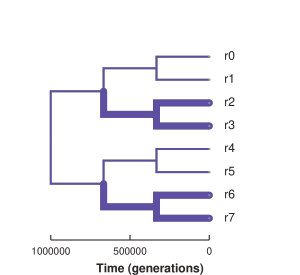

In [193]:
# draw tree figure and save it
# kwargs settings for tree drawing
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt",
    fixed_order=NAME_ORDER
)

# canvas for tree
c, a, m = baltree_1_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree-bal-ne-gunits.svg")
c


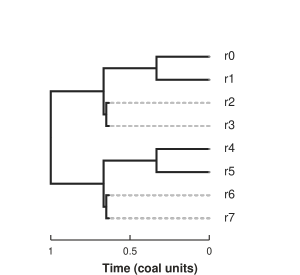

In [194]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = baltree_1_ne.set_node_data("dist", {i: i.tc for i in baltree_1_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree-bal-ne-cunits.svg")
c

### 1.2 Species tree with variable `gt`

In [12]:
baltree_1_gt = BALTREE.copy()
baltree_1_gt = baltree_1_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_1_gt = baltree_1_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES1}, default=GT_DEFAULT)
baltree_1_gt = baltree_1_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_1_gt})

# convert dist to units of generations. Draw and show data
baltree_1_gt = baltree_1_gt.set_node_data("dist", {i: i.tg for i in baltree_1_gt})
baltree_1_gt.get_node_data()

idx name          height           dist  support        Ne  gt    rho  \
0     0   r0        0.000000  333333.333333      NaN  500000.0   1  0.002   
1     1   r1        0.000000  333333.333333      NaN  500000.0   1  0.002   
2     2   r2   633333.333333   16666.666667      NaN  500000.0  20  0.002   
3     3   r3   633333.333333   16666.666667      NaN  500000.0  20  0.002   
4     4   r4        0.000000  333333.333333      NaN  500000.0   1  0.002   
5     5   r5        0.000000  333333.333333      NaN  500000.0   1  0.002   
6     6   r6   633333.333333   16666.666667      NaN  500000.0  20  0.002   
7     7   r7   633333.333333   16666.666667      NaN  500000.0  20  0.002   
8     8        333333.333333  333333.333333      NaN  500000.0   1  0.002   
9     9        650000.000000   16666.666667      NaN  500000.0  20  0.002   
10   10        666666.666667  333333.333333      NaN  500000.0   1  0.002   
11   11        333333.333333  333333.333333      NaN  500000.0   1  0.002   
12   12        650000.000000   16666.666667      NaN  500000.0  20  0.002   
13   13        666666.666667  333333.333333      NaN  500000.0   1  0.002   
14   14       1000000.000000       0.000000      NaN  500000.0   1  0.002   

          tc             tg      tg_rho      tg_theta  theta  
0   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
1   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
2   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
3   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
4   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
5   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
6   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
7   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
8   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
9   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
10  0.333333  333333.333333  666.666667  6.666667e-06   0.02  
11  0.333333  333333.333333  666.666667  6.666667e-06   0.02  
12  0.016667   16666.666667   33.333333  3.333333e-07   0.02  
13  0.333333  333333.333333  666.666667  6.666667e-06   0.02  
14  0.000000       0.000000    0.000000  0.000000e+00   0.02

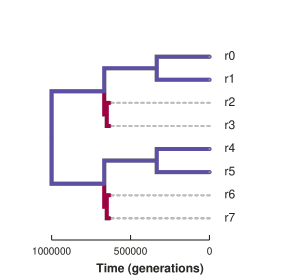

In [195]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
    fixed_order=NAME_ORDER
)
c, a, m = baltree_1_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree-bal-gt-gunits.svg")
c

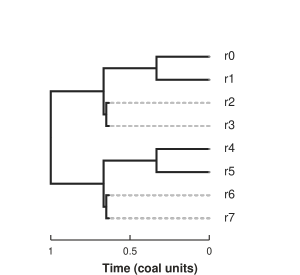

In [196]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, 
              tip_labels_align=True,
              fixed_order=NAME_ORDER)
c, a, m = baltree_1_gt.set_node_data("dist", {i: i.tc for i in baltree_1_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree-bal-gt-cunits.svg")
c

### 2. Modifications on root edges = use EDGES2

### 2.1 Species tree with variable `Ne`

In [15]:
# set parameters on the species tree
baltree_2_ne = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_ne.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_ne = baltree_2_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES2}, default=NE_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_ne})

# convert edge lens to units of generations.
baltree_2_ne = baltree_2_ne.set_node_data("dist", {i: i.tg for i in baltree_2_ne})

# show data
baltree_2_ne.get_node_data()

idx name          height           dist  support          Ne  gt    rho  \
0     0   r0        0.000000  333333.333333      NaN    500000.0   1  0.002   
1     1   r1        0.000000  333333.333333      NaN    500000.0   1  0.002   
2     2   r2        0.000000  333333.333333      NaN  10000000.0   1  0.040   
3     3   r3        0.000000  333333.333333      NaN  10000000.0   1  0.040   
4     4   r4        0.000000  333333.333333      NaN    500000.0   1  0.002   
5     5   r5        0.000000  333333.333333      NaN    500000.0   1  0.002   
6     6   r6        0.000000  333333.333333      NaN  10000000.0   1  0.040   
7     7   r7        0.000000  333333.333333      NaN  10000000.0   1  0.040   
8     8        333333.333333  333333.333333      NaN    500000.0   1  0.002   
9     9        333333.333333  333333.333333      NaN  10000000.0   1  0.040   
10   10        666666.666667  333333.333333      NaN  10000000.0   1  0.040   
11   11        333333.333333  333333.333333      NaN    500000.0   1  0.002   
12   12        333333.333333  333333.333333      NaN  10000000.0   1  0.040   
13   13        666666.666667  333333.333333      NaN  10000000.0   1  0.040   
14   14       1000000.000000  333333.333333      NaN    500000.0   1  0.002   

          tc             tg        tg_rho  tg_theta  theta  
0   0.333333  333333.333333    666.666667  0.000007   0.02  
1   0.333333  333333.333333    666.666667  0.000007   0.02  
2   0.016667  333333.333333  13333.333333  0.000133   0.40  
3   0.016667  333333.333333  13333.333333  0.000133   0.40  
4   0.333333  333333.333333    666.666667  0.000007   0.02  
5   0.333333  333333.333333    666.666667  0.000007   0.02  
6   0.016667  333333.333333  13333.333333  0.000133   0.40  
7   0.016667  333333.333333  13333.333333  0.000133   0.40  
8   0.333333  333333.333333    666.666667  0.000007   0.02  
9   0.016667  333333.333333  13333.333333  0.000133   0.40  
10  0.016667  333333.333333  13333.333333  0.000133   0.40  
11  0.333333  333333.333333    666.666667  0.000007   0.02  
12  0.016667  333333.333333  13333.333333  0.000133   0.40  
13  0.016667  333333.333333  13333.333333  0.000133   0.40  
14  0.333333  333333.333333    666.666667  0.000007   0.02

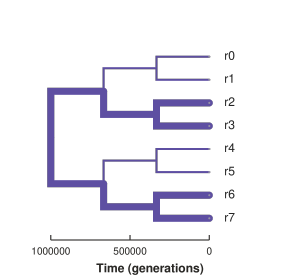

In [197]:
# draw tree figure and save it
# kwargs settings for tree drawing
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt",
    fixed_order=NAME_ORDER
)

# canvas for tree
c, a, m = baltree_2_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-ne-gunits.svg")
c


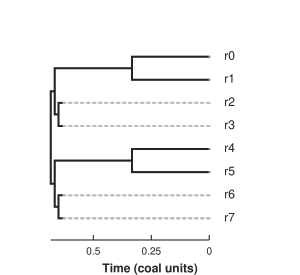

In [198]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = baltree_2_ne.set_node_data("dist", {i: i.tc for i in baltree_2_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-ne-cunits.svg")
c

### 2.2 Species tree with variable `gt`

In [18]:
baltree_2_gt = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_gt.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_gt = baltree_2_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES2}, default=GT_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_gt})

# convert dist to units of generations. Draw and show data
baltree_2_gt = baltree_2_gt.set_node_data("dist", {i: i.tg for i in baltree_2_gt})
baltree_2_gt.get_node_data()

idx name         height           dist  support        Ne  gt    rho  \
0     0   r0       0.000000  333333.333333      NaN  500000.0   1  0.002   
1     1   r1       0.000000  333333.333333      NaN  500000.0   1  0.002   
2     2   r2  633333.333333   16666.666667      NaN  500000.0  20  0.002   
3     3   r3  633333.333333   16666.666667      NaN  500000.0  20  0.002   
4     4   r4       0.000000  333333.333333      NaN  500000.0   1  0.002   
5     5   r5       0.000000  333333.333333      NaN  500000.0   1  0.002   
6     6   r6  633333.333333   16666.666667      NaN  500000.0  20  0.002   
7     7   r7  633333.333333   16666.666667      NaN  500000.0  20  0.002   
8     8       333333.333333  333333.333333      NaN  500000.0   1  0.002   
9     9       650000.000000   16666.666667      NaN  500000.0  20  0.002   
10   10       666666.666667   16666.666667      NaN  500000.0  20  0.002   
11   11       333333.333333  333333.333333      NaN  500000.0   1  0.002   
12   12       650000.000000   16666.666667      NaN  500000.0  20  0.002   
13   13       666666.666667   16666.666667      NaN  500000.0  20  0.002   
14   14       683333.333333  333333.333333      NaN  500000.0   1  0.002   

          tc             tg      tg_rho      tg_theta  theta  
0   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
1   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
2   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
3   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
4   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
5   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
6   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
7   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
8   0.333333  333333.333333  666.666667  6.666667e-06   0.02  
9   0.016667   16666.666667   33.333333  3.333333e-07   0.02  
10  0.016667   16666.666667   33.333333  3.333333e-07   0.02  
11  0.333333  333333.333333  666.666667  6.666667e-06   0.02  
12  0.016667   16666.666667   33.333333  3.333333e-07   0.02  
13  0.016667   16666.666667   33.333333  3.333333e-07   0.02  
14  0.333333  333333.333333  666.666667  6.666667e-06   0.02

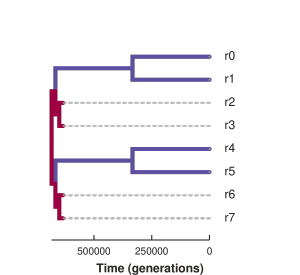

In [199]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
    fixed_order=NAME_ORDER
)
c, a, m = baltree_2_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-gt-gunits.svg")
c

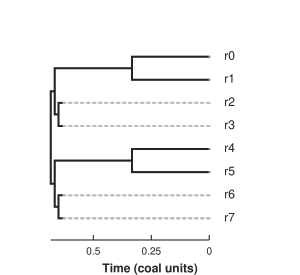

In [200]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = baltree_2_gt.set_node_data("dist", {i: i.tc for i in baltree_2_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-gt-cunits.svg")
c

## FUNCTIONS

In [71]:
def one_batch_sim(tree, nloci, nsites, nthreads, seed, infer):
    """Return two dataframes with genealogies and gene trees, respectively."""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    if (nsites == 1) or (not infer):
        raxdf = None
    else:
        # concatenate into multiple gene trees
        raxdf = ipcoal.phylo.infer_raxml_ng_trees(
            model, nthreads=nthreads, nproc=1, nworkers=1, do_not_autoscale_threads=True)
    return model.df, raxdf

In [85]:
def batch_sims(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, infer: bool = True):    
    """Return dataframes from simulations and tree inferences distributed to run in parallel"""
    if nloci == 1:
        # missing infer parameter
        return one_batch_sim(tree, nloci, nsites, nthreads, None, infer)

    # not perfect
    nloci_per = int(nloci / njobs)
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(njobs):
            rasyncs[i] = pool.submit(one_batch_sim, *(tree, nloci_per, nsites, nthreads, None, infer))
    gdata = []
    rdata = []
    for i in range(njobs):
        gdf, rdf = rasyncs[i].result()
        gdf.locus += i * nloci_per
        gdata.append(gdf)
        if rdf is not None:
            rdf.locus += i * nloci_per
            rdata.append(rdf)
    gdata = pd.concat(gdata, ignore_index=True)
    if rdata:
        rdata = pd.concat(rdata, ignore_index=True)
    return gdata, rdata

In [73]:
def one_concat(tree, nloci, nsites, nthreads, seed: int = None, nworkers: int = None):
    """Infer a concatenation tree"""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    # concatenate all into one tree
    raxtree = ipcoal.phylo.infer_raxml_ng_tree(
            model, nthreads=nthreads, nworkers=nworkers, do_not_autoscale_threads=True)
    return raxtree

In [104]:
def batch_concat(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, nreps: int = 10):
    """Return a list of inferred concatenation trees"""
    if nloci == 1:
        return one_concat(tree, nloci, nsites, nthreads, None)

    # not perfect
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(nreps):
            rasyncs[i] = pool.submit(one_concat, *(tree, nloci, nsites, nthreads, None))
    return [i.result() for i in rasyncs.values()]

In [75]:
def iter_first_genealogies(model_df: pd.DataFrame):
    for _, df in model_df.groupby("locus"):
        yield toytree.tree(df.iloc[0, 6])

In [76]:
def plot_matrix(
    dat: np.ndarray,
    domain_min: float = None,
    domain_max: float = None,
    cmap: str = "BlueRed",
    gap: float = 0,
    mask_diagonal: bool = False,
    color_bar: bool = False,
) -> "Canvas":
    """Return a matrix heatmap """
    
    # get min and max of the off-diagonal elements
    if mask_diagonal:
        dat = dat.copy()
        dat[np.diag_indices_from(dat)] = np.nanmean(dat)
        
    dmin = dat.min() if domain_min is None else domain_min
    dmax = dat.max() if domain_max is None else domain_max
    cmap = toyplot.color.brewer.map(cmap, domain_min=dmin, domain_max=dmax)
    
    # add 20 pixels to the right if legend
    if color_bar:
        color_bar = 20
    else:
        color_bar = 0
    
    # draw the matrix table
    canvas = toyplot.Canvas(300 + color_bar, 300)
    ax1 = canvas.table(
        rows=dat.shape[0], 
        columns=dat.shape[1],
        bounds=(50, 250, 50, 250),
    )
    
    # apply colors to cells but not diagonals
    for ridx in range(dat.shape[0]):
        for cidx in range(dat.shape[1]):
            col = cmap.color(dat[ridx, cidx])
            ax1.cells.cell[ridx, cidx].style = {'fill': col, 'stroke': 'none'}
            
            # overwrite if masking
            if (ridx == cidx) and mask_diagonal:
                ax1.cells.cell[ridx, cidx].style = {'fill': 'black', 'stroke': 'none'}
            
    # style spacing between grid cells            
    ax1.body.gaps.columns[...] = gap
    ax1.body.gaps.rows[...] = gap
    
    ax2 = canvas.cartesian(bounds=(50, 250, 50, 250), margin=0, padding=0)
    ax2.x.ticks.labels.show = False
    ax2.x.spine.style["stroke"] = "black"
    ax2.x.spine.style["stroke-width"] = 2
    ax2.y.ticks.labels.show = False
    ax2.y.spine.style["stroke"] = "black"
    ax2.y.spine.style["stroke-width"] = 2
    ax3 = ax2.share('x')
    ax3.y.ticks.labels.show = False
    ax3.y.spine.style["stroke"] = "black"
    ax3.y.spine.style["stroke-width"] = 2
    ax4 = ax2.share('y')
    ax4.x.ticks.labels.show = False
    ax4.x.spine.style["stroke"] = "black"
    ax4.x.spine.style["stroke-width"] = 2
    
    # add a colorbar to canvas
    if color_bar:
        numberline = canvas.numberline(270, 250, 270, 50)
        numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
        numberline.axis.ticks.locator = toyplot.locator.Extended(only_inside=True)
        numberline.axis.ticks.show = True
        numberline.axis.ticks.near = False
        numberline.axis.ticks.style["stroke-width"] = 2
        numberline.axis.spine.style["stroke-width"] = 2
        numberline.axis.ticks.labels.style["font-size"] = 14
    return canvas

### Test batch functions

In [31]:
# test: get dataframes of true and inferred trees
gdf, rdf = batch_sims(baltree_2_gt, nloci=100, nsites=1000, njobs=20, nthreads=3)
print(gdf.head())
print(rdf.head())

   locus  start  end  nbps  nsnps  tidx                    genealogy
0      0      0    6     6      0     0  ((r2:390765.120699848514...
1      0      6   89    83      3     1  ((r3:88759.1185226424131...
2      0     89  310   221     20     2  ((r3:88759.1185226424131...
3      0    310  396    86      7     3  ((r3:88759.1185226424131...
4      0    396  432    36      5     4  ((r3:88759.1185226424131...
   locus  start   end  nbps  nsnps                    gene_tree
0      0      0  1000  1000     73  (r0:0.020896,(((r6:0.004...
1      1      0  1000  1000    101  ((((r6:0.009073,(r7:0.00...
2      2      0  1000  1000     67  (r1:0.008061,(r4:0.00806...
3      3      0  1000  1000     76  (r0:0.008961,(r1:0.00687...
4      4      0  1000  1000     70  (r6:0.016193,(r2:1e-06,(...


In [32]:
# test: get raxml concat trees for (nloci * nsites) matrix
concats = batch_concat(baltree_2_gt, nloci=100, nsites=1e4, njobs=10, nthreads=3, nreps=10)
toytree.mtree(concats).draw();

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="250.0px" viewBox="0 0 750.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t455df180ea354a6983bd1f77fa74778d"> r4 r5 r0 r1 r2 r3 r6 r7 r4 r5 r7 r6 r3 r2 r1 r0 r3 r2 r6 r4 r5 r0 r1 r7 r7 r2 r3 r6 r0 r1 r5 r4

## VERIFICATION

### Ensure species tree scenario is in anomaly zone
### 2.1 Variable `Ne` scenario
a) Astral inferred from true genealogies should get the tree **CORRECT**:

In [33]:
ugdf_ne, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1, njobs=20, nthreads=3, infer=False)

In [34]:
atree_true_ne = ipcoal.phylo.infer_astral_tree(ugdf_ne.genealogy).root("r7").ladderize()

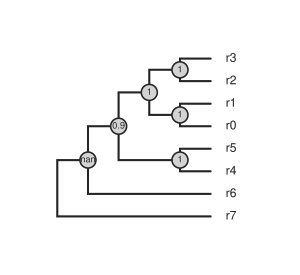

In [46]:
c, a, m = atree_true_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-true-astral.svg")
c

b) RAxML inferred from concatenated sequences should get the tree **WRONG**:

In [35]:
concat_tree_ne = one_concat(baltree_2_ne, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

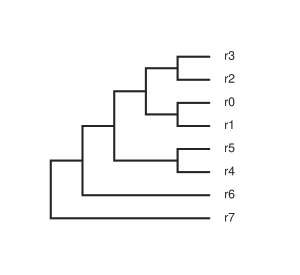

In [51]:
c, a, m = concat_tree_ne.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e3-concat.svg")
c

c) Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

Inferred raxml trees input to astral should probably get it right when nsites is **small**


In [63]:
gdf_ne_1e3, rdf_ne_1e3 = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [64]:
rdf_ne_1e3.to_csv("./nb6_output/rax-df-ne-1e3.csv")

In [65]:
gdf_ne_1e3.to_csv("./nb6_output/rax-df-ne-1e3-gtrees.csv")

In [66]:
atree_1e3_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e3.gene_tree).root("r7").ladderize()

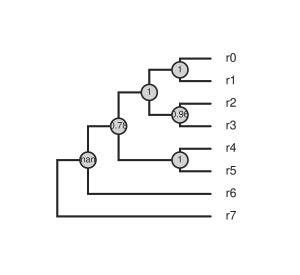

In [67]:
c, a, m = atree_1e3_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e3-astral.svg")
c

Inferred raxml trees input to astral should get it WRONG when nsites is very **large**

In [41]:
gdf_ne_1e5, rdf_ne_1e5 = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=2, infer=True)

In [61]:
rdf_ne_1e5.to_csv("./nb6_output/rax-df-ne-1e5.csv")

In [62]:
gdf_ne_1e5.to_csv("./nb6_output/rax-df-ne-1e5-gtrees.csv")

In [43]:
atree_1e5_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e5.gene_tree).root("r7").ladderize()

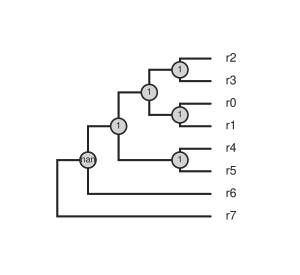

In [44]:
c, a, m = atree_1e5_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e5-astral.svg")
c

Compare inferred raxml trees output small vs. large

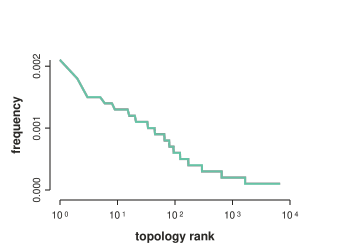

In [68]:
# nsites small output
hist = [j for i, j in toytree.mtree(rdf_ne_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

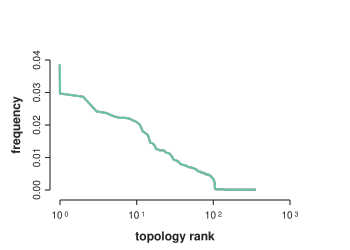

In [46]:
# nsites large output
hist = [j for i, j in toytree.mtree(rdf_ne_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

### 2.2 Variable `gt` scenario

a) Astral inferred from true genealogies should get the tree **CORRECT**:

In [47]:
ugdf_gt, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)

In [48]:
atree_true_gt = ipcoal.phylo.infer_astral_tree(ugdf_gt.genealogy).root("r7").ladderize()

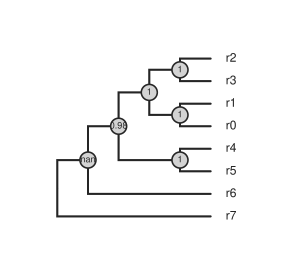

In [49]:
c, a, m = atree_true_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-gt2-true-astral.svg")
c

b) RAxML inferred from concatenated sequences should get the tree **WRONG**:

In [50]:
concat_tree_gt = one_concat(baltree_2_gt, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

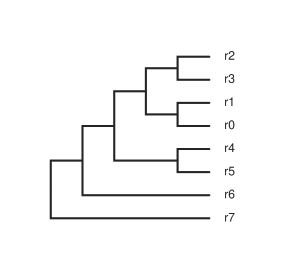

In [51]:
c, a, m = concat_tree_gt.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./nb6_output/infer-gt2-1e7-concat.svg")
c

c) Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

Inferred raxml trees input to astral should probably get it right when nsites is **small**

In [52]:
gdf_gt_1e3, rdf_gt_1e3 = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [59]:
rdf_gt_1e3.to_csv("./nb6_output/rax-df-gt-1e3.csv")

In [60]:
gdf_gt_1e3.to_csv("./nb6_output/rax-df-gt-1e3-gtrees.csv")

In [54]:
atree_1e3_gt = ipcoal.phylo.infer_astral_tree(rdf_gt_1e3.gene_tree).root("r7").ladderize()

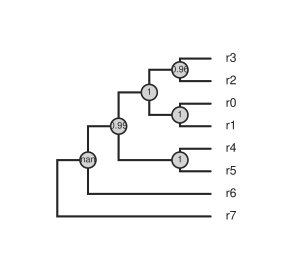

In [55]:
c, a, m = atree_1e3_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-gt2-1e3-astal.svg")
c

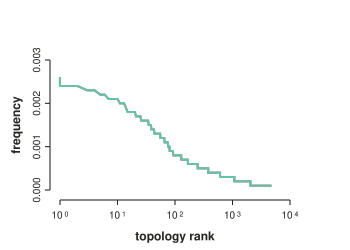

In [56]:
# genealogies topology
genealogies = list(iter_first_genealogies(gdf_gt_1e3))
hist = [j for i, j in toytree.mtree(genealogies).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

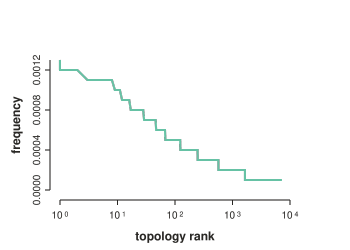

In [57]:
# raxml inferred gene tree topology
hist = [j for i, j in toytree.mtree(rdf_gt_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

Inferred raxml trees input to astral should get it WRONG when nsites is very **large**

In [14]:
gdf_gt_1e5, rdf_gt_1e5 = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=2, infer=True)

In [15]:
rdf_gt_1e5.to_csv("./nb6_output/rax-df-gt-1e5.csv")

In [16]:
gdf_gt_1e5.to_csv("./nb6_output/rax-df-gt-1e5-gtrees.csv")

In [17]:
atree_gt_1e5 = ipcoal.phylo.infer_astral_tree(rdf_gt_1e5.gene_tree).root("r7").ladderize()

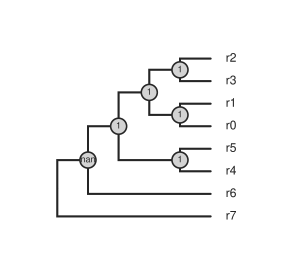

In [19]:
c, a, m = atree_gt_1e5.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-gt2-1e5-astral.svg")
c

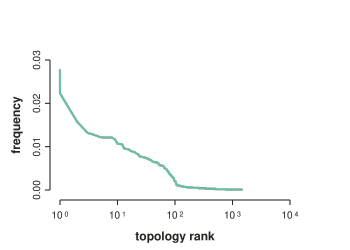

In [20]:
hist = [j for i, j in toytree.mtree(rdf_gt_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

## SIMULATE

### Superset runs, variable Ne/gt, linked, 1e3/1e5

In [25]:
_, batch = batch_sims(baltree_2_ne, nloci=50_000, nsites=1e5, njobs=20, nthreads=2, infer=True)
batch.to_csv("./nb6_output/superset-rax-df-ne2-1e5.csv")

In [28]:
_, batch = batch_sims(baltree_2_ne, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./nb6_output/superset-rax-df-ne2-1e3.csv")

In [27]:
_, batch = batch_sims(baltree_2_gt, nloci=50_000, nsites=1e5, njobs=30, nthreads=1, infer=True)
batch.to_csv("./nb6_output/superset-rax-df-gt2-1e5.csv")

In [29]:
_, batch = batch_sims(baltree_2_gt, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./nb6_output/superset-rax-df-gt2-1e3.csv")

In [94]:
pd.read_csv("./nb6_output/superset-rax-df-gt2-1e3.csv")

Unnamed: 0  locus  start   end  nbps  nsnps  \
0               0      0      0  1000  1000     90   
1               1      1      0  1000  1000     74   
2               2      2      0  1000  1000     90   
3               3      3      0  1000  1000     84   
4               4      4      0  1000  1000     68   
...           ...    ...    ...   ...   ...    ...   
49995       49995  49995      0  1000  1000     77   
49996       49996  49996      0  1000  1000    128   
49997       49997  49997      0  1000  1000    108   
49998       49998  49998      0  1000  1000    112   
49999       49999  49999      0  1000  1000     54   

                         gene_tree  
0      (r1:0.02871,(r0:0.00906,...  
1      ((r5:0.014571,((r6:0.004...  
2      (r5:0.045907,((r7:0.0060...  
3      (r0:0.006164,((r5:0.0068...  
4      (r3:0.007076,(r0:0.02434...  
...                            ...  
49995  (r0:0.023599,r4:0.004957...  
49996  (((r7:0.008089,r3:0.0070...  
49997  ((r7:0.001398,r0:0.00694...  
49998  (r4:0.00967,(r3:0.001595...  
49999  (r0:0.001001,(((r7:0.004...  

[50000 rows x 7 columns]

### Superset runs, true unlinked

In [101]:
batch,_ = batch_sims(baltree_2_ne, nloci=50_000, nsites=1, njobs=20, nthreads=3, infer=False)
batch.to_csv("./nb6_output/superset-rax-df-true-ne-unlinked-bal.csv")

In [102]:
batch,_  = batch_sims(baltree_2_gt, nloci=50_000, nsites=1, njobs=20, nthreads=3, infer=False)
batch.to_csv("./nb6_output/superset-rax-df-true-gt-unlinked-bal.csv")

In [103]:
pd.read_csv("./nb6_output/superset-rax-df-true-gt-unlinked-bal.csv")

Unnamed: 0  locus  start  end  nbps  nsnps  tidx  \
0               0      0      0    1     1      0     0   
1               1      1      0    1     1      0     0   
2               2      2      0    1     1      1     0   
3               3      3      0    1     1      0     0   
4               4      4      0    1     1      0     0   
...           ...    ...    ...  ...   ...    ...   ...   
49995       49995  49995      0    1     1      0     0   
49996       49996  49996      0    1     1      0     0   
49997       49997  49997      0    1     1      0     0   
49998       49998  49998      0    1     1      0     0   
49999       49999  49999      0    1     1      0     0   

                         genealogy  
0      ((r0:754377.276079820934...  
1      ((r0:913433.240321727935...  
2      (r5:2092280.677903639385...  
3      ((r3:763678.299317834200...  
4      (((r4:375696.02116843353...  
...                            ...  
49995  (r3:2007827.653810295974...  
49996  ((r3:675010.797672149026...  
49997  ((r1:1167107.76853239862...  
49998  ((r5:777505.724105048691...  
49999  ((r6:73330.3778440509922...  

[50000 rows x 8 columns]

### Superset runs, concat only

In [ ]:
# ANALYSIS COMPLETE
batch = batch_concat(baltree_2_ne, nloci=NLOCI, nsites=1000, njobs=10, nthreads=2, nreps=100)
# use multitree, mtree.write(), write out nwk file
toytree.mtree(batch).write("./nb6_output/superset-ne-concat-only-bal.nwk")

In [ ]:
# ANALYSIS COMPLETE
batch = batch_concat(baltree_2_gt, nloci=NLOCI, nsites=1000, njobs=10, nthreads=2, nreps=100)
# use multitree, mtree.write(), write out nwk file
toytree.mtree(batch).write("./nb6_output/superset-gt-concat-only-bal.nwk")

## MATRIX FIGURES

### Unlinked: variable Ne

In [128]:
variable_ne, _ = batch_sims(baltree_2_ne, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)
variable_ne.to_csv("./nb6_output/variable_ne.csv")

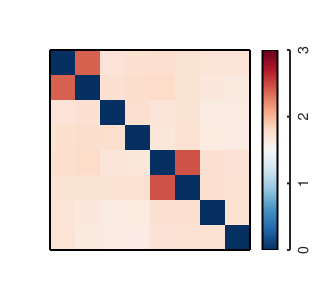

In [236]:
mdata = variable_ne

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_ne.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_unlinked_var = np.var(distances, axis=0)
# arr_variable_ne_unlinked_mean = np.mean(distances, axis=0)

c = plot_matrix(arr_variable_ne_unlinked_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb6_output/variable-ne-unlinked-var.svg")
c

### Unlinked: variable gt

In [130]:
variable_gt, _ = batch_sims(baltree_2_gt, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)
variable_gt.to_csv("./nb6_output/variable_gt.csv")

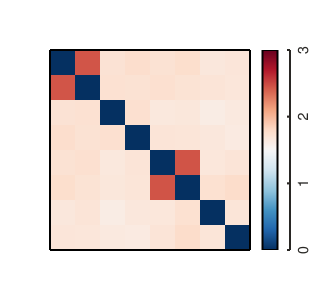

In [237]:
mdata = variable_gt

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_gt.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)

arr_variable_gt_unlinked_var = np.var(distances, axis=0)
# arr_variable_gt_unlinked_mean = np.mean(distances, axis=0)

c = plot_matrix(arr_variable_gt_unlinked_var, color_bar=True, domain_max=3.);
toyplot.svg.render(c, "./nb6_output/variable-gt-unlinked-var.svg")
c

### Linked 2K: variable Ne

In [115]:
variable_ne_2K_true, _ = batch_sims(baltree_2_ne, nloci=10_000, nsites=2000, njobs=20, nthreads=2, infer=False)
variable_ne_2K_true.to_csv("./nb6_output/variable_ne_2K_true.csv")

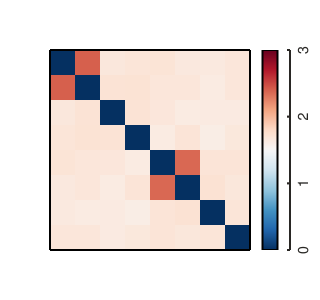

In [238]:
mdata = variable_ne_2K_true

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_linked_2K_var = np.var(distances, axis=0)
# arr_variable_ne_linked2000_mean = np.mean(distances, axis=0)

c = plot_matrix(arr_variable_ne_linked_2K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb6_output/variable-ne-linked-2K-var.svg")
c

### Linked 10K: variable Ne

In [117]:
variable_ne_10K_true, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_ne_10K_true.to_csv("./nb6_output/variable_ne_10K_true.csv")

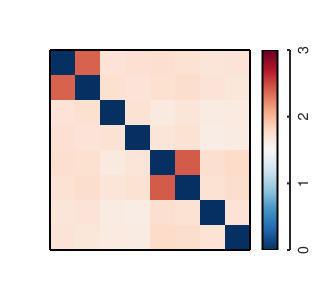

In [239]:
mdata = variable_ne_10K_true

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_linked_10K_var = np.var(distances, axis=0)

c = plot_matrix(arr_variable_ne_linked_10K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb6_output/variable-ne-linked-10K-var.svg")
c

### Linked 2K: variable gt

In [119]:
variable_gt_2K_true, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=2, infer=False)
variable_gt_2K_true.to_csv("./nb6_output/variable_gt_2K_true.csv")

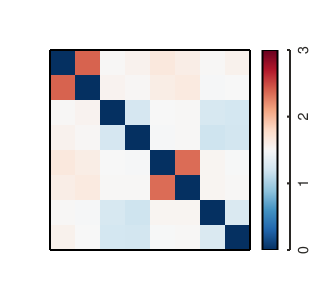

In [240]:
mdata = variable_gt_2K_true

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_gt.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_gt_linked_2K_var = np.var(distances, axis=0)

c = plot_matrix(arr_variable_gt_linked_2K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb6_output/variable-gt-linked-2K-var.svg")
c

### Linked 10K: variable gt

In [121]:
variable_gt_10K_true, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_gt_10K_true.to_csv("./nb6_output/variable_gt_10K_true.csv")

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   6   6   6   5
r1   2   0   3   6   6   6   6   5
r2   3   3   0   5   5   5   5   4
r3   6   6   5   0   6   6   2   5
r4   6   6   5   6   0   2   6   3
r5   6   6   5   6   2   0   6   3
r6   6   6   5   2   6   6   0   5
r7   5   5   4   5   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   6   5   2   5
r1   4   0   5   6   6   3   4   3
r2   5   5   0   3   3   6   5   6
r3   6   6   3   0   2   7   6   7
r4   6   6   3   2   0   7   6   7
r5   5   3   6   7   7   0   5   2
r6   2   4   5   6   6   5   0   5
r7   5   3   6   7   7   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   4   3   5   5   5
r1   3   0   5   5   4   4   4   4
r2   4   5   0   2   3   7   7   7
r3   4   5   2   0   3   7   7   7
r4   3   4   3   3   0   6   6   6
r5   5   4   7   7   6   0   4   2
r6   5   4   7   7   6   4   0   4
r7   5   4   7   7   6   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   5   7   7   3   2
r1   7   0   5   4   4   4   6   7
r2   4   5   0   3   5   5   3   4
r3   5   4   3   0   4   4   4   5
r4   7   4   5   4   0   2   6   7
r5   7   4   5   4   2   0   6   7
r6   3   6   3   4   6   6   0   3
r7   2   7   4   5   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   3   5   6   6
r1   3   0   6   6   2   6   7   7
r2   5   6   0   4   6   2   5   5
r3   5   6   4   0   6   4   3   3
r4   3   2   6   6   0   6   7   7
r5   5   6   2   4   6   0   5   5
r6   6   7   5   3   7   5   0   2
r7   6   7   5   3   7   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   4   4   4   5
r1   4   0   7   6   6   6   2   7
r2   5   7   0   3   5   5   7   2
r3   4   6   3   0   4   4   6   3
r4   4   6   5   4   0   2   6   5
r5   4   6   5   4   2   0   6   5
r6   4   2   7   6   6   6   0   7
r7   5   7   2   3   5   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   7   4   7   5   2
r1   7   0   2   4   5   4   4   7
r2   7   2   0   4   5   4   4   7
r3   7   4   4   0   5   2   4   7
r4   4   5   5   5   0   5   3   4
r5   7   4   4   2   5   0   4   7
r6   5   4   4   4   3   4   0   5
r7   2   7   7   7   4   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   3   6   6   5
r1   2   0   6   6   3   6   6   5
r2   6   6   0   2   5   6   6   5
r3   6   6   2   0   5   6   6   5
r4   3   3   5   5   0   5   5   4
r5   6   6   6   6   5   0   2   3
r6   6   6   6   6   5   2   0   3
r7   5   5   5   5   4   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   6   4   7   3
r1   2   0   8   8   6   4   7   3
r2   8   8   0   2   4   6   3   7
r3   8   8   2   0   4   6   3   7
r4   6   6   4   4   0   4   3   5
r5   4   4   6   6   4   0   5   3
r6   7   7   3   3   3   5   0   6
r7   3   3   7   7   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2   6   5   5   6
r1   6   0   6   6   2   5   3   6
r2   6   6   0   6   6   3   5   2
r3   2   6   6   0   6   5   5   6
r4   6   2   6   6   0   5   3   6
r5   5   5   3   5   5   0   4   3
r6   5   3   5   5   3   4   0   5
r7   6   6   2   6   6   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   6   4   6
r1   2   0   5   5   5   6   4   6
r2   5   5   0   2   6   7   3   7
r3   5   5   2   0   6   7   3   7
r4   5   5   6   6   0   3   5   3
r5   6   6   7   7   3   0   6   2
r6   4   4   3   3   5   6   0   6
r7   6   6   7   7   3   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   6   3   4   7
r1   2   0   7   6   6   3   4   7
r2   7   7   0   5   5   6   5   2
r3   6   6   5   0   2   5   4   5
r4   6   6   5   2   0   5   4   5
r5   3   3   6   5   5   0   3   6
r6   4   4   5   4   4   3   0   5
r7   7   7   2   5   5   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   3   4   8   7   6
r1   2   0   8   3   4   8   7   6
r2   8   8   0   7   6   2   3   4
r3   3   3   7   0   3   7   6   5
r4   4   4   6   3   0   6   5   4
r5   8   8   2   7   6   0   3   4
r6   7   7   3   6   5   3   0   3
r7   6   6   4   5   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   5   5   5   6   2
r1   6   0   6   5   5   3   2   6
r2   4   6   0   5   5   5   6   4
r3   5   5   5   0   2   4   5   5
r4   5   5   5   2   0   4   5   5
r5   5   3   5   4   4   0   3   5
r6   6   2   6   5   5   3   0   6
r7   2   6   4   5   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   5   4   6   6
r1   2   0   5   4   5   4   6   6
r2   5   5   0   5   6   3   3   3
r3   4   4   5   0   3   4   6   6
r4   5   5   6   3   0   5   7   7
r5   4   4   3   4   5   0   4   4
r6   6   6   3   6   7   4   0   2
r7   6   6   3   6   7   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   5   5   5   7
r1   2   0   7   6   5   5   5   7
r2   7   7   0   3   6   6   4   2
r3   6   6   3   0   5   5   3   3
r4   5   5   6   5   0   2   4   6
r5   5   5   6   5   2   0   4   6
r6   5   5   4   3   4   4   0   4
r7   7   7   2   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2   8   5   8   7
r1   4   0   4   4   6   3   6   5
r2   6   4   0   6   4   3   4   3
r3   2   4   6   0   8   5   8   7
r4   8   6   4   8   0   5   2   3
r5   5   3   3   5   5   0   5   4
r6   8   6   4   8   2   5   0   3
r7   7   5   3   7   3   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   6   5   5
r1   2   0   5   4   6   6   5   5
r2   5   5   0   5   7   7   6   2
r3   4   4   5   0   4   4   3   5
r4   6   6   7   4   0   2   3   7
r5   6   6   7   4   2   0   3   7
r6   5   5   6   3   3   3   0   6
r7   5   5   2   5   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   2   5   5   4
r1   6   0   2   7   6   7   3   6
r2   6   2   0   7   6   7   3   6
r3   5   7   7   0   5   2   6   3
r4   2   6   6   5   0   5   5   4
r5   5   7   7   2   5   0   6   3
r6   5   3   3   6   5   6   0   5
r7   4   6   6   3   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   4   3   6   6   7
r1   6   0   6   4   5   2   4   5
r2   2   6   0   4   3   6   6   7
r3   4   4   4   0   3   4   4   5
r4   3   5   3   3   0   5   5   6
r5   6   2   6   4   5   0   4   5
r6   6   4   6   4   5   4   0   3
r7   7   5   7   5   6   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   5   3   3   5
r1   4   0   7   2   7   3   5   7
r2   5   7   0   7   4   6   4   4
r3   4   2   7   0   7   3   5   7
r4   5   7   4   7   0   6   4   2
r5   3   3   6   3   6   0   4   6
r6   3   5   4   5   4   4   0   4
r7   5   7   4   7   2   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   3   5   6   6
r1   2   0   6   6   3   5   6   6
r2   6   6   0   6   5   5   6   2
r3   6   6   6   0   5   3   2   6
r4   3   3   5   5   0   4   5   5
r5   5   5   5   3   4   0   3   5
r6   6   6   6   2   5   3   0   6
r7   6   6   2   6   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   5   3   5   6   3
r1   5   0   6   4   6   2   5   4
r2   3   6   0   6   2   6   7   4
r3   5   4   6   0   6   4   3   4
r4   3   6   2   6   0   6   7   4
r5   5   2   6   4   6   0   5   4
r6   6   5   7   3   7   5   0   5
r7   3   4   4   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   5   6   3   3   4
r1   7   0   2   4   3   8   8   5
r2   7   2   0   4   3   8   8   5
r3   5   4   4   0   3   6   6   3
r4   6   3   3   3   0   7   7   4
r5   3   8   8   6   7   0   2   5
r6   3   8   8   6   7   2   0   5
r7   4   5   5   3   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   2   4   6   4
r1   5   0   7   2   5   5   7   3
r2   6   7   0   7   6   4   2   6
r3   5   2   7   0   5   5   7   3
r4   2   5   6   5   0   4   6   4
r5   4   5   4   5   4   0   4   4
r6   6   7   2   7   6   4   0   6
r7   4   3   6   3   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   7   4   6   6
r1   2   0   3   7   7   4   6   6
r2   3   3   0   6   6   3   5   5
r3   7   7   6   0   2   5   5   5
r4   7   7   6   2   0   5   5   5
r5   4   4   3   5   5   0   4   4
r6   6   6   5   5   5   4   0   2
r7   6   6   5   5   5   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   2   6   4   6   3
r1   7   0   2   7   5   5   5   6
r2   7   2   0   7   5   5   5   6
r3   2   7   7   0   6   4   6   3
r4   6   5   5   6   0   4   2   5
r5   4   5   5   4   4   0   4   3
r6   6   5   5   6   2   4   0   5
r7   3   6   6   3   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   6   7   7   5   5
r1   5   0   5   5   6   6   2   4
r2   2   5   0   6   7   7   5   5
r3   6   5   6   0   3   3   5   3
r4   7   6   7   3   0   2   6   4
r5   7   6   7   3   2   0   6   4
r6   5   2   5   5   6   6   0   4
r7   5   4   5   3   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7   7   4   4   4
r1   2   0   5   7   7   4   4   4
r2   5   5   0   4   4   5   3   5
r3   7   7   4   0   2   7   5   7
r4   7   7   4   2   0   7   5   7
r5   4   4   5   7   7   0   4   2
r6   4   4   3   5   5   4   0   4
r7   4   4   5   7   7   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   6   3   7   4   2
r1   6   0   5   2   5   5   4   6
r2   7   5   0   5   6   2   5   7
r3   6   2   5   0   5   5   4   6
r4   3   5   6   5   0   6   3   3
r5   7   5   2   5   6   0   5   7
r6   4   4   5   4   3   5   0   4
r7   2   6   7   6   3   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   7   7   2   4
r1   4   0   4   3   5   5   4   4
r2   4   4   0   5   7   7   4   2
r3   5   3   5   0   4   4   5   5
r4   7   5   7   4   0   2   7   7
r5   7   5   7   4   2   0   7   7
r6   2   4   4   5   7   7   0   4
r7   4   4   2   5   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4   3   5   6   4
r1   4   0   8   2   3   7   8   6
r2   6   8   0   8   7   3   2   4
r3   4   2   8   0   3   7   8   6
r4   3   3   7   3   0   6   7   5
r5   5   7   3   7   6   0   3   3
r6   6   8   2   8   7   3   0   4
r7   4   6   4   6   5   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   7   7   5   2
r1   5   0   3   4   4   4   4   5
r2   6   3   0   5   3   3   5   6
r3   5   4   5   0   6   6   2   5
r4   7   4   3   6   0   2   6   7
r5   7   4   3   6   2   0   6   7
r6   5   4   5   2   6   6   0   5
r7   2   5   6   5   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   5   5   5   2
r1   4   0   6   6   3   3   5   4
r2   6   6   0   2   7   7   3   6
r3   6   6   2   0   7   7   3   6
r4   5   3   7   7   0   2   6   5
r5   5   3   7   7   2   0   6   5
r6   5   5   3   3   6   6   0   5
r7   2   4   6   6   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   6   3   6
r1   2   0   6   5   6   6   3   6
r2   6   6   0   3   6   6   5   2
r3   5   5   3   0   5   5   4   3
r4   6   6   6   5   0   2   5   6
r5   6   6   6   5   2   0   5   6
r6   3   3   5   4   5   5   0   5
r7   6   6   2   3   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2   6   6   4   6
r1   6   0   6   6   4   2   6   4
r2   4   6   0   4   6   6   2   6
r3   2   6   4   0   6   6   4   6
r4   6   4   6   6   0   4   6   2
r5   6   2   6   6   4   0   6   4
r6   4   6   2   4   6   6   0   6
r7   6   4   6   6   2   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   4   4   4   4
r1   5   0   2   5   7   3   5   7
r2   5   2   0   5   7   3   5   7
r3   4   5   5   0   6   4   2   6
r4   4   7   7   6   0   6   6   2
r5   4   3   3   4   6   0   4   6
r6   4   5   5   2   6   4   0   6
r7   4   7   7   6   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   5   6   4
r1   2   0   5   4   6   5   6   4
r2   5   5   0   5   5   4   5   5
r3   4   4   5   0   6   5   6   2
r4   6   6   5   6   0   3   2   6
r5   5   5   4   5   3   0   3   5
r6   6   6   5   6   2   3   0   6
r7   4   4   5   2   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   6   7   7   6
r1   2   0   3   6   6   7   7   6
r2   3   3   0   5   5   6   6   5
r3   6   6   5   0   4   3   3   4
r4   6   6   5   4   0   5   5   2
r5   7   7   6   3   5   0   2   5
r6   7   7   6   3   5   2   0   5
r7   6   6   5   4   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4   4   4   7   5
r1   7   0   7   5   7   7   2   4
r2   2   7   0   4   4   4   7   5
r3   4   5   4   0   4   4   5   3
r4   4   7   4   4   0   2   7   5
r5   4   7   4   4   2   0   7   5
r6   7   2   7   5   7   7   0   4
r7   5   4   5   3   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   6   4   4   5   7
r1   7   0   7   3   7   7   4   2
r2   2   7   0   6   4   4   5   7
r3   6   3   6   0   6   6   3   3
r4   4   7   4   6   0   2   5   7
r5   4   7   4   6   2   0   5   7
r6   5   4   5   3   5   5   0   4
r7   7   2   7   3   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   5   5   6   4
r1   2   0   4   5   5   5   6   4
r2   4   4   0   5   3   3   6   4
r3   5   5   5   0   6   6   3   3
r4   5   5   3   6   0   2   7   5
r5   5   5   3   6   2   0   7   5
r6   6   6   6   3   7   7   0   4
r7   4   4   4   3   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   2   5   8   7   4   8
r1   3   0   3   4   7   6   3   7
r2   2   3   0   5   8   7   4   8
r3   5   4   5   0   5   4   3   5
r4   8   7   8   5   0   3   6   2
r5   7   6   7   4   3   0   5   3
r6   4   3   4   3   6   5   0   6
r7   8   7   8   5   2   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   7   7   5   3
r1   6   0   5   6   3   3   5   5
r2   5   5   0   5   6   6   2   4
r3   2   6   5   0   7   7   5   3
r4   7   3   6   7   0   2   6   6
r5   7   3   6   7   2   0   6   6
r6   5   5   2   5   6   6   0   4
r7   3   5   4   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   6   7   4   2
r1   4   0   5   2   6   7   4   4
r2   5   5   0   5   3   4   3   5
r3   4   2   5   0   6   7   4   4
r4   6   6   3   6   0   3   4   6
r5   7   7   4   7   3   0   5   7
r6   4   4   3   4   4   5   0   4
r7   2   4   5   4   6   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   8   2   7   6   8
r1   4   0   3   6   4   5   4   6
r2   5   3   0   5   5   4   3   5
r3   8   6   5   0   8   3   4   2
r4   2   4   5   8   0   7   6   8
r5   7   5   4   3   7   0   3   3
r6   6   4   3   4   6   3   0   4
r7   8   6   5   2   8   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   6   4   4   7
r1   2   0   7   5   6   4   4   7
r2   7   7   0   4   3   7   7   2
r3   5   5   4   0   3   5   5   4
r4   6   6   3   3   0   6   6   3
r5   4   4   7   5   6   0   2   7
r6   4   4   7   5   6   2   0   7
r7   7   7   2   4   3   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   3   6   6   2   6
r1   5   0   5   4   3   5   5   3
r2   6   5   0   5   6   2   6   6
r3   3   4   5   0   5   5   3   5
r4   6   3   6   5   0   6   6   2
r5   6   5   2   5   6   0   6   6
r6   2   5   6   3   6   6   0   6
r7   6   3   6   5   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4   7   7   7   5
r1   7   0   7   5   2   4   4   4
r2   2   7   0   4   7   7   7   5
r3   4   5   4   0   5   5   5   3
r4   7   2   7   5   0   4   4   4
r5   7   4   7   5   4   0   2   4
r6   7   4   7   5   4   2   0   4
r7   5   4   5   3   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   7   8   8   3
r1   2   0   4   5   7   8   8   3
r2   4   4   0   3   5   6   6   3
r3   5   5   3   0   4   5   5   4
r4   7   7   5   4   0   3   3   6
r5   8   8   6   5   3   0   2   7
r6   8   8   6   5   3   2   0   7
r7   3   3   3   4   6   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   7   7   4   4
r1   2   0   6   4   7   7   4   4
r2   6   6   0   4   3   3   6   6
r3   4   4   4   0   5   5   4   4
r4   7   7   3   5   0   2   7   7
r5   7   7   3   5   2   0   7   7
r6   4   4   6   4   7   7   0   2
r7   4   4   6   4   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   7   4   5   4
r1   2   0   4   7   7   4   5   4
r2   4   4   0   7   7   2   5   4
r3   7   7   7   0   2   7   4   5
r4   7   7   7   2   0   7   4   5
r5   4   4   2   7   7   0   5   4
r6   5   5   5   4   4   5   0   3
r7   4   4   4   5   5   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   4   4   3   4
r1   4   0   5   5   6   6   5   2
r2   5   5   0   2   7   7   6   5
r3   5   5   2   0   7   7   6   5
r4   4   6   7   7   0   2   3   6
r5   4   6   7   7   2   0   3   6
r6   3   5   6   6   3   3   0   5
r7   4   2   5   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   5   5   2   5
r1   4   0   5   5   5   3   4   5
r2   5   5   0   4   4   6   5   2
r3   5   5   4   0   2   6   5   4
r4   5   5   4   2   0   6   5   4
r5   5   3   6   6   6   0   5   6
r6   2   4   5   5   5   5   0   5
r7   5   5   2   4   4   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   5   5   5   5
r1   2   0   4   5   5   5   5   5
r2   4   4   0   5   3   3   5   5
r3   5   5   5   0   6   6   2   4
r4   5   5   3   6   0   2   6   6
r5   5   5   3   6   2   0   6   6
r6   5   5   5   2   6   6   0   4
r7   5   5   5   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   3   6   6   5   4
r1   4   0   5   3   4   4   3   6
r2   3   5   0   4   7   7   6   3
r3   3   3   4   0   5   5   4   5
r4   6   4   7   5   0   2   3   8
r5   6   4   7   5   2   0   3   8
r6   5   3   6   4   3   3   0   7
r7   4   6   3   5   8   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   4   4   3   5
r1   3   0   4   4   5   5   4   4
r2   5   4   0   4   7   7   6   4
r3   5   4   4   0   7   7   6   2
r4   4   5   7   7   0   2   3   7
r5   4   5   7   7   2   0   3   7
r6   3   4   6   6   3   3   0   6
r7   5   4   4   2   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   8   8   4   2   6
r1   7   0   6   3   3   5   7   3
r2   3   6   0   7   7   3   3   5
r3   8   3   7   0   2   6   8   4
r4   8   3   7   2   0   6   8   4
r5   4   5   3   6   6   0   4   4
r6   2   7   3   8   8   4   0   6
r7   6   3   5   4   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   4   6   7   6
r1   2   0   3   7   4   6   7   6
r2   3   3   0   6   3   5   6   5
r3   7   7   6   0   5   5   2   5
r4   4   4   3   5   0   4   5   4
r5   6   6   5   5   4   0   5   2
r6   7   7   6   2   5   5   0   5
r7   6   6   5   5   4   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   6   8   8   7   2
r1   3   0   3   5   7   7   6   3
r2   4   3   0   4   6   6   5   4
r3   6   5   4   0   4   4   3   6
r4   8   7   6   4   0   2   3   8
r5   8   7   6   4   2   0   3   8
r6   7   6   5   3   3   3   0   7
r7   2   3   4   6   8   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   6   6   4   5
r1   5   0   5   6   7   7   3   2
r2   4   5   0   3   4   4   4   5
r3   5   6   3   0   3   3   5   6
r4   6   7   4   3   0   2   6   7
r5   6   7   4   3   2   0   6   7
r6   4   3   4   5   6   6   0   3
r7   5   2   5   6   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   3   6   6
r1   2   0   6   5   6   3   6   6
r2   6   6   0   5   6   5   6   2
r3   5   5   5   0   3   4   3   5
r4   6   6   6   3   0   5   2   6
r5   3   3   5   4   5   0   5   5
r6   6   6   6   3   2   5   0   6
r7   6   6   2   5   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5   7   7   6   4
r1   4   0   4   5   7   7   6   2
r2   2   4   0   5   7   7   6   4
r3   5   5   5   0   4   4   3   5
r4   7   7   7   4   0   2   3   7
r5   7   7   7   4   2   0   3   7
r6   6   6   6   3   3   3   0   6
r7   4   2   4   5   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   6   6   5   2
r1   6   0   2   5   6   6   3   6
r2   6   2   0   5   6   6   3   6
r3   5   5   5   0   3   3   4   5
r4   6   6   6   3   0   2   5   6
r5   6   6   6   3   2   0   5   6
r6   5   3   3   4   5   5   0   5
r7   2   6   6   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   8   4   5   8
r1   2   0   6   3   8   4   5   8
r2   6   6   0   5   4   4   3   4
r3   3   3   5   0   7   3   4   7
r4   8   8   4   7   0   6   5   2
r5   4   4   4   3   6   0   3   6
r6   5   5   3   4   5   3   0   5
r7   8   8   4   7   2   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   2   6   6   6   5
r1   6   0   5   6   6   6   2   5
r2   3   5   0   3   5   5   5   4
r3   2   6   3   0   6   6   6   5
r4   6   6   5   6   0   2   6   3
r5   6   6   5   6   2   0   6   3
r6   6   2   5   6   6   6   0   5
r7   5   5   4   5   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   6   6   6   2   6
r1   5   0   4   3   5   5   5   3
r2   3   4   0   5   5   5   3   5
r3   6   3   5   0   6   6   6   2
r4   6   5   5   6   0   2   6   6
r5   6   5   5   6   2   0   6   6
r6   2   5   3   6   6   6   0   6
r7   6   3   5   2   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   4   4   4   4
r1   4   0   5   5   6   6   2   4
r2   5   5   0   2   7   7   5   3
r3   5   5   2   0   7   7   5   3
r4   4   6   7   7   0   2   6   6
r5   4   6   7   7   2   0   6   6
r6   4   2   5   5   6   6   0   4
r7   4   4   3   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   7   7   6   4   5
r1   4   0   4   7   7   6   2   5
r2   2   4   0   7   7   6   4   5
r3   7   7   7   0   2   3   7   4
r4   7   7   7   2   0   3   7   4
r5   6   6   6   3   3   0   6   3
r6   4   2   4   7   7   6   0   5
r7   5   5   5   4   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   6   6   6   6
r1   2   0   5   5   6   6   6   6
r2   5   5   0   2   5   5   5   5
r3   5   5   2   0   5   5   5   5
r4   6   6   5   5   0   2   4   4
r5   6   6   5   5   2   0   4   4
r6   6   6   5   5   4   4   0   2
r7   6   6   5   5   4   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   2   5   5   6   6
r1   5   0   3   5   6   6   3   3
r2   4   3   0   4   5   5   4   4
r3   2   5   4   0   5   5   6   6
r4   5   6   5   5   0   2   7   7
r5   5   6   5   5   2   0   7   7
r6   6   3   4   6   7   7   0   2
r7   6   3   4   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   5   5   3   4
r1   4   0   7   7   3   3   5   6
r2   5   7   0   2   8   8   4   3
r3   5   7   2   0   8   8   4   3
r4   5   3   8   8   0   2   6   7
r5   5   3   8   8   2   0   6   7
r6   3   5   4   4   6   6   0   3
r7   4   6   3   3   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   6   4   8   8
r1   2   0   7   3   6   4   8   8
r2   7   7   0   6   3   5   3   3
r3   3   3   6   0   5   3   7   7
r4   6   6   3   5   0   4   4   4
r5   4   4   5   3   4   0   6   6
r6   8   8   3   7   4   6   0   2
r7   8   8   3   7   4   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   6   2   7   7
r1   4   0   4   4   4   4   5   5
r2   6   4   0   4   4   6   3   3
r3   6   4   4   0   2   6   5   5
r4   6   4   4   2   0   6   5   5
r5   2   4   6   6   6   0   7   7
r6   7   5   3   5   5   7   0   2
r7   7   5   3   5   5   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   2   5   5   7   6
r1   7   0   4   7   6   6   2   3
r2   5   4   0   5   4   4   4   3
r3   2   7   5   0   5   5   7   6
r4   5   6   4   5   0   2   6   5
r5   5   6   4   5   2   0   6   5
r6   7   2   4   7   6   6   0   3
r7   6   3   3   6   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   2   4   5   6   5
r1   5   0   5   5   5   4   5   2
r2   6   5   0   6   6   3   2   5
r3   2   5   6   0   4   5   6   5
r4   4   5   6   4   0   5   6   5
r5   5   4   3   5   5   0   3   4
r6   6   5   2   6   6   3   0   5
r7   5   2   5   5   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   4   5   6   4
r1   2   0   5   6   4   5   6   4
r2   5   5   0   3   5   4   3   5
r3   6   6   3   0   6   5   2   6
r4   4   4   5   6   0   5   6   2
r5   5   5   4   5   5   0   5   5
r6   6   6   3   2   6   5   0   6
r7   4   4   5   6   2   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   3   6   5   3   6
r1   4   0   4   5   4   3   5   4
r2   4   4   0   5   6   5   5   6
r3   3   5   5   0   7   6   2   7
r4   6   4   6   7   0   3   7   2
r5   5   3   5   6   3   0   6   3
r6   3   5   5   2   7   6   0   7
r7   6   4   6   7   2   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   7   4   5   2   4
r1   6   0   3   3   6   3   6   6
r2   7   3   0   2   7   4   7   7
r3   7   3   2   0   7   4   7   7
r4   4   6   7   7   0   5   4   2
r5   5   3   4   4   5   0   5   5
r6   2   6   7   7   4   5   0   4
r7   4   6   7   7   2   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   6   6   5   5
r1   2   0   3   6   6   6   5   5
r2   3   3   0   5   5   5   4   4
r3   6   6   5   0   6   6   5   3
r4   6   6   5   6   0   2   3   5
r5   6   6   5   6   2   0   3   5
r6   5   5   4   5   3   3   0   4
r7   5   5   4   3   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7   4   4   6   7
r1   2   0   5   7   4   4   6   7
r2   5   5   0   4   5   5   3   4
r3   7   7   4   0   7   7   3   2
r4   4   4   5   7   0   2   6   7
r5   4   4   5   7   2   0   6   7
r6   6   6   3   3   6   6   0   3
r7   7   7   4   2   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   4   3   6   3   4
r1   6   0   3   6   7   2   7   6
r2   5   3   0   5   6   3   6   5
r3   4   6   5   0   5   6   5   2
r4   3   7   6   5   0   7   2   5
r5   6   2   3   6   7   0   7   6
r6   3   7   6   5   2   7   0   5
r7   4   6   5   2   5   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   4   7   3   6
r1   2   0   8   8   4   7   3   6
r2   8   8   0   2   6   3   7   4
r3   8   8   2   0   6   3   7   4
r4   4   4   6   6   0   5   3   4
r5   7   7   3   3   5   0   6   3
r6   3   3   7   7   3   6   0   5
r7   6   6   4   4   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   7   4   7   2   6
r1   4   0   4   5   4   5   4   4
r2   4   4   0   7   2   7   4   6
r3   7   5   7   0   7   2   7   3
r4   4   4   2   7   0   7   4   6
r5   7   5   7   2   7   0   7   3
r6   2   4   4   7   4   7   0   6
r7   6   4   6   3   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   8   3   2   8   6   7
r1   4   0   6   3   4   6   4   5
r2   8   6   0   7   8   2   4   3
r3   3   3   7   0   3   7   5   6
r4   2   4   8   3   0   8   6   7
r5   8   6   2   7   8   0   4   3
r6   6   4   4   5   6   4   0   3
r7   7   5   3   6   7   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   5   6   3   2
r1   6   0   2   5   5   4   5   6
r2   6   2   0   5   5   4   5   6
r3   5   5   5   0   2   5   4   5
r4   5   5   5   2   0   5   4   5
r5   6   4   4   5   5   0   5   6
r6   3   5   5   4   4   5   0   3
r7   2   6   6   5   5   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   2   8   4   7   3   6
r1   8   0   8   2   6   3   7   4
r2   2   8   0   8   4   7   3   6
r3   8   2   8   0   6   3   7   4
r4   4   6   4   6   0   5   3   4
r5   7   3   7   3   5   0   6   3
r6   3   7   3   7   3   6   0   5
r7   6   4   6   4   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   6   6   6   5
r1   6   0   5   6   4   4   2   5
r2   5   5   0   5   5   5   5   2
r3   2   6   5   0   6   6   6   5
r4   6   4   5   6   0   2   4   5
r5   6   4   5   6   2   0   4   5
r6   6   2   5   6   4   4   0   5
r7   5   5   2   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   7   2   7   4   7
r1   3   0   4   6   3   6   3   6
r2   5   4   0   4   5   4   3   4
r3   7   6   4   0   7   2   5   4
r4   2   3   5   7   0   7   4   7
r5   7   6   4   2   7   0   5   4
r6   4   3   3   5   4   5   0   5
r7   7   6   4   4   7   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   3   6   6   4   4
r1   4   0   3   5   8   8   2   6
r2   3   3   0   4   7   7   3   5
r3   3   5   4   0   5   5   5   3
r4   6   8   7   5   0   2   8   4
r5   6   8   7   5   2   0   8   4
r6   4   2   3   5   8   8   0   6
r7   4   6   5   3   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4   5   3   3   6
r1   4   0   6   2   5   5   5   6
r2   6   6   0   6   3   7   7   2
r3   4   2   6   0   5   5   5   6
r4   5   5   3   5   0   6   6   3
r5   3   5   7   5   6   0   2   7
r6   3   5   7   5   6   2   0   7
r7   6   6   2   6   3   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   6   4   2   4
r1   5   0   7   2   7   5   5   3
r2   6   7   0   7   2   4   6   6
r3   5   2   7   0   7   5   5   3
r4   6   7   2   7   0   4   6   6
r5   4   5   4   5   4   0   4   4
r6   2   5   6   5   6   4   0   4
r7   4   3   6   3   6   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   4   5   4   3   6
r1   4   0   5   6   7   2   3   8
r2   3   5   0   3   4   5   4   5
r3   4   6   3   0   3   6   5   4
r4   5   7   4   3   0   7   6   3
r5   4   2   5   6   7   0   3   8
r6   3   3   4   5   6   3   0   7
r7   6   8   5   4   3   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   3   4   4   4   5
r1   5   0   7   6   5   5   3   2
r2   4   7   0   3   6   6   6   7
r3   3   6   3   0   5   5   5   6
r4   4   5   6   5   0   2   4   5
r5   4   5   6   5   2   0   4   5
r6   4   3   6   5   4   4   0   3
r7   5   2   7   6   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   3   6   7   5
r1   2   0   7   5   3   6   7   5
r2   7   7   0   6   6   3   2   6
r3   5   5   6   0   4   5   6   2
r4   3   3   6   4   0   5   6   4
r5   6   6   3   5   5   0   3   5
r6   7   7   2   6   6   3   0   6
r7   5   5   6   2   4   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   4   4   3   4   6
r1   3   0   7   5   5   2   5   7
r2   6   7   0   4   6   7   6   2
r3   4   5   4   0   4   5   4   4
r4   4   5   6   4   0   5   2   6
r5   3   2   7   5   5   0   5   7
r6   4   5   6   4   2   5   0   6
r7   6   7   2   4   6   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   5   5   3   3
r1   4   0   5   5   3   3   5   5
r2   5   5   0   2   6   6   6   6
r3   5   5   2   0   6   6   6   6
r4   5   3   6   6   0   2   6   6
r5   5   3   6   6   2   0   6   6
r6   3   5   6   6   6   6   0   2
r7   3   5   6   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   7   7   7   7   2
r1   4   0   3   5   5   5   5   4
r2   3   3   0   6   6   6   6   3
r3   7   5   6   0   4   4   2   7
r4   7   5   6   4   0   2   4   7
r5   7   5   6   4   2   0   4   7
r6   7   5   6   2   4   4   0   7
r7   2   4   3   7   7   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   7   4   2   6   4
r1   5   0   4   4   5   5   3   5
r2   7   4   0   2   7   7   3   7
r3   7   4   2   0   7   7   3   7
r4   4   5   7   7   0   4   6   2
r5   2   5   7   7   4   0   6   4
r6   6   3   3   3   6   6   0   6
r7   4   5   7   7   2   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3   4   5   4   3
r1   5   0   4   6   7   2   7   4
r2   5   4   0   6   7   4   7   4
r3   3   6   6   0   3   6   3   4
r4   4   7   7   3   0   7   2   5
r5   5   2   4   6   7   0   7   4
r6   4   7   7   3   2   7   0   5
r7   3   4   4   4   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   7   7   2   4
r1   4   0   2   6   7   7   4   4
r2   4   2   0   6   7   7   4   4
r3   6   6   6   0   3   3   6   4
r4   7   7   7   3   0   2   7   5
r5   7   7   7   3   2   0   7   5
r6   2   4   4   6   7   7   0   4
r7   4   4   4   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   3   7   7   7   2
r1   7   0   5   6   2   4   4   7
r2   4   5   0   3   5   5   5   4
r3   3   6   3   0   6   6   6   3
r4   7   2   5   6   0   4   4   7
r5   7   4   5   6   4   0   2   7
r6   7   4   5   6   4   2   0   7
r7   2   7   4   3   7   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   8   5   8   2   3
r1   4   0   4   6   3   6   4   3
r2   6   4   0   4   3   4   6   5
r3   8   6   4   0   5   2   8   7
r4   5   3   3   5   0   5   5   4
r5   8   6   4   2   5   0   8   7
r6   2   4   6   8   5   8   0   3
r7   3   3   5   7   4   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6   7   2   6   4
r1   3   0   5   5   6   3   5   3
r2   6   5   0   2   5   6   4   4
r3   6   5   2   0   5   6   4   4
r4   7   6   5   5   0   7   3   5
r5   2   3   6   6   7   0   6   4
r6   6   5   4   4   3   6   0   4
r7   4   3   4   4   5   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4   8   8   7   6
r1   2   0   3   4   8   8   7   6
r2   3   3   0   3   7   7   6   5
r3   4   4   3   0   6   6   5   4
r4   8   8   7   6   0   2   3   4
r5   8   8   7   6   2   0   3   4
r6   7   7   6   5   3   3   0   3
r7   6   6   5   4   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   3   3   5   4
r1   4   0   5   5   5   5   5   2
r2   5   5   0   4   6   6   2   5
r3   5   5   4   0   6   6   4   5
r4   3   5   6   6   0   2   6   5
r5   3   5   6   6   2   0   6   5
r6   5   5   2   4   6   6   0   5
r7   4   2   5   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   3   5   3   5   6
r1   3   0   6   4   6   2   6   7
r2   5   6   0   4   4   6   4   3
r3   3   4   4   0   4   4   4   5
r4   5   6   4   4   0   6   2   5
r5   3   2   6   4   6   0   6   7
r6   5   6   4   4   2   6   0   5
r7   6   7   3   5   5   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   3   2   5   4   6   8
r1   8   0   7   8   5   6   4   2
r2   3   7   0   3   4   3   5   7
r3   2   8   3   0   5   4   6   8
r4   5   5   4   5   0   3   3   5
r5   4   6   3   4   3   0   4   6
r6   6   4   5   6   3   4   0   4
r7   8   2   7   8   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   7   4   6   6
r1   2   0   3   6   7   4   6   6
r2   3   3   0   5   6   3   5   5
r3   6   6   5   0   3   4   4   4
r4   7   7   6   3   0   5   5   5
r5   4   4   3   4   5   0   4   4
r6   6   6   5   4   5   4   0   2
r7   6   6   5   4   5   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   3   5   6   7
r1   2   0   5   5   3   5   6   7
r2   5   5   0   2   4   4   5   6
r3   5   5   2   0   4   4   5   6
r4   3   3   4   4   0   4   5   6
r5   5   5   4   4   4   0   3   4
r6   6   6   5   5   5   3   0   3
r7   7   7   6   6   6   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   5   5   5   4
r1   5   0   2   6   4   4   6   5
r2   5   2   0   6   4   4   6   5
r3   5   6   6   0   6   6   2   3
r4   5   4   4   6   0   2   6   5
r5   5   4   4   6   2   0   6   5
r6   5   6   6   2   6   6   0   3
r7   4   5   5   3   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   4   5   4   5
r1   6   0   7   2   6   7   4   3
r2   5   7   0   7   3   2   5   6
r3   6   2   7   0   6   7   4   3
r4   4   6   3   6   0   3   4   5
r5   5   7   2   7   3   0   5   6
r6   4   4   5   4   4   5   0   3
r7   5   3   6   3   5   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   4   8   2   5   3   6
r1   8   0   6   2   8   5   7   4
r2   4   6   0   6   4   3   3   4
r3   8   2   6   0   8   5   7   4
r4   2   8   4   8   0   5   3   6
r5   5   5   3   5   5   0   4   3
r6   3   7   3   7   3   4   0   5
r7   6   4   4   4   6   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4   6   6   7   7
r1   2   0   3   4   6   6   7   7
r2   3   3   0   3   5   5   6   6
r3   4   4   3   0   4   4   5   5
r4   6   6   5   4   0   4   5   5
r5   6   6   5   4   4   0   3   3
r6   7   7   6   5   5   3   0   2
r7   7   7   6   5   5   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   4   2   6   3   7
r1   6   0   5   4   6   2   5   5
r2   7   5   0   5   7   5   6   2
r3   4   4   5   0   4   4   3   5
r4   2   6   7   4   0   6   3   7
r5   6   2   5   4   6   0   5   5
r6   3   5   6   3   3   5   0   6
r7   7   5   2   5   7   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5   6   6   5   5
r1   4   0   4   5   6   6   3   3
r2   2   4   0   5   6   6   5   5
r3   5   5   5   0   3   3   6   6
r4   6   6   6   3   0   2   7   7
r5   6   6   6   3   2   0   7   7
r6   5   3   5   6   7   7   0   2
r7   5   3   5   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   7   2   7   7   4
r1   3   0   6   6   3   6   6   3
r2   7   6   0   2   7   4   4   5
r3   7   6   2   0   7   4   4   5
r4   2   3   7   7   0   7   7   4
r5   7   6   4   4   7   0   2   5
r6   7   6   4   4   7   2   0   5
r7   4   3   5   5   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   5   6   5   3   6
r1   6   0   6   5   4   5   5   4
r2   2   6   0   5   6   5   3   6
r3   5   5   5   0   5   2   4   5
r4   6   4   6   5   0   5   5   2
r5   5   5   5   2   5   0   4   5
r6   3   5   3   4   5   4   0   5
r7   6   4   6   5   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   7   3   7   4
r1   2   0   6   6   7   3   7   4
r2   6   6   0   4   5   5   5   4
r3   6   6   4   0   3   5   3   4
r4   7   7   5   3   0   6   2   5
r5   3   3   5   5   6   0   6   3
r6   7   7   5   3   2   6   0   5
r7   4   4   4   4   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6   5   6   3   2
r1   5   0   5   3   4   5   4   5
r2   6   5   0   6   3   2   5   6
r3   6   3   6   0   5   6   5   6
r4   5   4   3   5   0   3   4   5
r5   6   5   2   6   3   0   5   6
r6   3   4   5   5   4   5   0   3
r7   2   5   6   6   5   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7   3   7   4   6
r1   2   0   6   7   3   7   4   6
r2   6   6   0   3   5   3   4   4
r3   7   7   3   0   6   2   5   5
r4   3   3   5   6   0   6   3   5
r5   7   7   3   2   6   0   5   5
r6   4   4   4   5   3   5   0   4
r7   6   6   4   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   7   7   4   7
r1   2   0   7   5   7   7   4   7
r2   7   7   0   4   2   4   5   4
r3   5   5   4   0   4   4   3   4
r4   7   7   2   4   0   4   5   4
r5   7   7   4   4   4   0   5   2
r6   4   4   5   3   5   5   0   5
r7   7   7   4   4   4   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   4   6   6   4   5
r1   3   0   5   5   7   7   5   6
r2   4   5   0   4   6   6   2   5
r3   4   5   4   0   4   4   4   3
r4   6   7   6   4   0   2   6   3
r5   6   7   6   4   2   0   6   3
r6   4   5   2   4   6   6   0   5
r7   5   6   5   3   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   5   3   3   6   5
r1   6   0   5   5   7   7   2   5
r2   3   5   0   4   4   4   5   4
r3   5   5   4   0   6   6   5   2
r4   3   7   4   6   0   2   7   6
r5   3   7   4   6   2   0   7   6
r6   6   2   5   5   7   7   0   5
r7   5   5   4   2   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4   4   7   6   4
r1   7   0   7   7   5   2   3   7
r2   2   7   0   4   4   7   6   4
r3   4   7   4   0   4   7   6   2
r4   4   5   4   4   0   5   4   4
r5   7   2   7   7   5   0   3   7
r6   6   3   6   6   4   3   0   6
r7   4   7   4   2   4   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6   7   7   6   3
r1   6   0   4   2   5   5   4   5
r2   4   4   0   4   5   5   4   3
r3   6   2   4   0   5   5   4   5
r4   7   5   5   5   0   2   3   6
r5   7   5   5   5   2   0   3   6
r6   6   4   4   4   3   3   0   5
r7   3   5   3   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   6   4   5
r1   2   0   5   4   6   6   4   5
r2   5   5   0   3   3   3   5   6
r3   4   4   3   0   4   4   4   5
r4   6   6   3   4   0   2   6   7
r5   6   6   3   4   2   0   6   7
r6   4   4   5   4   6   6   0   3
r7   5   5   6   5   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   4   5   5   5
r1   2   0   6   6   4   5   5   5
r2   6   6   0   2   4   3   7   7
r3   6   6   2   0   4   3   7   7
r4   4   4   4   4   0   3   5   5
r5   5   5   3   3   3   0   6   6
r6   5   5   7   7   5   6   0   2
r7   5   5   7   7   5   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   5   7   7   2
r1   6   0   5   5   5   3   3   6
r2   5   5   0   4   2   6   6   5
r3   3   5   4   0   4   6   6   3
r4   5   5   2   4   0   6   6   5
r5   7   3   6   6   6   0   2   7
r6   7   3   6   6   6   2   0   7
r7   2   6   5   3   5   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   2   6   6   5   5
r1   5   0   5   5   3   3   6   6
r2   4   5   0   4   6   6   3   3
r3   2   5   4   0   6   6   5   5
r4   6   3   6   6   0   2   7   7
r5   6   3   6   6   2   0   7   7
r6   5   6   3   5   7   7   0   2
r7   5   6   3   5   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   4   7   3   6   6
r1   2   0   7   4   7   3   6   6
r2   7   7   0   5   2   6   5   3
r3   4   4   5   0   5   3   4   4
r4   7   7   2   5   0   6   5   3
r5   3   3   6   3   6   0   5   5
r6   6   6   5   4   5   5   0   4
r7   6   6   3   4   3   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   4   4   3   3
r1   6   0   2   3   8   8   5   7
r2   6   2   0   3   8   8   5   7
r3   5   3   3   0   7   7   4   6
r4   4   8   8   7   0   2   5   3
r5   4   8   8   7   2   0   5   3
r6   3   5   5   4   5   5   0   4
r7   3   7   7   6   3   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   3   5   6   7   2
r1   7   0   6   6   6   3   2   7
r2   5   6   0   4   2   5   6   5
r3   3   6   4   0   4   5   6   3
r4   5   6   2   4   0   5   6   5
r5   6   3   5   5   5   0   3   6
r6   7   2   6   6   6   3   0   7
r7   2   7   5   3   5   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   4   3   5   3
r1   5   0   2   4   5   6   4   6
r2   5   2   0   4   5   6   4   6
r3   5   4   4   0   5   6   2   6
r4   4   5   5   5   0   5   5   5
r5   3   6   6   6   5   0   6   2
r6   5   4   4   2   5   6   0   6
r7   3   6   6   6   5   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   3   4   3   7   7
r1   5   0   3   6   3   6   4   4
r2   6   3   0   7   4   7   3   3
r3   3   6   7   0   5   2   8   8
r4   4   3   4   5   0   5   5   5
r5   3   6   7   2   5   0   8   8
r6   7   4   3   8   5   8   0   2
r7   7   4   3   8   5   8   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4   7   7   7   5
r1   2   0   3   4   7   7   7   5
r2   3   3   0   3   6   6   6   4
r3   4   4   3   0   5   5   5   3
r4   7   7   6   5   0   4   2   4
r5   7   7   6   5   4   0   4   4
r6   7   7   6   5   2   4   0   4
r7   5   5   4   3   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   3   3   5   5
r1   6   0   2   5   7   7   3   5
r2   6   2   0   5   7   7   3   5
r3   5   5   5   0   6   6   4   2
r4   3   7   7   6   0   2   6   6
r5   3   7   7   6   2   0   6   6
r6   5   3   3   4   6   6   0   4
r7   5   5   5   2   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4   5   5   5   3
r1   5   0   5   5   4   4   2   6
r2   4   5   0   2   5   5   5   5
r3   4   5   2   0   5   5   5   5
r4   5   4   5   5   0   2   4   6
r5   5   4   5   5   2   0   4   6
r6   5   2   5   5   4   4   0   6
r7   3   6   5   5   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   5   5   2   3   7
r1   6   0   3   3   5   6   5   3
r2   7   3   0   4   6   7   6   2
r3   5   3   4   0   4   5   4   4
r4   5   5   6   4   0   5   4   6
r5   2   6   7   5   5   0   3   7
r6   3   5   6   4   4   3   0   6
r7   7   3   2   4   6   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6   5   5   4   4
r1   5   0   5   5   4   2   5   5
r2   6   5   0   2   3   5   6   6
r3   6   5   2   0   3   5   6   6
r4   5   4   3   3   0   4   5   5
r5   5   2   5   5   4   0   5   5
r6   4   5   6   6   5   5   0   2
r7   4   5   6   6   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   6   3   4   4
r1   5   0   3   3   3   6   5   5
r2   4   3   0   4   4   5   4   4
r3   6   3   4   0   2   7   6   6
r4   6   3   4   2   0   7   6   6
r5   3   6   5   7   7   0   5   5
r6   4   5   4   6   6   5   0   2
r7   4   5   4   6   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   3   6   5   7   2
r1   7   0   6   6   3   6   2   7
r2   5   6   0   4   5   2   6   5
r3   3   6   4   0   5   4   6   3
r4   6   3   5   5   0   5   3   6
r5   5   6   2   4   5   0   6   5
r6   7   2   6   6   3   6   0   7
r7   2   7   5   3   6   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   3   5   3   5
r1   4   0   5   5   5   5   5   5
r2   5   5   0   4   6   2   6   4
r3   5   5   4   0   6   4   6   2
r4   3   5   6   6   0   6   2   6
r5   5   5   2   4   6   0   6   4
r6   3   5   6   6   2   6   0   6
r7   5   5   4   2   6   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   5   6   2   7   3
r1   5   0   4   4   3   5   4   4
r2   7   4   0   6   3   7   2   6
r3   5   4   6   0   5   5   6   4
r4   6   3   3   5   0   6   3   5
r5   2   5   7   5   6   0   7   3
r6   7   4   2   6   3   7   0   6
r7   3   4   6   4   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   5   6   4   4   4
r1   3   0   7   6   7   5   3   3
r2   6   7   0   3   2   4   8   8
r3   5   6   3   0   3   3   7   7
r4   6   7   2   3   0   4   8   8
r5   4   5   4   3   4   0   6   6
r6   4   3   8   7   8   6   0   2
r7   4   3   8   7   8   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   7   3   4   7
r1   2   0   7   7   7   3   4   7
r2   7   7   0   4   2   6   5   4
r3   7   7   4   0   4   6   5   2
r4   7   7   2   4   0   6   5   4
r5   3   3   6   6   6   0   3   6
r6   4   4   5   5   5   3   0   5
r7   7   7   4   2   4   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   6   6   6   6
r1   2   0   3   5   6   6   6   6
r2   3   3   0   4   5   5   5   5
r3   5   5   4   0   5   5   5   5
r4   6   6   5   5   0   4   2   4
r5   6   6   5   5   4   0   4   2
r6   6   6   5   5   2   4   0   4
r7   6   6   5   5   4   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   7   7   7   5
r1   2   0   3   7   7   7   7   5
r2   3   3   0   6   6   6   6   4
r3   7   7   6   0   4   4   2   4
r4   7   7   6   4   0   2   4   4
r5   7   7   6   4   2   0   4   4
r6   7   7   6   2   4   4   0   4
r7   5   5   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   2   6   4   7   4
r1   5   0   4   5   3   5   4   3
r2   7   4   0   7   3   7   2   5
r3   2   5   7   0   6   4   7   4
r4   6   3   3   6   0   6   3   4
r5   4   5   7   4   6   0   7   4
r6   7   4   2   7   3   7   0   5
r7   4   3   5   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   5   3   3   6   5
r1   6   0   5   5   7   7   2   5
r2   3   5   0   4   4   4   5   4
r3   5   5   4   0   6   6   5   2
r4   3   7   4   6   0   2   7   6
r5   3   7   4   6   2   0   7   6
r6   6   2   5   5   7   7   0   5
r7   5   5   4   2   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   5   3   7   5   2
r1   7   0   6   4   6   2   6   7
r2   5   6   0   4   4   6   2   5
r3   5   4   4   0   4   4   4   5
r4   3   6   4   4   0   6   4   3
r5   7   2   6   4   6   0   6   7
r6   5   6   2   4   4   6   0   5
r7   2   7   5   5   3   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   5   2   4   7   6
r1   7   0   7   4   7   5   2   3
r2   4   7   0   5   4   4   7   6
r3   5   4   5   0   5   3   4   3
r4   2   7   4   5   0   4   7   6
r5   4   5   4   3   4   0   5   4
r6   7   2   7   4   7   5   0   3
r7   6   3   6   3   6   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   5   5   3   3
r1   5   0   2   5   6   6   6   6
r2   5   2   0   5   6   6   6   6
r3   4   5   5   0   3   3   5   5
r4   5   6   6   3   0   2   6   6
r5   5   6   6   3   2   0   6   6
r6   3   6   6   5   6   6   0   2
r7   3   6   6   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   6   5   4   4
r1   2   0   5   6   6   5   4   4
r2   5   5   0   5   5   4   5   5
r3   6   6   5   0   2   3   6   6
r4   6   6   5   2   0   3   6   6
r5   5   5   4   3   3   0   5   5
r6   4   4   5   6   6   5   0   2
r7   4   4   5   6   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3   7   7   5   5
r1   2   0   5   3   7   7   5   5
r2   5   5   0   4   4   4   4   4
r3   3   3   4   0   6   6   4   4
r4   7   7   4   6   0   2   6   6
r5   7   7   4   6   2   0   6   6
r6   5   5   4   4   6   6   0   2
r7   5   5   4   4   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   8   8   6   5
r1   2   0   3   7   8   8   6   5
r2   3   3   0   6   7   7   5   4
r3   7   7   6   0   3   3   3   4
r4   8   8   7   3   0   2   4   5
r5   8   8   7   3   2   0   4   5
r6   6   6   5   3   4   4   0   3
r7   5   5   4   4   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6   3   6   3   6
r1   6   0   4   2   7   4   7   4
r2   4   4   0   4   5   4   5   4
r3   6   2   4   0   7   4   7   4
r4   3   7   5   7   0   7   2   7
r5   6   4   4   4   7   0   7   2
r6   3   7   5   7   2   7   0   7
r7   6   4   4   4   7   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4   4   4   6   5
r1   7   0   7   5   7   7   3   4
r2   2   7   0   4   4   4   6   5
r3   4   5   4   0   4   4   4   3
r4   4   7   4   4   0   2   6   5
r5   4   7   4   4   2   0   6   5
r6   6   3   6   4   6   6   0   3
r7   5   4   5   3   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   2   5   6   5   3
r1   7   0   6   7   4   3   6   6
r2   5   6   0   5   4   5   2   4
r3   2   7   5   0   5   6   5   3
r4   5   4   4   5   0   3   4   4
r5   6   3   5   6   3   0   5   5
r6   5   6   2   5   4   5   0   4
r7   3   6   4   3   4   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   3   8   8   6   4
r1   7   0   7   6   3   3   3   5
r2   2   7   0   3   8   8   6   4
r3   3   6   3   0   7   7   5   3
r4   8   3   8   7   0   2   4   6
r5   8   3   8   7   2   0   4   6
r6   6   3   6   5   4   4   0   4
r7   4   5   4   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   4   4   6   6
r1   2   0   5   5   4   4   6   6
r2   5   5   0   2   5   5   5   5
r3   5   5   2   0   5   5   5   5
r4   4   4   5   5   0   2   6   6
r5   4   4   5   5   2   0   6   6
r6   6   6   5   5   6   6   0   2
r7   6   6   5   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   4   5   5   5
r1   2   0   6   6   4   5   5   5
r2   6   6   0   2   6   7   7   3
r3   6   6   2   0   6   7   7   3
r4   4   4   6   6   0   3   3   5
r5   5   5   7   7   3   0   2   6
r6   5   5   7   7   3   2   0   6
r7   5   5   3   3   5   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   3   3   5   4
r1   5   0   6   3   6   6   6   5
r2   5   6   0   5   6   6   2   3
r3   4   3   5   0   5   5   5   4
r4   3   6   6   5   0   2   6   5
r5   3   6   6   5   2   0   6   5
r6   5   6   2   5   6   6   0   3
r7   4   5   3   4   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   5   3   3   7   6
r1   7   0   6   4   8   8   2   3
r2   3   6   0   4   4   4   6   5
r3   5   4   4   0   6   6   4   3
r4   3   8   4   6   0   2   8   7
r5   3   8   4   6   2   0   8   7
r6   7   2   6   4   8   8   0   3
r7   6   3   5   3   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   4   7   7   7
r1   2   0   3   5   4   7   7   7
r2   3   3   0   4   3   6   6   6
r3   5   5   4   0   3   4   4   4
r4   4   4   3   3   0   5   5   5
r5   7   7   6   4   5   0   4   2
r6   7   7   6   4   5   4   0   4
r7   7   7   6   4   5   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   2   6   6   5   5
r1   6   0   5   6   4   2   5   5
r2   3   5   0   3   5   5   4   4
r3   2   6   3   0   6   6   5   5
r4   6   4   5   6   0   4   5   5
r5   6   2   5   6   4   0   5   5
r6   5   5   4   5   5   5   0   2
r7   5   5   4   5   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   7   3   6   8   5   2
r1   8   0   3   7   4   2   5   8
r2   7   3   0   6   3   3   4   7
r3   3   7   6   0   5   7   4   3
r4   6   4   3   5   0   4   3   6
r5   8   2   3   7   4   0   5   8
r6   5   5   4   4   3   5   0   5
r7   2   8   7   3   6   8   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   6   2   6   4   5
r1   5   0   2   7   5   7   3   6
r2   5   2   0   7   5   7   3   6
r3   6   7   7   0   6   2   6   3
r4   2   5   5   6   0   6   4   5
r5   6   7   7   2   6   0   6   3
r6   4   3   3   6   4   6   0   5
r7   5   6   6   3   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   7   7   6   4
r1   2   0   4   5   7   7   6   4
r2   4   4   0   5   7   7   6   2
r3   5   5   5   0   4   4   3   5
r4   7   7   7   4   0   2   3   7
r5   7   7   7   4   2   0   3   7
r6   6   6   6   3   3   3   0   6
r7   4   4   2   5   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   5   7   8   6   3
r1   2   0   8   5   7   8   6   3
r2   8   8   0   5   3   2   4   7
r3   5   5   5   0   4   5   3   4
r4   7   7   3   4   0   3   3   6
r5   8   8   2   5   3   0   4   7
r6   6   6   4   3   3   4   0   5
r7   3   3   7   4   6   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   4   4   5   6
r1   2   0   6   5   4   4   5   6
r2   6   6   0   5   6   6   5   2
r3   5   5   5   0   5   5   2   5
r4   4   4   6   5   0   2   5   6
r5   4   4   6   5   2   0   5   6
r6   5   5   5   2   5   5   0   5
r7   6   6   2   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   5   6   3   6   3
r1   5   0   4   2   5   6   5   6
r2   3   4   0   4   5   4   5   4
r3   5   2   4   0   5   6   5   6
r4   6   5   5   5   0   7   2   7
r5   3   6   4   6   7   0   7   2
r6   6   5   5   5   2   7   0   7
r7   3   6   4   6   7   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   7   8   8   2   5
r1   3   0   5   6   7   7   3   4
r2   6   5   0   3   4   4   6   3
r3   7   6   3   0   3   3   7   4
r4   8   7   4   3   0   2   8   5
r5   8   7   4   3   2   0   8   5
r6   2   3   6   7   8   8   0   5
r7   5   4   3   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2   4   4   7   7
r1   6   0   4   6   6   6   3   3
r2   4   4   0   4   4   4   5   5
r3   2   6   4   0   4   4   7   7
r4   4   6   4   4   0   2   7   7
r5   4   6   4   4   2   0   7   7
r6   7   3   5   7   7   7   0   2
r7   7   3   5   7   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4   6   6   4   2
r1   6   0   6   4   4   4   6   6
r2   4   6   0   4   6   6   2   4
r3   4   4   4   0   4   4   4   4
r4   6   4   6   4   0   2   6   6
r5   6   4   6   4   2   0   6   6
r6   4   6   2   4   6   6   0   4
r7   2   6   4   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   3   6   7   5   8
r1   2   0   4   3   6   7   5   8
r2   4   4   0   3   4   5   3   6
r3   3   3   3   0   5   6   4   7
r4   6   6   4   5   0   3   3   4
r5   7   7   5   6   3   0   4   3
r6   5   5   3   4   3   4   0   5
r7   8   8   6   7   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   7   6   6   4   6
r1   3   0   6   6   5   5   3   5
r2   7   6   0   2   5   3   5   5
r3   7   6   2   0   5   3   5   5
r4   6   5   5   5   0   4   4   2
r5   6   5   3   3   4   0   4   4
r6   4   3   5   5   4   4   0   4
r7   6   5   5   5   2   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   6   7   6   4
r1   2   0   7   3   6   7   6   4
r2   7   7   0   6   5   2   5   5
r3   3   3   6   0   5   6   5   3
r4   6   6   5   5   0   5   2   4
r5   7   7   2   6   5   0   5   5
r6   6   6   5   5   2   5   0   4
r7   4   4   5   3   4   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7   6   6   7   4
r1   2   0   6   7   6   6   7   4
r2   6   6   0   5   2   4   5   4
r3   7   7   5   0   5   3   2   5
r4   6   6   2   5   0   4   5   4
r5   6   6   4   3   4   0   3   4
r6   7   7   5   2   5   3   0   5
r7   4   4   4   5   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   7   8   8   3   5
r1   6   0   6   3   4   4   5   3
r2   2   6   0   7   8   8   3   5
r3   7   3   7   0   3   3   6   4
r4   8   4   8   3   0   2   7   5
r5   8   4   8   3   2   0   7   5
r6   3   5   3   6   7   7   0   4
r7   5   3   5   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   5   4   7   7
r1   2   0   6   4   5   4   7   7
r2   6   6   0   6   3   6   3   3
r3   4   4   6   0   5   2   7   7
r4   5   5   3   5   0   5   4   4
r5   4   4   6   2   5   0   7   7
r6   7   7   3   7   4   7   0   2
r7   7   7   3   7   4   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   5   4   3   4
r1   4   0   6   6   5   4   5   2
r2   4   6   0   2   7   6   3   6
r3   4   6   2   0   7   6   3   6
r4   5   5   7   7   0   3   6   5
r5   4   4   6   6   3   0   5   4
r6   3   5   3   3   6   5   0   5
r7   4   2   6   6   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   7   6   2   6   6
r1   3   0   6   6   5   3   5   5
r2   7   6   0   2   5   7   3   5
r3   7   6   2   0   5   7   3   5
r4   6   5   5   5   0   6   4   2
r5   2   3   7   7   6   0   6   6
r6   6   5   3   3   4   6   0   4
r7   6   5   5   5   2   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   5   6   5   5
r1   2   0   6   4   5   6   5   5
r2   6   6   0   6   7   2   3   7
r3   4   4   6   0   3   6   5   3
r4   5   5   7   3   0   7   6   2
r5   6   6   2   6   7   0   3   7
r6   5   5   3   5   6   3   0   6
r7   5   5   7   3   2   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   5   3   6
r1   2   0   6   6   6   5   3   6
r2   6   6   0   6   6   3   5   2
r3   6   6   6   0   2   5   5   6
r4   6   6   6   2   0   5   5   6
r5   5   5   3   5   5   0   4   3
r6   3   3   5   5   5   4   0   5
r7   6   6   2   6   6   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   3   6   6   3   3
r1   6   0   2   7   4   4   7   5
r2   6   2   0   7   4   4   7   5
r3   3   7   7   0   7   7   2   4
r4   6   4   4   7   0   2   7   5
r5   6   4   4   7   2   0   7   5
r6   3   7   7   2   7   7   0   4
r7   3   5   5   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   7   4   4   5
r1   2   0   4   7   7   4   4   5
r2   4   4   0   7   7   4   2   5
r3   7   7   7   0   2   5   7   4
r4   7   7   7   2   0   5   7   4
r5   4   4   4   5   5   0   4   3
r6   4   4   2   7   7   4   0   5
r7   5   5   5   4   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   6   6   6   2   6
r3   5   5   6   0   4   4   6   2
r4   5   5   6   4   0   2   6   4
r5   5   5   6   4   2   0   6   4
r6   5   5   2   6   6   6   0   6
r7   5   5   6   2   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   5   5   6   4
r1   2   0   4   6   5   5   6   4
r2   4   4   0   4   5   5   4   4
r3   6   6   4   0   7   7   2   6
r4   5   5   5   7   0   2   7   3
r5   5   5   5   7   2   0   7   3
r6   6   6   4   2   7   7   0   6
r7   4   4   4   6   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   6   5   6   6
r1   2   0   3   5   6   5   6   6
r2   3   3   0   4   5   4   5   5
r3   5   5   4   0   5   4   3   5
r4   6   6   5   5   0   3   6   2
r5   5   5   4   4   3   0   5   3
r6   6   6   5   3   6   5   0   6
r7   6   6   5   5   2   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   3   4   4   5   5
r1   5   0   6   6   5   5   4   2
r2   3   6   0   2   5   5   6   6
r3   3   6   2   0   5   5   6   6
r4   4   5   5   5   0   2   5   5
r5   4   5   5   5   2   0   5   5
r6   5   4   6   6   5   5   0   4
r7   5   2   6   6   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   6   4   4   2   6
r3   5   5   6   0   6   6   6   2
r4   5   5   4   6   0   2   4   6
r5   5   5   4   6   2   0   4   6
r6   5   5   2   6   4   4   0   6
r7   5   5   6   2   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   7   3   5   5
r1   2   0   7   6   7   3   5   5
r2   7   7   0   3   2   6   6   6
r3   6   6   3   0   3   5   5   5
r4   7   7   2   3   0   6   6   6
r5   3   3   6   5   6   0   4   4
r6   5   5   6   5   6   4   0   2
r7   5   5   6   5   6   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   6   5   7   3   8
r1   2   0   8   6   5   7   3   8
r2   8   8   0   4   5   3   7   2
r3   6   6   4   0   3   3   5   4
r4   5   5   5   3   0   4   4   5
r5   7   7   3   3   4   0   6   3
r6   3   3   7   5   4   6   0   7
r7   8   8   2   4   5   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   6   6   3   6   3
r1   3   0   5   7   7   2   7   4
r2   4   5   0   4   4   5   4   3
r3   6   7   4   0   4   7   4   5
r4   6   7   4   4   0   7   2   5
r5   3   2   5   7   7   0   7   4
r6   6   7   4   4   2   7   0   5
r7   3   4   3   5   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   3   3   6   6   5
r1   5   0   4   6   6   5   5   2
r2   3   4   0   4   4   5   5   4
r3   3   6   4   0   2   7   7   6
r4   3   6   4   2   0   7   7   6
r5   6   5   5   7   7   0   2   5
r6   6   5   5   7   7   2   0   5
r7   5   2   4   6   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   8   8   4   6   3
r1   2   0   7   8   8   4   6   3
r2   7   7   0   3   3   5   3   6
r3   8   8   3   0   2   6   4   7
r4   8   8   3   2   0   6   4   7
r5   4   4   5   6   6   0   4   3
r6   6   6   3   4   4   4   0   5
r7   3   3   6   7   7   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   6   4   3   8   5
r1   2   0   8   6   4   3   8   5
r2   8   8   0   4   6   7   2   5
r3   6   6   4   0   4   5   4   3
r4   4   4   6   4   0   3   6   3
r5   3   3   7   5   3   0   7   4
r6   8   8   2   4   6   7   0   5
r7   5   5   5   3   3   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   8   7   2   3   8
r1   6   0   4   4   3   6   5   4
r2   4   4   0   6   5   4   3   6
r3   8   4   6   0   3   8   7   2
r4   7   3   5   3   0   7   6   3
r5   2   6   4   8   7   0   3   8
r6   3   5   3   7   6   3   0   7
r7   8   4   6   2   3   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   7   6   6   4   6
r1   3   0   6   6   5   5   3   5
r2   7   6   0   2   3   5   5   5
r3   7   6   2   0   3   5   5   5
r4   6   5   3   3   0   4   4   4
r5   6   5   5   5   4   0   4   2
r6   4   3   5   5   4   4   0   4
r7   6   5   5   5   4   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   5   5   6   6
r1   2   0   6   3   5   5   6   6
r2   6   6   0   5   5   5   4   4
r3   3   3   5   0   4   4   5   5
r4   5   5   5   4   0   2   5   5
r5   5   5   5   4   2   0   5   5
r6   6   6   4   5   5   5   0   2
r7   6   6   4   5   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6   4   4   5   3
r1   6   0   7   2   8   8   3   5
r2   3   7   0   7   3   3   6   4
r3   6   2   7   0   8   8   3   5
r4   4   8   3   8   0   2   7   5
r5   4   8   3   8   2   0   7   5
r6   5   3   6   3   7   7   0   4
r7   3   5   4   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   6   5   3
r1   2   0   6   6   6   6   5   3
r2   6   6   0   2   6   6   3   5
r3   6   6   2   0   6   6   3   5
r4   6   6   6   6   0   2   5   5
r5   6   6   6   6   2   0   5   5
r6   5   5   3   3   5   5   0   4
r7   3   3   5   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   4   5   3   5   5
r1   3   0   5   5   6   2   6   6
r2   4   5   0   4   5   5   3   3
r3   4   5   4   0   3   5   5   5
r4   5   6   5   3   0   6   6   6
r5   3   2   5   5   6   0   6   6
r6   5   6   3   5   6   6   0   2
r7   5   6   3   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   3   5   5   6   2
r1   6   0   4   5   5   5   4   6
r2   6   4   0   5   5   5   2   6
r3   3   5   5   0   4   4   5   3
r4   5   5   5   4   0   2   5   5
r5   5   5   5   4   2   0   5   5
r6   6   4   2   5   5   5   0   6
r7   2   6   6   3   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   6   5   4
r1   2   0   5   4   6   6   5   4
r2   5   5   0   5   5   5   2   5
r3   4   4   5   0   6   6   5   2
r4   6   6   5   6   0   2   5   6
r5   6   6   5   6   2   0   5   6
r6   5   5   2   5   5   5   0   5
r7   4   4   5   2   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   4   5   4   5
r1   4   0   2   6   4   5   6   5
r2   4   2   0   6   4   5   6   5
r3   4   6   6   0   6   7   2   7
r4   4   4   4   6   0   3   6   3
r5   5   5   5   7   3   0   7   2
r6   4   6   6   2   6   7   0   7
r7   5   5   5   7   3   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   7   6   4   7
r1   2   0   3   6   7   6   4   7
r2   3   3   0   5   6   5   3   6
r3   6   6   5   0   5   2   4   5
r4   7   7   6   5   0   5   5   2
r5   6   6   5   2   5   0   4   5
r6   4   4   3   4   5   4   0   5
r7   7   7   6   5   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   6   6   6   6   2
r1   5   0   4   5   3   3   5   5
r2   3   4   0   5   5   5   5   3
r3   6   5   5   0   6   6   2   6
r4   6   3   5   6   0   2   6   6
r5   6   3   5   6   2   0   6   6
r6   6   5   5   2   6   6   0   6
r7   2   5   3   6   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   5   5   5   2
r1   5   0   2   6   4   4   6   5
r2   5   2   0   6   4   4   6   5
r3   5   6   6   0   6   6   2   5
r4   5   4   4   6   0   2   6   5
r5   5   4   4   6   2   0   6   5
r6   5   6   6   2   6   6   0   5
r7   2   5   5   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   4   3   6   2   8   7
r1   8   0   6   7   4   8   2   3
r2   4   6   0   3   4   4   6   5
r3   3   7   3   0   5   3   7   6
r4   6   4   4   5   0   6   4   3
r5   2   8   4   3   6   0   8   7
r6   8   2   6   7   4   8   0   3
r7   7   3   5   6   3   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2   3   7   7   6
r1   6   0   2   6   5   5   5   4
r2   6   2   0   6   5   5   5   4
r3   2   6   6   0   3   7   7   6
r4   3   5   5   3   0   6   6   5
r5   7   5   5   7   6   0   2   3
r6   7   5   5   7   6   2   0   3
r7   6   4   4   6   5   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   7   7   6   6
r1   2   0   6   4   7   7   6   6
r2   6   6   0   4   5   5   4   2
r3   4   4   4   0   5   5   4   4
r4   7   7   5   5   0   2   3   5
r5   7   7   5   5   2   0   3   5
r6   6   6   4   4   3   3   0   4
r7   6   6   2   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   2   7   7   5   7
r1   7   0   6   7   4   4   4   2
r2   3   6   0   3   6   6   4   6
r3   2   7   3   0   7   7   5   7
r4   7   4   6   7   0   2   4   4
r5   7   4   6   7   2   0   4   4
r6   5   4   4   5   4   4   0   4
r7   7   2   6   7   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   7   4   7   6
r1   2   0   6   6   7   4   7   6
r2   6   6   0   2   5   4   5   4
r3   6   6   2   0   5   4   5   4
r4   7   7   5   5   0   5   2   3
r5   4   4   4   4   5   0   5   4
r6   7   7   5   5   2   5   0   3
r7   6   6   4   4   3   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   8   8   6   4
r1   2   0   7   3   8   8   6   4
r2   7   7   0   6   3   3   3   5
r3   3   3   6   0   7   7   5   3
r4   8   8   3   7   0   2   4   6
r5   8   8   3   7   2   0   4   6
r6   6   6   3   5   4   4   0   4
r7   4   4   5   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5   6   5   5   4
r1   4   0   4   5   6   5   5   2
r2   2   4   0   5   6   5   5   4
r3   5   5   5   0   5   4   2   5
r4   6   6   6   5   0   3   5   6
r5   5   5   5   4   3   0   4   5
r6   5   5   5   2   5   4   0   5
r7   4   2   4   5   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   5   4   4   3
r1   4   0   3   6   3   6   6   3
r2   5   3   0   7   2   7   7   4
r3   4   6   7   0   7   4   4   5
r4   5   3   2   7   0   7   7   4
r5   4   6   7   4   7   0   2   5
r6   4   6   7   4   7   2   0   5
r7   3   3   4   5   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   6   6   3
r1   2   0   6   5   6   6   6   3
r2   6   6   0   5   6   2   6   5
r3   5   5   5   0   3   5   3   4
r4   6   6   6   3   0   6   2   5
r5   6   6   2   5   6   0   6   5
r6   6   6   6   3   2   6   0   5
r7   3   3   5   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   3   3   4   6
r1   4   0   4   6   5   5   2   6
r2   4   4   0   4   5   5   4   4
r3   6   6   4   0   7   7   6   2
r4   3   5   5   7   0   2   5   7
r5   3   5   5   7   2   0   5   7
r6   4   2   4   6   5   5   0   6
r7   6   6   4   2   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   7   7   2   6
r1   4   0   5   2   7   7   4   6
r2   5   5   0   5   4   4   5   3
r3   4   2   5   0   7   7   4   6
r4   7   7   4   7   0   2   7   3
r5   7   7   4   7   2   0   7   3
r6   2   4   5   4   7   7   0   6
r7   6   6   3   6   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   5   5   4   5
r1   2   0   6   6   5   5   4   5
r2   6   6   0   2   7   7   6   3
r3   6   6   2   0   7   7   6   3
r4   5   5   7   7   0   2   3   6
r5   5   5   7   7   2   0   3   6
r6   4   4   6   6   3   3   0   5
r7   5   5   3   3   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   6   5   6   6   6
r1   5   0   5   3   4   5   3   5
r2   2   5   0   6   5   6   6   6
r3   6   3   6   0   5   6   2   6
r4   5   4   5   5   0   3   5   3
r5   6   5   6   6   3   0   6   2
r6   6   3   6   2   5   6   0   6
r7   6   5   6   6   3   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   4   2   5   4
r1   6   0   2   5   6   6   5   6
r2   6   2   0   5   6   6   5   6
r3   5   5   5   0   5   5   2   5
r4   4   6   6   5   0   4   5   2
r5   2   6   6   5   4   0   5   4
r6   5   5   5   2   5   5   0   5
r7   4   6   6   5   2   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4   6   6   2   4
r1   6   0   4   6   4   4   6   6
r2   4   4   0   4   4   4   4   4
r3   4   6   4   0   6   6   4   2
r4   6   4   4   6   0   2   6   6
r5   6   4   4   6   2   0   6   6
r6   2   6   4   4   6   6   0   4
r7   4   6   4   2   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   6   2   5   6   4
r1   5   0   6   7   5   2   7   3
r2   5   6   0   3   5   6   3   5
r3   6   7   3   0   6   7   2   6
r4   2   5   5   6   0   5   6   4
r5   5   2   6   7   5   0   7   3
r6   6   7   3   2   6   7   0   6
r7   4   3   5   6   4   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   7   7   2   5
r1   4   0   2   6   7   7   4   5
r2   4   2   0   6   7   7   4   5
r3   6   6   6   0   3   3   6   3
r4   7   7   7   3   0   2   7   4
r5   7   7   7   3   2   0   7   4
r6   2   4   4   6   7   7   0   5
r7   5   5   5   3   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   3   6   6   7   6
r1   7   0   7   6   5   3   2   5
r2   2   7   0   3   6   6   7   6
r3   3   6   3   0   5   5   6   5
r4   6   5   6   5   0   4   5   2
r5   6   3   6   5   4   0   3   4
r6   7   2   7   6   5   3   0   5
r7   6   5   6   5   2   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4   6   7   2   7
r1   5   0   5   3   3   4   5   4
r2   4   5   0   4   6   7   4   7
r3   4   3   4   0   4   5   4   5
r4   6   3   6   4   0   3   6   3
r5   7   4   7   5   3   0   7   2
r6   2   5   4   4   6   7   0   7
r7   7   4   7   5   3   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   4   3   5   6   8
r1   2   0   8   4   3   5   6   8
r2   8   8   0   6   7   5   4   2
r3   4   4   6   0   3   3   4   6
r4   3   3   7   3   0   4   5   7
r5   5   5   5   3   4   0   3   5
r6   6   6   4   4   5   3   0   4
r7   8   8   2   6   7   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   8   8   7   4   5
r1   2   0   3   8   8   7   4   5
r2   3   3   0   7   7   6   3   4
r3   8   8   7   0   2   3   6   5
r4   8   8   7   2   0   3   6   5
r5   7   7   6   3   3   0   5   4
r6   4   4   3   6   6   5   0   3
r7   5   5   4   5   5   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   4   5   5   4   4
r1   3   0   5   5   6   6   5   3
r2   4   5   0   2   5   5   4   6
r3   4   5   2   0   5   5   4   6
r4   5   6   5   5   0   2   3   7
r5   5   6   5   5   2   0   3   7
r6   4   5   4   4   3   3   0   6
r7   4   3   6   6   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   4   6   4   5
r1   2   0   7   7   4   6   4   5
r2   7   7   0   2   7   3   7   4
r3   7   7   2   0   7   3   7   4
r4   4   4   7   7   0   6   2   5
r5   6   6   3   3   6   0   6   3
r6   4   4   7   7   2   6   0   5
r7   5   5   4   4   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   2   5   7   6   7
r1   3   0   4   3   4   6   5   6
r2   5   4   0   5   2   6   5   6
r3   2   3   5   0   5   7   6   7
r4   5   4   2   5   0   6   5   6
r5   7   6   6   7   6   0   3   2
r6   6   5   5   6   5   3   0   3
r7   7   6   6   7   6   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   4   5   4   4
r1   4   0   6   3   6   3   6   6
r2   4   6   0   7   2   7   4   4
r3   5   3   7   0   7   2   7   7
r4   4   6   2   7   0   7   4   4
r5   5   3   7   2   7   0   7   7
r6   4   6   4   7   4   7   0   2
r7   4   6   4   7   4   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   4   4   7   2   7
r1   5   0   3   5   5   4   5   4
r2   6   3   0   6   6   3   6   3
r3   4   5   6   0   2   7   4   7
r4   4   5   6   2   0   7   4   7
r5   7   4   3   7   7   0   7   2
r6   2   5   6   4   4   7   0   7
r7   7   4   3   7   7   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   6   6   6   4
r1   2   0   4   4   6   6   6   4
r2   4   4   0   2   6   6   6   4
r3   4   4   2   0   6   6   6   4
r4   6   6   6   6   0   2   4   4
r5   6   6   6   6   2   0   4   4
r6   6   6   6   6   4   4   0   4
r7   4   4   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   5   2   6   5
r1   5   0   5   3   6   5   3   6
r2   4   5   0   6   3   4   6   3
r3   6   3   6   0   7   6   2   7
r4   5   6   3   7   0   5   7   2
r5   2   5   4   6   5   0   6   5
r6   6   3   6   2   7   6   0   7
r7   5   6   3   7   2   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   7   3   6   6   6
r1   7   0   7   2   6   5   5   3
r2   2   7   0   7   3   6   6   6
r3   7   2   7   0   6   5   5   3
r4   3   6   3   6   0   5   5   5
r5   6   5   6   5   5   0   2   4
r6   6   5   6   5   5   2   0   4
r7   6   3   6   3   5   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   2   7   6   4   8   3
r1   8   0   8   3   4   6   2   7
r2   2   8   0   7   6   4   8   3
r3   7   3   7   0   3   5   3   6
r4   6   4   6   3   0   4   4   5
r5   4   6   4   5   4   0   6   3
r6   8   2   8   3   4   6   0   7
r7   3   7   3   6   5   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   6   3   6   5   5
r1   3   0   4   7   2   7   6   6
r2   3   4   0   5   4   5   4   4
r3   6   7   5   0   7   2   5   5
r4   3   2   4   7   0   7   6   6
r5   6   7   5   2   7   0   5   5
r6   5   6   4   5   6   5   0   2
r7   5   6   4   5   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   8   8   7   2
r1   4   0   3   4   6   6   5   4
r2   5   3   0   3   5   5   4   5
r3   6   4   3   0   4   4   3   6
r4   8   6   5   4   0   2   3   8
r5   8   6   5   4   2   0   3   8
r6   7   5   4   3   3   3   0   7
r7   2   4   5   6   8   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   6   2   6   5
r1   6   0   2   3   6   6   6   5
r2   6   2   0   3   6   6   6   5
r3   5   3   3   0   5   5   5   4
r4   6   6   6   5   0   6   2   3
r5   2   6   6   5   6   0   6   5
r6   6   6   6   5   2   6   0   3
r7   5   5   5   4   3   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   4   4   6   2   7
r1   7   0   5   7   7   3   7   2
r2   4   5   0   4   4   4   4   5
r3   4   7   4   0   2   6   4   7
r4   4   7   4   2   0   6   4   7
r5   6   3   4   6   6   0   6   3
r6   2   7   4   4   4   6   0   7
r7   7   2   5   7   7   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   5   7   7   3   6
r1   3   0   2   6   8   8   4   7
r2   3   2   0   6   8   8   4   7
r3   5   6   6   0   4   4   4   3
r4   7   8   8   4   0   2   6   3
r5   7   8   8   4   2   0   6   3
r6   3   4   4   4   6   6   0   5
r7   6   7   7   3   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   4   4   5   3
r1   5   0   4   4   7   7   2   6
r2   5   4   0   2   7   7   4   6
r3   5   4   2   0   7   7   4   6
r4   4   7   7   7   0   2   7   3
r5   4   7   7   7   2   0   7   3
r6   5   2   4   4   7   7   0   6
r7   3   6   6   6   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   3   4   6   3   5
r1   6   0   6   7   6   2   7   3
r2   4   6   0   5   2   6   5   5
r3   3   7   5   0   5   7   2   6
r4   4   6   2   5   0   6   5   5
r5   6   2   6   7   6   0   7   3
r6   3   7   5   2   5   7   0   6
r7   5   3   5   6   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   3   5   6   7   5
r1   5   0   5   4   4   5   6   2
r2   2   5   0   3   5   6   7   5
r3   3   4   3   0   4   5   6   4
r4   5   4   5   4   0   3   4   4
r5   6   5   6   5   3   0   3   5
r6   7   6   7   6   4   3   0   6
r7   5   2   5   4   4   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   7   2   7   4   5   4
r1   4   0   7   4   7   4   5   2
r2   7   7   0   7   2   5   4   7
r3   2   4   7   0   7   4   5   4
r4   7   7   2   7   0   5   4   7
r5   4   4   5   4   5   0   3   4
r6   5   5   4   5   4   3   0   5
r7   4   2   7   4   7   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   5   5   7   5
r1   2   0   3   7   5   5   7   5
r2   3   3   0   6   4   4   6   4
r3   7   7   6   0   6   6   2   4
r4   5   5   4   6   0   2   6   4
r5   5   5   4   6   2   0   6   4
r6   7   7   6   2   6   6   0   4
r7   5   5   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   8   8   4   6
r1   2   0   7   3   8   8   4   6
r2   7   7   0   6   3   3   5   3
r3   3   3   6   0   7   7   3   5
r4   8   8   3   7   0   2   6   4
r5   8   8   3   7   2   0   6   4
r6   4   4   5   3   6   6   0   4
r7   6   6   3   5   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   4   5   3   5
r1   5   0   8   3   7   8   4   2
r2   5   8   0   7   3   2   6   8
r3   4   3   7   0   6   7   3   3
r4   4   7   3   6   0   3   5   7
r5   5   8   2   7   3   0   6   8
r6   3   4   6   3   5   6   0   4
r7   5   2   8   3   7   8   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   5   5   4   4
r1   6   0   7   2   7   3   4   6
r2   5   7   0   7   2   6   5   3
r3   6   2   7   0   7   3   4   6
r4   5   7   2   7   0   6   5   3
r5   5   3   6   3   6   0   3   5
r6   4   4   5   4   5   3   0   4
r7   4   6   3   6   3   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   3   4   6   4   6
r1   3   0   6   4   3   7   3   7
r2   5   6   0   4   7   3   7   3
r3   3   4   4   0   5   5   5   5
r4   4   3   7   5   0   8   2   8
r5   6   7   3   5   8   0   8   2
r6   4   3   7   5   2   8   0   8
r7   6   7   3   5   8   2   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   7   7   2   5   7
r1   7   0   6   4   4   7   4   2
r2   3   6   0   6   6   3   4   6
r3   7   4   6   0   2   7   4   4
r4   7   4   6   2   0   7   4   4
r5   2   7   3   7   7   0   5   7
r6   5   4   4   4   4   5   0   4
r7   7   2   6   4   4   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   4   2   5   5
r1   4   0   6   6   4   4   3   3
r2   6   6   0   2   4   6   7   7
r3   6   6   2   0   4   6   7   7
r4   4   4   4   4   0   4   5   5
r5   2   4   6   6   4   0   5   5
r6   5   3   7   7   5   5   0   2
r7   5   3   7   7   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   5   5   6   6
r1   2   0   3   6   5   5   6   6
r2   3   3   0   5   4   4   5   5
r3   6   6   5   0   5   5   4   4
r4   5   5   4   5   0   2   5   5
r5   5   5   4   5   2   0   5   5
r6   6   6   5   4   5   5   0   2
r7   6   6   5   4   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   8   2   3   8   5
r1   6   0   3   4   6   5   4   3
r2   7   3   0   3   7   6   3   4
r3   8   4   3   0   8   7   2   5
r4   2   6   7   8   0   3   8   5
r5   3   5   6   7   3   0   7   4
r6   8   4   3   2   8   7   0   5
r7   5   3   4   5   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   7   3   4   5
r1   2   0   7   7   7   3   4   5
r2   7   7   0   4   4   6   5   4
r3   7   7   4   0   2   6   5   4
r4   7   7   4   2   0   6   5   4
r5   3   3   6   6   6   0   3   4
r6   4   4   5   5   5   3   0   3
r7   5   5   4   4   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   6   6   3
r1   2   0   6   5   6   6   6   3
r2   6   6   0   5   6   6   2   5
r3   5   5   5   0   3   3   5   4
r4   6   6   6   3   0   2   6   5
r5   6   6   6   3   2   0   6   5
r6   6   6   2   5   6   6   0   5
r7   3   3   5   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   5   6   4   2
r1   4   0   5   6   5   6   2   4
r2   5   5   0   3   4   3   5   5
r3   6   6   3   0   5   2   6   6
r4   5   5   4   5   0   5   5   5
r5   6   6   3   2   5   0   6   6
r6   4   2   5   6   5   6   0   4
r7   2   4   5   6   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2   5   5   6   5
r1   6   0   6   6   7   7   2   3
r2   4   6   0   4   3   3   6   5
r3   2   6   4   0   5   5   6   5
r4   5   7   3   5   0   2   7   6
r5   5   7   3   5   2   0   7   6
r6   6   2   6   6   7   7   0   3
r7   5   3   5   5   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   5   3   3   7   7
r1   4   0   3   3   5   5   5   5
r2   3   3   0   4   4   4   6   6
r3   5   3   4   0   6   6   4   4
r4   3   5   4   6   0   2   8   8
r5   3   5   4   6   2   0   8   8
r6   7   5   6   4   8   8   0   2
r7   7   5   6   4   8   8   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   3   5   7   7   2
r1   7   0   2   6   4   4   4   7
r2   7   2   0   6   4   4   4   7
r3   3   6   6   0   4   6   6   3
r4   5   4   4   4   0   4   4   5
r5   7   4   4   6   4   0   2   7
r6   7   4   4   6   4   2   0   7
r7   2   7   7   3   5   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   4   7   7   3   7
r1   7   0   4   5   4   4   6   2
r2   5   4   0   3   4   4   4   4
r3   4   5   3   0   5   5   3   5
r4   7   4   4   5   0   2   6   4
r5   7   4   4   5   2   0   6   4
r6   3   6   4   3   6   6   0   6
r7   7   2   4   5   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   7   5   6   5
r1   2   0   3   7   7   5   6   5
r2   3   3   0   6   6   4   5   4
r3   7   7   6   0   2   4   3   6
r4   7   7   6   2   0   4   3   6
r5   5   5   4   4   4   0   3   4
r6   6   6   5   3   3   3   0   5
r7   5   5   4   6   6   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   4   5   5   4
r1   4   0   2   4   6   7   7   4
r2   4   2   0   4   6   7   7   4
r3   4   4   4   0   6   7   7   2
r4   4   6   6   6   0   3   3   6
r5   5   7   7   7   3   0   2   7
r6   5   7   7   7   3   2   0   7
r7   4   4   4   2   6   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   4   4   5
r1   2   0   6   5   6   4   4   5
r2   6   6   0   7   2   4   6   3
r3   5   5   7   0   7   5   3   6
r4   6   6   2   7   0   4   6   3
r5   4   4   4   5   4   0   4   3
r6   4   4   6   3   6   4   0   5
r7   5   5   3   6   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   2   8   8   4   6
r1   3   0   6   3   7   7   3   5
r2   7   6   0   7   3   3   5   3
r3   2   3   7   0   8   8   4   6
r4   8   7   3   8   0   2   6   4
r5   8   7   3   8   2   0   6   4
r6   4   3   5   4   6   6   0   4
r7   6   5   3   6   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   7   7   6   2   3
r1   4   0   4   5   5   4   4   3
r2   6   4   0   3   3   4   6   5
r3   7   5   3   0   2   5   7   6
r4   7   5   3   2   0   5   7   6
r5   6   4   4   5   5   0   6   5
r6   2   4   6   7   7   6   0   3
r7   3   3   5   6   6   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   3   6   5   5   6
r1   3   0   6   2   7   6   6   7
r2   5   6   0   6   3   4   4   3
r3   3   2   6   0   7   6   6   7
r4   6   7   3   7   0   5   5   2
r5   5   6   4   6   5   0   2   5
r6   5   6   4   6   5   2   0   5
r7   6   7   3   7   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   4   5   6   6   5
r1   4   0   4   4   5   4   4   3
r2   2   4   0   4   5   6   6   5
r3   4   4   4   0   3   6   6   5
r4   5   5   5   3   0   7   7   6
r5   6   4   6   6   7   0   2   3
r6   6   4   6   6   7   2   0   3
r7   5   3   5   5   6   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   4   6   6   3   6
r1   3   0   7   5   7   7   2   7
r2   6   7   0   4   4   2   7   4
r3   4   5   4   0   4   4   5   4
r4   6   7   4   4   0   4   7   2
r5   6   7   2   4   4   0   7   4
r6   3   2   7   5   7   7   0   7
r7   6   7   4   4   2   4   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   3   5   5   6
r1   2   0   7   7   3   5   5   6
r2   7   7   0   2   6   6   4   3
r3   7   7   2   0   6   6   4   3
r4   3   3   6   6   0   4   4   5
r5   5   5   6   6   4   0   4   5
r6   5   5   4   4   4   4   0   3
r7   6   6   3   3   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   2   6   6   4
r1   6   0   2   6   6   4   4   6
r2   6   2   0   6   6   4   4   6
r3   4   6   6   0   4   6   6   2
r4   2   6   6   4   0   6   6   4
r5   6   4   4   6   6   0   2   6
r6   6   4   4   6   6   2   0   6
r7   4   6   6   2   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   7   8   8   5   3
r1   6   0   4   3   4   4   3   5
r2   4   4   0   5   6   6   3   3
r3   7   3   5   0   3   3   4   6
r4   8   4   6   3   0   2   5   7
r5   8   4   6   3   2   0   5   7
r6   5   3   3   4   5   5   0   4
r7   3   5   3   6   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   4   4   3   5
r1   4   0   8   8   6   2   3   7
r2   6   8   0   2   4   8   7   3
r3   6   8   2   0   4   8   7   3
r4   4   6   4   4   0   6   5   3
r5   4   2   8   8   6   0   3   7
r6   3   3   7   7   5   3   0   6
r7   5   7   3   3   3   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7   7   5   3   5
r1   2   0   5   7   7   5   3   5
r2   5   5   0   6   6   2   4   4
r3   7   7   6   0   2   6   6   4
r4   7   7   6   2   0   6   6   4
r5   5   5   2   6   6   0   4   4
r6   3   3   4   6   6   4   0   4
r7   5   5   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   5   2   5   3   7
r1   6   0   3   3   6   5   5   3
r2   7   3   0   4   7   6   6   2
r3   5   3   4   0   5   4   4   4
r4   2   6   7   5   0   5   3   7
r5   5   5   6   4   5   0   4   6
r6   3   5   6   4   3   4   0   6
r7   7   3   2   4   7   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   5   6   2   4   5
r1   4   0   4   5   4   4   4   5
r2   6   4   0   7   2   6   6   7
r3   5   5   7   0   7   5   3   2
r4   6   4   2   7   0   6   6   7
r5   2   4   6   5   6   0   4   5
r6   4   4   6   3   6   4   0   3
r7   5   5   7   2   7   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   2   6   6   4
r1   4   0   6   6   4   6   6   2
r2   6   6   0   2   6   4   4   6
r3   6   6   2   0   6   4   4   6
r4   2   4   6   6   0   6   6   4
r5   6   6   4   4   6   0   2   6
r6   6   6   4   4   6   2   0   6
r7   4   2   6   6   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   5   6   6   3   4
r1   3   0   5   6   7   7   2   5
r2   4   5   0   3   4   4   5   4
r3   5   6   3   0   3   3   6   5
r4   6   7   4   3   0   2   7   6
r5   6   7   4   3   2   0   7   6
r6   3   2   5   6   7   7   0   5
r7   4   5   4   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   6   6   5   2
r1   6   0   3   2   6   6   5   6
r2   5   3   0   3   5   5   4   5
r3   6   2   3   0   6   6   5   6
r4   6   6   5   6   0   2   3   6
r5   6   6   5   6   2   0   3   6
r6   5   5   4   5   3   3   0   5
r7   2   6   5   6   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   6   6   5   2
r1   5   0   2   3   7   7   6   5
r2   5   2   0   3   7   7   6   5
r3   4   3   3   0   6   6   5   4
r4   6   7   7   6   0   2   3   6
r5   6   7   7   6   2   0   3   6
r6   5   6   6   5   3   3   0   5
r7   2   5   5   4   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   5   6   7   5   5
r1   7   0   7   6   3   2   6   4
r2   2   7   0   5   6   7   5   5
r3   5   6   5   0   5   6   2   4
r4   6   3   6   5   0   3   5   3
r5   7   2   7   6   3   0   6   4
r6   5   6   5   2   5   6   0   4
r7   5   4   5   4   3   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   7   5   6   5   3
r1   5   0   6   6   4   5   2   4
r2   7   6   0   2   4   3   6   6
r3   7   6   2   0   4   3   6   6
r4   5   4   4   4   0   3   4   4
r5   6   5   3   3   3   0   5   5
r6   5   2   6   6   4   5   0   4
r7   3   4   6   6   4   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   4   6   6   3
r1   2   0   7   7   4   6   6   3
r2   7   7   0   2   5   3   5   6
r3   7   7   2   0   5   3   5   6
r4   4   4   5   5   0   4   4   3
r5   6   6   3   3   4   0   4   5
r6   6   6   5   5   4   4   0   5
r7   3   3   6   6   3   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7   7   4   4   5
r1   2   0   6   7   7   4   4   5
r2   6   6   0   3   3   6   6   3
r3   7   7   3   0   2   7   7   4
r4   7   7   3   2   0   7   7   4
r5   4   4   6   7   7   0   2   5
r6   4   4   6   7   7   2   0   5
r7   5   5   3   4   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   2   4   6   6   4
r3   5   5   2   0   4   6   6   4
r4   5   5   4   4   0   6   6   2
r5   5   5   6   6   6   0   2   6
r6   5   5   6   6   6   2   0   6
r7   5   5   4   4   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   6   2   4   6
r1   5   0   6   6   3   5   5   3
r2   5   6   0   2   7   5   3   7
r3   5   6   2   0   7   5   3   7
r4   6   3   7   7   0   6   6   2
r5   2   5   5   5   6   0   4   6
r6   4   5   3   3   6   4   0   6
r7   6   3   7   7   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   6   8   7   3   5   2
r1   8   0   4   2   3   7   5   8
r2   6   4   0   4   3   5   3   6
r3   8   2   4   0   3   7   5   8
r4   7   3   3   3   0   6   4   7
r5   3   7   5   7   6   0   4   3
r6   5   5   3   5   4   4   0   5
r7   2   8   6   8   7   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   4   5   3   4
r1   4   0   4   5   6   5   5   2
r2   4   4   0   3   6   3   5   4
r3   5   5   3   0   7   2   6   5
r4   4   6   6   7   0   7   3   6
r5   5   5   3   2   7   0   6   5
r6   3   5   5   6   3   6   0   5
r7   4   2   4   5   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   3   3   6   6
r1   6   0   2   4   5   7   4   4
r2   6   2   0   4   5   7   4   4
r3   4   4   4   0   3   5   4   4
r4   3   5   5   3   0   4   5   5
r5   3   7   7   5   4   0   7   7
r6   6   4   4   4   5   7   0   2
r7   6   4   4   4   5   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   2   6   7   7
r1   4   0   4   4   4   4   5   5
r2   4   4   0   2   4   6   7   7
r3   4   4   2   0   4   6   7   7
r4   2   4   4   4   0   6   7   7
r5   6   4   6   6   6   0   3   3
r6   7   5   7   7   7   3   0   2
r7   7   5   7   7   7   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   5   5   5   5   4
r1   4   0   3   3   7   7   3   6
r2   3   3   0   4   6   6   4   5
r3   5   3   4   0   8   8   2   7
r4   5   7   6   8   0   2   8   3
r5   5   7   6   8   2   0   8   3
r6   5   3   4   2   8   8   0   7
r7   4   6   5   7   3   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   5   6   3   3
r1   3   0   4   5   4   5   4   4
r2   5   4   0   5   2   5   6   6
r3   6   5   5   0   5   2   7   7
r4   5   4   2   5   0   5   6   6
r5   6   5   5   2   5   0   7   7
r6   3   4   6   7   6   7   0   2
r7   3   4   6   7   6   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   5   7   3   2   7
r1   7   0   5   4   4   6   7   4
r2   4   5   0   3   5   3   4   5
r3   5   4   3   0   4   4   5   4
r4   7   4   5   4   0   6   7   2
r5   3   6   3   4   6   0   3   6
r6   2   7   4   5   7   3   0   7
r7   7   4   5   4   2   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   3   6   6   6
r1   2   0   6   5   3   6   6   6
r2   6   6   0   5   5   6   6   2
r3   5   5   5   0   4   3   3   5
r4   3   3   5   4   0   5   5   5
r5   6   6   6   3   5   0   2   6
r6   6   6   6   3   5   2   0   6
r7   6   6   2   5   5   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   7   4   4   6   4
r1   7   0   7   2   7   5   3   7
r2   2   7   0   7   4   4   6   4
r3   7   2   7   0   7   5   3   7
r4   4   7   4   7   0   4   6   2
r5   4   5   4   5   4   0   4   4
r6   6   3   6   3   6   4   0   6
r7   4   7   4   7   2   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   7   2   4   4   4
r1   6   0   3   3   6   6   6   4
r2   5   3   0   4   5   5   5   3
r3   7   3   4   0   7   7   7   5
r4   2   6   5   7   0   4   4   4
r5   4   6   5   7   4   0   2   4
r6   4   6   5   7   4   2   0   4
r7   4   4   3   5   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   8   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   4   4   4   2   7
r1   7   0   4   5   7   7   7   2
r2   5   4   0   3   5   5   5   4
r3   4   5   3   0   4   4   4   5
r4   4   7   5   4   0   2   4   7
r5   4   7   5   4   2   0   4   7
r6   2   7   5   4   4   4   0   7
r7   7   2   4   5   7   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   2   7   5   7   4
r1   4   0   4   4   7   5   7   2
r2   4   4   0   4   5   3   5   4
r3   2   4   4   0   7   5   7   4
r4   7   7   5   7   0   4   2   7
r5   5   5   3   5   4   0   4   5
r6   7   7   5   7   2   4   0   7
r7   4   2   4   4   7   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   6   4   4   6   2
r3   5   5   6   0   6   6   2   6
r4   5   5   4   6   0   2   6   4
r5   5   5   4   6   2   0   6   4
r6   5   5   6   2   6   6   0   6
r7   5   5   2   6   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   5   6   6   2   6
r1   5   0   4   2   5   5   5   5
r2   3   4   0   4   5   5   3   5
r3   5   2   4   0   5   5   5   5
r4   6   5   5   5   0   2   6   4
r5   6   5   5   5   2   0   6   4
r6   2   5   3   5   6   6   0   6
r7   6   5   5   5   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   6   6   2   3
r1   6   0   6   3   2   6   6   5
r2   6   6   0   5   6   2   6   5
r3   5   3   5   0   3   5   5   4
r4   6   2   6   3   0   6   6   5
r5   6   6   2   5   6   0   6   5
r6   2   6   6   5   6   6   0   3
r7   3   5   5   4   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   5   5   2   4
r1   4   0   3   4   5   5   4   4
r2   5   3   0   3   6   6   5   5
r3   6   4   3   0   7   7   6   6
r4   5   5   6   7   0   2   5   3
r5   5   5   6   7   2   0   5   3
r6   2   4   5   6   5   5   0   4
r7   4   4   5   6   3   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   6   4   4   5   6
r1   5   0   6   7   5   3   2   7
r2   5   6   0   3   3   5   6   3
r3   6   7   3   0   4   6   7   2
r4   4   5   3   4   0   4   5   4
r5   4   3   5   6   4   0   3   6
r6   5   2   6   7   5   3   0   7
r7   6   7   3   2   4   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   8   7   8   3
r1   2   0   4   6   8   7   8   3
r2   4   4   0   4   6   5   6   3
r3   6   6   4   0   4   3   4   5
r4   8   8   6   4   0   3   2   7
r5   7   7   5   3   3   0   3   6
r6   8   8   6   4   2   3   0   7
r7   3   3   3   5   7   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   6   5   5   5   6
r1   3   0   2   7   6   6   6   7
r2   3   2   0   7   6   6   6   7
r3   6   7   7   0   5   5   3   2
r4   5   6   6   5   0   2   4   5
r5   5   6   6   5   2   0   4   5
r6   5   6   6   3   4   4   0   3
r7   6   7   7   2   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   2   6   5   7   7   5
r1   3   0   3   5   4   6   6   4
r2   2   3   0   6   5   7   7   5
r3   6   5   6   0   5   3   3   5
r4   5   4   5   5   0   6   6   2
r5   7   6   7   3   6   0   2   6
r6   7   6   7   3   6   2   0   6
r7   5   4   5   5   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   6   3   6   6
r1   2   0   5   5   6   3   6   6
r2   5   5   0   4   5   4   5   3
r3   5   5   4   0   3   4   3   5
r4   6   6   5   3   0   5   2   6
r5   3   3   4   4   5   0   5   5
r6   6   6   5   3   2   5   0   6
r7   6   6   3   5   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   7   5   8   8   6   2
r1   4   0   5   3   6   6   4   4
r2   7   5   0   4   3   3   3   7
r3   5   3   4   0   5   5   3   5
r4   8   6   3   5   0   2   4   8
r5   8   6   3   5   2   0   4   8
r6   6   4   3   3   4   4   0   6
r7   2   4   7   5   8   8   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   7   7   5   2
r1   5   0   5   2   6   6   4   5
r2   6   5   0   5   3   3   3   6
r3   5   2   5   0   6   6   4   5
r4   7   6   3   6   0   2   4   7
r5   7   6   3   6   2   0   4   7
r6   5   4   3   4   4   4   0   5
r7   2   5   6   5   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   4   4   6   4
r1   2   0   6   6   4   4   6   4
r2   6   6   0   4   6   6   4   4
r3   6   6   4   0   6   6   2   4
r4   4   4   6   6   0   2   6   4
r5   4   4   6   6   2   0   6   4
r6   6   6   4   2   6   6   0   4
r7   4   4   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   6   6   6   4
r1   2   0   4   4   6   6   6   4
r2   4   4   0   4   4   4   4   4
r3   4   4   4   0   6   6   6   2
r4   6   6   4   6   0   2   4   6
r5   6   6   4   6   2   0   4   6
r6   6   6   4   6   4   4   0   6
r7   4   4   4   2   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   5   4   3   5
r1   5   0   7   2   8   3   4   8
r2   4   7   0   7   3   6   5   3
r3   5   2   7   0   8   3   4   8
r4   5   8   3   8   0   7   6   2
r5   4   3   6   3   7   0   3   7
r6   3   4   5   4   6   3   0   6
r7   5   8   3   8   2   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   3   3   3   6   6
r1   6   0   4   5   7   7   4   2
r2   6   4   0   5   7   7   2   4
r3   3   5   5   0   4   4   5   5
r4   3   7   7   4   0   2   7   7
r5   3   7   7   4   2   0   7   7
r6   6   4   2   5   7   7   0   4
r7   6   2   4   5   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   6   6   6   3
r1   2   0   5   6   6   6   6   3
r2   5   5   0   5   5   5   5   4
r3   6   6   5   0   4   4   2   5
r4   6   6   5   4   0   2   4   5
r5   6   6   5   4   2   0   4   5
r6   6   6   5   2   4   4   0   5
r7   3   3   4   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   8   6   5   8   4
r1   2   0   3   8   6   5   8   4
r2   3   3   0   7   5   4   7   3
r3   8   8   7   0   4   5   2   6
r4   6   6   5   4   0   3   4   4
r5   5   5   4   5   3   0   5   3
r6   8   8   7   2   4   5   0   6
r7   4   4   3   6   4   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   7   7   2   5
r1   3   0   4   5   6   6   3   4
r2   5   4   0   5   6   6   5   2
r3   6   5   5   0   3   3   6   5
r4   7   6   6   3   0   2   7   6
r5   7   6   6   3   2   0   7   6
r6   2   3   5   6   7   7   0   5
r7   5   4   2   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   5   6   6   2
r1   4   0   2   5   5   6   6   4
r2   4   2   0   5   5   6   6   4
r3   5   5   5   0   2   5   5   5
r4   5   5   5   2   0   5   5   5
r5   6   6   6   5   5   0   2   6
r6   6   6   6   5   5   2   0   6
r7   2   4   4   5   5   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   2   6   5   6
r1   6   0   4   5   6   4   5   2
r2   6   4   0   5   6   2   5   4
r3   5   5   5   0   5   5   2   5
r4   2   6   6   5   0   6   5   6
r5   6   4   2   5   6   0   5   4
r6   5   5   5   2   5   5   0   5
r7   6   2   4   5   6   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   7   3   5   4
r1   2   0   8   8   7   3   5   4
r2   8   8   0   2   3   7   5   6
r3   8   8   2   0   3   7   5   6
r4   7   7   3   3   0   6   4   5
r5   3   3   7   7   6   0   4   3
r6   5   5   5   5   4   4   0   3
r7   4   4   6   6   5   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   7   5   5   7
r1   6   0   3   6   3   5   5   3
r2   5   3   0   5   4   4   4   4
r3   2   6   5   0   7   5   5   7
r4   7   3   4   7   0   6   6   2
r5   5   5   4   5   6   0   2   6
r6   5   5   4   5   6   2   0   6
r7   7   3   4   7   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   6   5   3
r1   2   0   6   6   6   6   5   3
r2   6   6   0   2   4   4   5   5
r3   6   6   2   0   4   4   5   5
r4   6   6   4   4   0   2   5   5
r5   6   6   4   4   2   0   5   5
r6   5   5   5   5   5   5   0   4
r7   3   3   5   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   6   7   2   3   6
r1   7   0   5   5   2   7   6   3
r2   6   5   0   2   5   6   5   4
r3   6   5   2   0   5   6   5   4
r4   7   2   5   5   0   7   6   3
r5   2   7   6   6   7   0   3   6
r6   3   6   5   5   6   3   0   5
r7   6   3   4   4   3   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   5   7   2   7
r1   6   0   5   5   5   3   6   3
r2   5   5   0   4   2   6   5   6
r3   3   5   4   0   4   6   3   6
r4   5   5   2   4   0   6   5   6
r5   7   3   6   6   6   0   7   2
r6   2   6   5   3   5   7   0   7
r7   7   3   6   6   6   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   4   2   4   6   6
r3   5   5   4   0   4   2   6   6
r4   5   5   2   4   0   4   6   6
r5   5   5   4   2   4   0   6   6
r6   5   5   6   6   6   6   0   2
r7   5   5   6   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   3   6   3   5
r1   4   0   4   4   5   4   5   3
r2   4   4   0   6   5   6   5   5
r3   6   4   6   0   7   2   7   3
r4   3   5   5   7   0   7   2   6
r5   6   4   6   2   7   0   7   3
r6   3   5   5   7   2   7   0   6
r7   5   3   5   3   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   6   6   2   4
r1   5   0   2   6   7   7   5   3
r2   5   2   0   6   7   7   5   3
r3   5   6   6   0   3   3   5   5
r4   6   7   7   3   0   2   6   6
r5   6   7   7   3   2   0   6   6
r6   2   5   5   5   6   6   0   4
r7   4   3   3   5   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   4   6   4   5   2
r1   5   0   7   5   7   3   6   5
r2   6   7   0   4   2   6   3   6
r3   4   5   4   0   4   4   3   4
r4   6   7   2   4   0   6   3   6
r5   4   3   6   4   6   0   5   4
r6   5   6   3   3   3   5   0   5
r7   2   5   6   4   6   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   5   3   7   7
r1   2   0   7   7   5   3   7   7
r2   7   7   0   2   4   6   4   4
r3   7   7   2   0   4   6   4   4
r4   5   5   4   4   0   4   4   4
r5   3   3   6   6   4   0   6   6
r6   7   7   4   4   4   6   0   2
r7   7   7   4   4   4   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   5   7   7   3
r1   2   0   6   5   5   7   7   3
r2   6   6   0   5   5   3   3   5
r3   5   5   5   0   2   6   6   4
r4   5   5   5   2   0   6   6   4
r5   7   7   3   6   6   0   2   6
r6   7   7   3   6   6   2   0   6
r7   3   3   5   4   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   8   7   8   4
r1   2   0   3   6   8   7   8   4
r2   3   3   0   5   7   6   7   3
r3   6   6   5   0   4   3   4   4
r4   8   8   7   4   0   3   2   6
r5   7   7   6   3   3   0   3   5
r6   8   8   7   4   2   3   0   6
r7   4   4   3   4   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4   6   6   2   6
r1   6   0   6   6   4   2   6   4
r2   4   6   0   2   6   6   4   6
r3   4   6   2   0   6   6   4   6
r4   6   4   6   6   0   4   6   2
r5   6   2   6   6   4   0   6   4
r6   2   6   4   4   6   6   0   6
r7   6   4   6   6   2   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   4   5   5   3   4
r1   3   0   6   5   6   6   2   5
r2   5   6   0   5   4   4   6   5
r3   4   5   5   0   5   5   5   2
r4   5   6   4   5   0   2   6   5
r5   5   6   4   5   2   0   6   5
r6   3   2   6   5   6   6   0   5
r7   4   5   5   2   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   5   5   4   6
r1   2   0   6   5   5   5   4   6
r2   6   6   0   3   7   7   6   2
r3   5   5   3   0   6   6   5   3
r4   5   5   7   6   0   2   3   7
r5   5   5   7   6   2   0   3   7
r6   4   4   6   5   3   3   0   6
r7   6   6   2   3   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7   7   4   4   4
r1   2   0   5   7   7   4   4   4
r2   5   5   0   4   4   5   5   3
r3   7   7   4   0   2   7   7   5
r4   7   7   4   2   0   7   7   5
r5   4   4   5   7   7   0   2   4
r6   4   4   5   7   7   2   0   4
r7   4   4   3   5   5   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   6   6   5   5
r1   2   0   4   5   6   6   5   5
r2   4   4   0   3   6   6   5   3
r3   5   5   3   0   7   7   6   2
r4   6   6   6   7   0   2   3   7
r5   6   6   6   7   2   0   3   7
r6   5   5   5   6   3   3   0   6
r7   5   5   3   2   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   2   6   3   6   7
r1   7   0   5   7   5   6   3   2
r2   6   5   0   6   2   5   4   5
r3   2   7   6   0   6   3   6   7
r4   6   5   2   6   0   5   4   5
r5   3   6   5   3   5   0   5   6
r6   6   3   4   6   4   5   0   3
r7   7   2   5   7   5   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2   5   5   6   5
r1   4   0   4   4   5   3   4   5
r2   6   4   0   6   7   3   2   7
r3   2   4   6   0   5   5   6   5
r4   5   5   7   5   0   6   7   2
r5   5   3   3   5   6   0   3   6
r6   6   4   2   6   7   3   0   7
r7   5   5   7   5   2   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   6   6   5   2
r1   5   0   4   5   5   5   2   5
r2   5   4   0   5   3   3   4   5
r3   4   5   5   0   6   6   5   4
r4   6   5   3   6   0   2   5   6
r5   6   5   3   6   2   0   5   6
r6   5   2   4   5   5   5   0   5
r7   2   5   5   4   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   8   7   3   5   2   8
r1   6   0   4   3   5   3   6   4
r2   8   4   0   3   7   5   8   2
r3   7   3   3   0   6   4   7   3
r4   3   5   7   6   0   4   3   7
r5   5   3   5   4   4   0   5   5
r6   2   6   8   7   3   5   0   8
r7   8   4   2   3   7   5   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   7   2   4   4   4
r1   5   0   4   4   5   5   5   3
r2   7   4   0   2   7   7   7   5
r3   7   4   2   0   7   7   7   5
r4   2   5   7   7   0   4   4   4
r5   4   5   7   7   4   0   2   4
r6   4   5   7   7   4   2   0   4
r7   4   3   5   5   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4   4   4   5   4
r1   5   0   5   7   3   7   2   5
r2   4   5   0   6   4   6   5   2
r3   4   7   6   0   6   2   7   6
r4   4   3   4   6   0   6   3   4
r5   4   7   6   2   6   0   7   6
r6   5   2   5   7   3   7   0   5
r7   4   5   2   6   4   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   3   4   4   6   5
r1   3   0   7   2   5   5   7   6
r2   6   7   0   7   4   6   2   3
r3   3   2   7   0   5   5   7   6
r4   4   5   4   5   0   4   4   3
r5   4   5   6   5   4   0   6   5
r6   6   7   2   7   4   6   0   3
r7   5   6   3   6   3   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   5   5   7   3
r1   2   0   7   6   5   5   7   3
r2   7   7   0   3   6   6   2   6
r3   6   6   3   0   5   5   3   5
r4   5   5   6   5   0   2   6   4
r5   5   5   6   5   2   0   6   4
r6   7   7   2   3   6   6   0   6
r7   3   3   6   5   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   8   8   5   4
r1   2   0   3   7   8   8   5   4
r2   3   3   0   6   7   7   4   3
r3   7   7   6   0   3   3   4   5
r4   8   8   7   3   0   2   5   6
r5   8   8   7   3   2   0   5   6
r6   5   5   4   4   5   5   0   3
r7   4   4   3   5   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   4   6   3   4   3
r1   6   0   3   6   2   7   6   7
r2   5   3   0   5   3   6   5   6
r3   4   6   5   0   6   5   2   5
r4   6   2   3   6   0   7   6   7
r5   3   7   6   5   7   0   5   2
r6   4   6   5   2   6   5   0   5
r7   3   7   6   5   7   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   5   4   4   4   5
r1   3   0   3   6   5   5   3   6
r2   4   3   0   7   6   6   2   7
r3   5   6   7   0   5   5   7   2
r4   4   5   6   5   0   2   6   5
r5   4   5   6   5   2   0   6   5
r6   4   3   2   7   6   6   0   7
r7   5   6   7   2   5   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4   5   8   6   7
r1   2   0   3   4   5   8   6   7
r2   3   3   0   3   4   7   5   6
r3   4   4   3   0   3   6   4   5
r4   5   5   4   3   0   5   3   4
r5   8   8   7   6   5   0   4   3
r6   6   6   5   4   3   4   0   3
r7   7   7   6   5   4   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6   5   5   5   4
r1   6   0   6   2   7   3   7   6
r2   2   6   0   6   5   5   5   4
r3   6   2   6   0   7   3   7   6
r4   5   7   5   7   0   6   2   3
r5   5   3   5   3   6   0   6   5
r6   5   7   5   7   2   6   0   3
r7   4   6   4   6   3   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6   3   2   5   5
r1   6   0   2   6   5   6   5   3
r2   6   2   0   6   5   6   5   3
r3   6   6   6   0   5   6   3   5
r4   3   5   5   5   0   3   4   4
r5   2   6   6   6   3   0   5   5
r6   5   5   5   3   4   5   0   4
r7   5   3   3   5   4   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   7   7   2   4
r1   5   0   5   3   4   4   5   5
r2   4   5   0   6   7   7   4   2
r3   6   3   6   0   3   3   6   6
r4   7   4   7   3   0   2   7   7
r5   7   4   7   3   2   0   7   7
r6   2   5   4   6   7   7   0   4
r7   4   5   2   6   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   5   6   6   6
r1   6   0   5   6   5   2   4   4
r2   5   5   0   5   2   5   5   5
r3   2   6   5   0   5   6   6   6
r4   5   5   2   5   0   5   5   5
r5   6   2   5   6   5   0   4   4
r6   6   4   5   6   5   4   0   2
r7   6   4   5   6   5   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6   6   5   5   2
r1   6   0   5   2   4   5   5   6
r2   3   5   0   5   5   4   4   3
r3   6   2   5   0   4   5   5   6
r4   6   4   5   4   0   5   5   6
r5   5   5   4   5   5   0   2   5
r6   5   5   4   5   5   2   0   5
r7   2   6   3   6   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   5   6   3   7
r1   2   0   7   5   5   6   3   7
r2   7   7   0   4   6   3   6   2
r3   5   5   4   0   4   3   4   4
r4   5   5   6   4   0   5   4   6
r5   6   6   3   3   5   0   5   3
r6   3   3   6   4   4   5   0   6
r7   7   7   2   4   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   2   4   4   7   6
r1   7   0   4   7   7   7   2   3
r2   5   4   0   5   5   5   4   3
r3   2   7   5   0   4   4   7   6
r4   4   7   5   4   0   2   7   6
r5   4   7   5   4   2   0   7   6
r6   7   2   4   7   7   7   0   3
r7   6   3   3   6   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   2   5   5   5
r1   6   0   2   6   6   5   3   5
r2   6   2   0   6   6   5   3   5
r3   4   6   6   0   4   5   5   5
r4   2   6   6   4   0   5   5   5
r5   5   5   5   5   5   0   4   2
r6   5   3   3   5   5   4   0   4
r7   5   5   5   5   5   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   5   3   5   5   4
r1   3   0   5   6   2   6   6   5
r2   4   5   0   5   5   5   5   2
r3   5   6   5   0   6   4   4   5
r4   3   2   5   6   0   6   6   5
r5   5   6   5   4   6   0   2   5
r6   5   6   5   4   6   2   0   5
r7   4   5   2   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6   4   2   6   6
r1   6   0   6   4   6   6   4   2
r2   4   6   0   6   2   4   6   6
r3   6   4   6   0   6   6   2   4
r4   4   6   2   6   0   4   6   6
r5   2   6   4   6   4   0   6   6
r6   6   4   6   2   6   6   0   4
r7   6   2   6   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   4   4   5   3
r1   4   0   4   4   6   6   3   5
r2   4   4   0   2   6   6   5   5
r3   4   4   2   0   6   6   5   5
r4   4   6   6   6   0   2   7   3
r5   4   6   6   6   2   0   7   3
r6   5   3   5   5   7   7   0   6
r7   3   5   5   5   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   4   4   4   7
r1   2   0   7   6   4   4   4   7
r2   7   7   0   3   5   7   7   2
r3   6   6   3   0   4   6   6   3
r4   4   4   5   4   0   4   4   5
r5   4   4   7   6   4   0   2   7
r6   4   4   7   6   4   2   0   7
r7   7   7   2   3   5   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   5   7   5   6
r1   2   0   3   7   5   7   5   6
r2   3   3   0   6   4   6   4   5
r3   7   7   6   0   4   2   6   3
r4   5   5   4   4   0   4   4   3
r5   7   7   6   2   4   0   6   3
r6   5   5   4   6   4   6   0   5
r7   6   6   5   3   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   5   5   4   4
r1   4   0   4   2   7   7   4   6
r2   4   4   0   4   7   7   2   6
r3   4   2   4   0   7   7   4   6
r4   5   7   7   7   0   2   7   3
r5   5   7   7   7   2   0   7   3
r6   4   4   2   4   7   7   0   6
r7   4   6   6   6   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   3   4   8   7   8
r1   5   0   5   4   3   5   4   5
r2   2   5   0   3   4   8   7   8
r3   3   4   3   0   3   7   6   7
r4   4   3   4   3   0   6   5   6
r5   8   5   8   7   6   0   3   2
r6   7   4   7   6   5   3   0   3
r7   8   5   8   7   6   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   2   6   6   6   6
r1   5   0   4   5   5   3   3   5
r2   3   4   0   3   5   5   5   5
r3   2   5   3   0   6   6   6   6
r4   6   5   5   6   0   6   6   2
r5   6   3   5   6   6   0   2   6
r6   6   3   5   6   6   2   0   6
r7   6   5   5   6   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6   7   7   2   4
r1   3   0   5   5   6   6   3   3
r2   6   5   0   4   3   3   6   4
r3   6   5   4   0   5   5   6   4
r4   7   6   3   5   0   2   7   5
r5   7   6   3   5   2   0   7   5
r6   2   3   6   6   7   7   0   4
r7   4   3   4   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6   2   5   3   6
r1   6   0   6   2   6   3   5   6
r2   6   6   0   6   6   5   5   2
r3   6   2   6   0   6   3   5   6
r4   2   6   6   6   0   5   3   6
r5   5   3   5   3   5   0   4   5
r6   3   5   5   5   3   4   0   5
r7   6   6   2   6   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   4   7   3
r1   2   0   6   6   6   4   7   3
r2   6   6   0   4   4   4   3   5
r3   6   6   4   0   2   4   5   5
r4   6   6   4   2   0   4   5   5
r5   4   4   4   4   4   0   5   3
r6   7   7   3   5   5   5   0   6
r7   3   3   5   5   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6   4   4   5   3
r1   6   0   5   2   8   8   3   7
r2   3   5   0   5   5   5   4   4
r3   6   2   5   0   8   8   3   7
r4   4   8   5   8   0   2   7   3
r5   4   8   5   8   2   0   7   3
r6   5   3   4   3   7   7   0   6
r7   3   7   4   7   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   2   5   5   4
r1   4   0   5   6   4   5   5   2
r2   5   5   0   5   5   2   4   5
r3   6   6   5   0   6   5   3   6
r4   2   4   5   6   0   5   5   4
r5   5   5   2   5   5   0   4   5
r6   5   5   4   3   5   4   0   5
r7   4   2   5   6   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   6   6   6   2
r1   4   0   4   6   6   6   6   4
r2   4   4   0   4   4   4   4   4
r3   6   6   4   0   2   4   4   6
r4   6   6   4   2   0   4   4   6
r5   6   6   4   4   4   0   2   6
r6   6   6   4   4   4   2   0   6
r7   2   4   4   6   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   5   5   6   4
r1   2   0   5   6   5   5   6   4
r2   5   5   0   3   6   6   3   5
r3   6   6   3   0   7   7   2   6
r4   5   5   6   7   0   2   7   3
r5   5   5   6   7   2   0   7   3
r6   6   6   3   2   7   7   0   6
r7   4   4   5   6   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6   5   5   6   6
r1   6   0   6   2   3   5   6   6
r2   2   6   0   6   5   5   6   6
r3   6   2   6   0   3   5   6   6
r4   5   3   5   3   0   4   5   5
r5   5   5   5   5   4   0   3   3
r6   6   6   6   6   5   3   0   2
r7   6   6   6   6   5   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   3   6   6   5
r1   2   0   5   6   3   6   6   5
r2   5   5   0   5   4   5   5   2
r3   6   6   5   0   5   4   2   5
r4   3   3   4   5   0   5   5   4
r5   6   6   5   4   5   0   4   5
r6   6   6   5   2   5   4   0   5
r7   5   5   2   5   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   5   4   2   6
r1   5   0   7   2   6   3   5   7
r2   6   7   0   7   3   6   6   2
r3   5   2   7   0   6   3   5   7
r4   5   6   3   6   0   5   5   3
r5   4   3   6   3   5   0   4   6
r6   2   5   6   5   5   4   0   6
r7   6   7   2   7   3   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   4   4   4   4
r1   5   0   5   2   5   7   3   7
r2   4   5   0   5   2   6   4   6
r3   5   2   5   0   5   7   3   7
r4   4   5   2   5   0   6   4   6
r5   4   7   6   7   6   0   6   2
r6   4   3   4   3   4   6   0   6
r7   4   7   6   7   6   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   6   6   6   5
r1   2   0   3   5   6   6   6   5
r2   3   3   0   4   5   5   5   4
r3   5   5   4   0   5   5   5   2
r4   6   6   5   5   0   4   4   5
r5   6   6   5   5   4   0   2   5
r6   6   6   5   5   4   2   0   5
r7   5   5   4   2   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   7   2   7   3
r1   5   0   4   4   4   5   4   4
r2   5   4   0   2   6   5   6   4
r3   5   4   2   0   6   5   6   4
r4   7   4   6   6   0   7   2   6
r5   2   5   5   5   7   0   7   3
r6   7   4   6   6   2   7   0   6
r7   3   4   4   4   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   3   7   7   6   6
r1   4   0   4   3   5   5   4   4
r2   2   4   0   3   7   7   6   6
r3   3   3   3   0   6   6   5   5
r4   7   5   7   6   0   2   5   5
r5   7   5   7   6   2   0   5   5
r6   6   4   6   5   5   5   0   2
r7   6   4   6   5   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   6   3   3   5   4
r1   6   0   6   2   7   7   3   4
r2   4   6   0   6   5   5   5   4
r3   6   2   6   0   7   7   3   4
r4   3   7   5   7   0   2   6   5
r5   3   7   5   7   2   0   6   5
r6   5   3   5   3   6   6   0   3
r7   4   4   4   4   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   4   7   5   7
r1   2   0   6   4   4   7   5   7
r2   6   6   0   4   6   3   3   3
r3   4   4   4   0   4   5   3   5
r4   4   4   6   4   0   7   5   7
r5   7   7   3   5   7   0   4   2
r6   5   5   3   3   5   4   0   4
r7   7   7   3   5   7   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   6   5   5   2   7
r1   7   0   6   3   6   6   7   2
r2   3   6   0   5   4   4   3   6
r3   6   3   5   0   5   5   6   3
r4   5   6   4   5   0   2   5   6
r5   5   6   4   5   2   0   5   6
r6   2   7   3   6   5   5   0   7
r7   7   2   6   3   6   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   3   4   5   6   4
r1   6   0   8   7   4   3   2   8
r2   4   8   0   3   6   7   8   2
r3   3   7   3   0   5   6   7   3
r4   4   4   6   5   0   3   4   6
r5   5   3   7   6   3   0   3   7
r6   6   2   8   7   4   3   0   8
r7   4   8   2   3   6   7   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   6   6   6   2
r1   5   0   3   4   3   5   5   5
r2   6   3   0   5   2   6   6   6
r3   5   4   5   0   5   3   3   5
r4   6   3   2   5   0   6   6   6
r5   6   5   6   3   6   0   2   6
r6   6   5   6   3   6   2   0   6
r7   2   5   6   5   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   3   3   4   4
r1   6   0   3   2   7   7   6   6
r2   5   3   0   3   6   6   5   5
r3   6   2   3   0   7   7   6   6
r4   3   7   6   7   0   2   5   5
r5   3   7   6   7   2   0   5   5
r6   4   6   5   6   5   5   0   2
r7   4   6   5   6   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   5   5   5   3   5
r1   4   0   5   3   7   3   3   7
r2   3   5   0   6   4   6   4   4
r3   5   3   6   0   8   2   4   8
r4   5   7   4   8   0   8   6   2
r5   5   3   6   2   8   0   4   8
r6   3   3   4   4   6   4   0   6
r7   5   7   4   8   2   8   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   4   7   7   7
r1   2   0   3   7   4   7   7   7
r2   3   3   0   6   3   6   6   6
r3   7   7   6   0   5   4   2   4
r4   4   4   3   5   0   5   5   5
r5   7   7   6   4   5   0   4   2
r6   7   7   6   2   5   4   0   4
r7   7   7   6   4   5   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   5   7   5   5   6
r1   7   0   7   4   2   6   6   3
r2   2   7   0   5   7   5   5   6
r3   5   4   5   0   4   4   4   3
r4   7   2   7   4   0   6   6   3
r5   5   6   5   4   6   0   2   5
r6   5   6   5   4   6   2   0   5
r7   6   3   6   3   3   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   6   6   5   4
r1   4   0   5   5   6   6   5   2
r2   5   5   0   2   5   5   4   5
r3   5   5   2   0   5   5   4   5
r4   6   6   5   5   0   2   3   6
r5   6   6   5   5   2   0   3   6
r6   5   5   4   4   3   3   0   5
r7   4   2   5   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   4   4   4   6
r1   6   0   7   7   6   6   4   2
r2   3   7   0   2   5   5   5   7
r3   3   7   2   0   5   5   5   7
r4   4   6   5   5   0   2   4   6
r5   4   6   5   5   2   0   4   6
r6   4   4   5   5   4   4   0   4
r7   6   2   7   7   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   6   4   5   6
r1   2   0   5   5   6   4   5   6
r2   5   5   0   2   7   3   6   7
r3   5   5   2   0   7   3   6   7
r4   6   6   7   7   0   6   3   2
r5   4   4   3   3   6   0   5   6
r6   5   5   6   6   3   5   0   3
r7   6   6   7   7   2   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3   5   6   7   7
r1   2   0   5   3   5   6   7   7
r2   5   5   0   4   2   5   6   6
r3   3   3   4   0   4   5   6   6
r4   5   5   2   4   0   5   6   6
r5   6   6   5   5   5   0   3   3
r6   7   7   6   6   6   3   0   2
r7   7   7   6   6   6   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   7   6   7   6   6
r1   4   0   4   5   4   5   4   4
r2   2   4   0   7   6   7   6   6
r3   7   5   7   0   5   2   5   3
r4   6   4   6   5   0   5   2   4
r5   7   5   7   2   5   0   5   3
r6   6   4   6   5   2   5   0   4
r7   6   4   6   3   4   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6   2   3   6   5
r1   6   0   4   4   6   5   2   5
r2   6   4   0   2   6   5   4   5
r3   6   4   2   0   6   5   4   5
r4   2   6   6   6   0   3   6   5
r5   3   5   5   5   3   0   5   4
r6   6   2   4   4   6   5   0   5
r7   5   5   5   5   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   3   6   6   6
r1   2   0   6   5   3   6   6   6
r2   6   6   0   5   5   2   6   6
r3   5   5   5   0   4   5   3   3
r4   3   3   5   4   0   5   5   5
r5   6   6   2   5   5   0   6   6
r6   6   6   6   3   5   6   0   2
r7   6   6   6   3   5   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   3   7   6   4   7
r1   6   0   6   5   5   2   4   5
r2   2   6   0   3   7   6   4   7
r3   3   5   3   0   6   5   3   6
r4   7   5   7   6   0   5   5   2
r5   6   2   6   5   5   0   4   5
r6   4   4   4   3   5   4   0   5
r7   7   5   7   6   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   5   5   4   6   6
r1   5   0   5   6   6   5   3   3
r2   2   5   0   5   5   4   6   6
r3   5   6   5   0   2   3   7   7
r4   5   6   5   2   0   3   7   7
r5   4   5   4   3   3   0   6   6
r6   6   3   6   7   7   6   0   2
r7   6   3   6   7   7   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   7   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   7   4   7   3   6
r1   3   0   4   8   5   8   2   7
r2   3   4   0   6   3   6   4   5
r3   7   8   6   0   5   2   8   3
r4   4   5   3   5   0   5   5   4
r5   7   8   6   2   5   0   8   3
r6   3   2   4   8   5   8   0   7
r7   6   7   5   3   4   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   3   5   5   4   5
r1   4   0   7   5   7   7   2   7
r2   5   7   0   4   4   4   7   2
r3   3   5   4   0   4   4   5   4
r4   5   7   4   4   0   2   7   4
r5   5   7   4   4   2   0   7   4
r6   4   2   7   5   7   7   0   7
r7   5   7   2   4   4   4   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4   5   5   2   6
r1   6   0   4   6   7   7   6   2
r2   4   4   0   4   5   5   4   4
r3   4   6   4   0   3   3   4   6
r4   5   7   5   3   0   2   5   7
r5   5   7   5   3   2   0   5   7
r6   2   6   4   4   5   5   0   6
r7   6   2   4   6   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   3   4   4   5   4
r1   4   0   2   3   6   6   7   6
r2   4   2   0   3   6   6   7   6
r3   3   3   3   0   5   5   6   5
r4   4   6   6   5   0   2   5   4
r5   4   6   6   5   2   0   5   4
r6   5   7   7   6   5   5   0   3
r7   4   6   6   5   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   7   6   3   7
r1   2   0   6   4   7   6   3   7
r2   6   6   0   4   5   4   5   5
r3   4   4   4   0   5   4   3   5
r4   7   7   5   5   0   3   6   2
r5   6   6   4   4   3   0   5   3
r6   3   3   5   3   6   5   0   6
r7   7   7   5   5   2   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   7   7   5   4
r1   2   0   6   4   7   7   5   4
r2   6   6   0   4   3   3   3   6
r3   4   4   4   0   5   5   3   4
r4   7   7   3   5   0   2   4   7
r5   7   7   3   5   2   0   4   7
r6   5   5   3   3   4   4   0   5
r7   4   4   6   4   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   2   7   7   6   6
r1   6   0   5   6   3   3   4   4
r2   3   5   0   3   6   6   5   5
r3   2   6   3   0   7   7   6   6
r4   7   3   6   7   0   2   5   5
r5   7   3   6   7   2   0   5   5
r6   6   4   5   6   5   5   0   2
r7   6   4   5   6   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   3   7   5   4   6
r1   3   0   8   2   8   6   5   7
r2   7   8   0   8   2   4   5   3
r3   3   2   8   0   8   6   5   7
r4   7   8   2   8   0   4   5   3
r5   5   6   4   6   4   0   3   3
r6   4   5   5   5   5   3   0   4
r7   6   7   3   7   3   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   7   6   4   7
r1   2   0   6   3   7   6   4   7
r2   6   6   0   5   5   2   4   5
r3   3   3   5   0   6   5   3   6
r4   7   7   5   6   0   5   5   2
r5   6   6   2   5   5   0   4   5
r6   4   4   4   3   5   4   0   5
r7   7   7   5   6   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   6   6   2   5
r1   4   0   3   5   4   4   4   5
r2   5   3   0   6   3   3   5   6
r3   5   5   6   0   7   7   5   2
r4   6   4   3   7   0   2   6   7
r5   6   4   3   7   2   0   6   7
r6   2   4   5   5   6   6   0   5
r7   5   5   6   2   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   7   6   3   6
r1   2   0   7   6   7   6   3   6
r2   7   7   0   3   2   5   6   5
r3   6   6   3   0   3   4   5   4
r4   7   7   2   3   0   5   6   5
r5   6   6   5   4   5   0   5   2
r6   3   3   6   5   6   5   0   5
r7   6   6   5   4   5   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   5   5   5   6
r1   6   0   7   7   5   5   3   2
r2   3   7   0   2   6   6   6   7
r3   3   7   2   0   6   6   6   7
r4   5   5   6   6   0   2   4   5
r5   5   5   6   6   2   0   4   5
r6   5   3   6   6   4   4   0   3
r7   6   2   7   7   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   7   4   4   6   7
r1   5   0   5   4   5   5   3   4
r2   2   5   0   7   4   4   6   7
r3   7   4   7   0   7   7   3   2
r4   4   5   4   7   0   2   6   7
r5   4   5   4   7   2   0   6   7
r6   6   3   6   3   6   6   0   3
r7   7   4   7   2   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   3   7   7   6   6
r1   2   0   4   3   7   7   6   6
r2   4   4   0   3   5   5   4   4
r3   3   3   3   0   6   6   5   5
r4   7   7   5   6   0   2   3   5
r5   7   7   5   6   2   0   3   5
r6   6   6   4   5   3   3   0   4
r7   6   6   4   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   4   5   3   5
r1   5   0   4   7   7   4   6   2
r2   5   4   0   7   7   2   6   4
r3   4   7   7   0   2   7   3   7
r4   4   7   7   2   0   7   3   7
r5   5   4   2   7   7   0   6   4
r6   3   6   6   3   3   6   0   6
r7   5   2   4   7   7   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   7   2   7   6   5   4
r1   4   0   7   4   7   6   5   2
r2   7   7   0   7   2   3   4   7
r3   2   4   7   0   7   6   5   4
r4   7   7   2   7   0   3   4   7
r5   6   6   3   6   3   0   3   6
r6   5   5   4   5   4   3   0   5
r7   4   2   7   4   7   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   4   4   5   5
r1   4   0   4   4   6   2   7   7
r2   4   4   0   2   6   4   7   7
r3   4   4   2   0   6   4   7   7
r4   4   6   6   6   0   6   3   3
r5   4   2   4   4   6   0   7   7
r6   5   7   7   7   3   7   0   2
r7   5   7   7   7   3   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   6   5   3
r1   2   0   6   6   6   6   5   3
r2   6   6   0   6   2   6   5   5
r3   6   6   6   0   6   2   3   5
r4   6   6   2   6   0   6   5   5
r5   6   6   6   2   6   0   3   5
r6   5   5   5   3   5   3   0   4
r7   3   3   5   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   5   5   7   3   2
r1   5   0   4   4   4   4   4   5
r2   7   4   0   6   6   2   6   7
r3   5   4   6   0   2   6   4   5
r4   5   4   6   2   0   6   4   5
r5   7   4   2   6   6   0   6   7
r6   3   4   6   4   4   6   0   3
r7   2   5   7   5   5   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   4   6   6   4
r1   2   0   6   6   4   6   6   4
r2   6   6   0   4   4   4   2   6
r3   6   6   4   0   4   2   4   6
r4   4   4   4   4   0   4   4   4
r5   6   6   4   2   4   0   4   6
r6   6   6   2   4   4   4   0   6
r7   4   4   6   6   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   3   7   7   7
r1   2   0   4   7   3   7   7   7
r2   4   4   0   5   3   5   5   5
r3   7   7   5   0   6   4   2   4
r4   3   3   3   6   0   6   6   6
r5   7   7   5   4   6   0   4   2
r6   7   7   5   2   6   4   0   4
r7   7   7   5   4   6   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   7   7   5   5
r1   2   0   6   3   7   7   5   5
r2   6   6   0   5   3   3   5   5
r3   3   3   5   0   6   6   4   4
r4   7   7   3   6   0   2   6   6
r5   7   7   3   6   2   0   6   6
r6   5   5   5   4   6   6   0   2
r7   5   5   5   4   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   8   5   4   8   3
r1   2   0   7   8   5   4   8   3
r2   7   7   0   3   4   5   3   6
r3   8   8   3   0   5   6   2   7
r4   5   5   4   5   0   3   5   4
r5   4   4   5   6   3   0   6   3
r6   8   8   3   2   5   6   0   7
r7   3   3   6   7   4   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   7   7   6   6
r1   2   0   6   3   7   7   6   6
r2   6   6   0   5   5   5   4   2
r3   3   3   5   0   6   6   5   5
r4   7   7   5   6   0   2   3   5
r5   7   7   5   6   2   0   3   5
r6   6   6   4   5   3   3   0   4
r7   6   6   2   5   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   7   7   7   5
r1   2   0   3   7   7   7   7   5
r2   3   3   0   6   6   6   6   4
r3   7   7   6   0   4   4   2   4
r4   7   7   6   4   0   2   4   4
r5   7   7   6   4   2   0   4   4
r6   7   7   6   2   4   4   0   4
r7   5   5   4   4   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   6   2   4   6
r1   4   0   5   5   4   4   4   4
r2   5   5   0   2   7   5   3   7
r3   5   5   2   0   7   5   3   7
r4   6   4   7   7   0   6   6   2
r5   2   4   5   5   6   0   4   6
r6   4   4   3   3   6   4   0   6
r7   6   4   7   7   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   6   6   6   2
r1   3   0   4   5   5   5   5   3
r2   5   4   0   3   3   5   5   5
r3   6   5   3   0   2   6   6   6
r4   6   5   3   2   0   6   6   6
r5   6   5   5   6   6   0   2   6
r6   6   5   5   6   6   2   0   6
r7   2   3   5   6   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   6   2   5   4   6
r1   5   0   6   3   5   6   5   3
r2   5   6   0   7   5   2   3   7
r3   6   3   7   0   6   7   6   2
r4   2   5   5   6   0   5   4   6
r5   5   6   2   7   5   0   3   7
r6   4   5   3   6   4   3   0   6
r7   6   3   7   2   6   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   7   3   3   4   3
r1   6   0   3   3   7   7   4   5
r2   7   3   0   2   8   8   5   6
r3   7   3   2   0   8   8   5   6
r4   3   7   8   8   0   2   5   4
r5   3   7   8   8   2   0   5   4
r6   4   4   5   5   5   5   0   3
r7   3   5   6   6   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   8   8   3   4
r1   2   0   7   6   8   8   3   4
r2   7   7   0   3   3   3   6   5
r3   6   6   3   0   4   4   5   4
r4   8   8   3   4   0   2   7   6
r5   8   8   3   4   2   0   7   6
r6   3   3   6   5   7   7   0   3
r7   4   4   5   4   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6   3   3   6   6
r1   3   0   7   7   4   2   7   7
r2   6   7   0   4   5   7   2   4
r3   6   7   4   0   5   7   4   2
r4   3   4   5   5   0   4   5   5
r5   3   2   7   7   4   0   7   7
r6   6   7   2   4   5   7   0   4
r7   6   7   4   2   5   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   6   6   6   3   7
r1   7   0   7   5   3   5   6   2
r2   2   7   0   6   6   6   3   7
r3   6   5   6   0   4   2   5   5
r4   6   3   6   4   0   4   5   3
r5   6   5   6   2   4   0   5   5
r6   3   6   3   5   5   5   0   6
r7   7   2   7   5   3   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   7   7   7   3
r1   2   0   7   5   7   7   7   3
r2   7   7   0   4   4   4   2   6
r3   5   5   4   0   4   4   4   4
r4   7   7   4   4   0   2   4   6
r5   7   7   4   4   2   0   4   6
r6   7   7   2   4   4   4   0   6
r7   3   3   6   4   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   7   2   4   4   6
r1   7   0   4   2   7   7   7   3
r2   5   4   0   4   5   5   5   3
r3   7   2   4   0   7   7   7   3
r4   2   7   5   7   0   4   4   6
r5   4   7   5   7   4   0   2   6
r6   4   7   5   7   4   2   0   6
r7   6   3   3   3   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   8   3   6   2   8
r1   7   0   5   3   6   3   7   3
r2   4   5   0   6   3   4   4   6
r3   8   3   6   0   7   4   8   2
r4   3   6   3   7   0   5   3   7
r5   6   3   4   4   5   0   6   4
r6   2   7   4   8   3   6   0   8
r7   8   3   6   2   7   4   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   5   6   7   7
r1   2   0   4   4   5   6   7   7
r2   4   4   0   2   5   6   7   7
r3   4   4   2   0   5   6   7   7
r4   5   5   5   5   0   3   4   4
r5   6   6   6   6   3   0   3   3
r6   7   7   7   7   4   3   0   2
r7   7   7   7   7   4   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   2   5   6   4
r1   5   0   3   7   5   2   7   5
r2   4   3   0   6   4   3   6   4
r3   6   7   6   0   6   7   2   4
r4   2   5   4   6   0   5   6   4
r5   5   2   3   7   5   0   7   5
r6   6   7   6   2   6   7   0   4
r7   4   5   4   4   4   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   4   5   6   4   6
r1   5   0   5   5   4   3   5   3
r2   2   5   0   4   5   6   4   6
r3   4   5   4   0   5   6   2   6
r4   5   4   5   5   0   5   5   5
r5   6   3   6   6   5   0   6   2
r6   4   5   4   2   5   6   0   6
r7   6   3   6   6   5   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   5   3   3   5
r1   6   0   5   2   3   7   7   5
r2   5   5   0   5   4   6   6   2
r3   6   2   5   0   3   7   7   5
r4   5   3   4   3   0   6   6   4
r5   3   7   6   7   6   0   2   6
r6   3   7   6   7   6   2   0   6
r7   5   5   2   5   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   7   3   6   5   7
r1   2   0   5   7   3   6   5   7
r2   5   5   0   6   4   5   2   6
r3   7   7   6   0   6   3   6   2
r4   3   3   4   6   0   5   4   6
r5   6   6   5   3   5   0   5   3
r6   5   5   2   6   4   5   0   6
r7   7   7   6   2   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   4   5   5   6
r1   5   0   5   3   3   6   6   3
r2   4   5   0   6   4   3   3   6
r3   6   3   6   0   4   7   7   2
r4   4   3   4   4   0   5   5   4
r5   5   6   3   7   5   0   2   7
r6   5   6   3   7   5   2   0   7
r7   6   3   6   2   4   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   4   4   7   7
r1   2   0   5   6   4   4   7   7
r2   5   5   0   3   5   5   4   4
r3   6   6   3   0   6   6   3   3
r4   4   4   5   6   0   2   7   7
r5   4   4   5   6   2   0   7   7
r6   7   7   4   3   7   7   0   2
r7   7   7   4   3   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   5   5   7   7
r1   2   0   5   6   5   5   7   7
r2   5   5   0   5   2   4   6   6
r3   6   6   5   0   5   3   3   3
r4   5   5   2   5   0   4   6   6
r5   5   5   4   3   4   0   4   4
r6   7   7   6   3   6   4   0   2
r7   7   7   6   3   6   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   3   8   7   8
r1   2   0   6   5   3   8   7   8
r2   6   6   0   3   5   4   3   4
r3   5   5   3   0   4   5   4   5
r4   3   3   5   4   0   7   6   7
r5   8   8   4   5   7   0   3   2
r6   7   7   3   4   6   3   0   3
r7   8   8   4   5   7   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   2   4   5   5
r1   6   0   2   7   6   4   7   3
r2   6   2   0   7   6   4   7   3
r3   5   7   7   0   5   5   2   6
r4   2   6   6   5   0   4   5   5
r5   4   4   4   5   4   0   5   3
r6   5   7   7   2   5   5   0   6
r7   5   3   3   6   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   8   8   4   6   7
r1   2   0   3   8   8   4   6   7
r2   3   3   0   7   7   3   5   6
r3   8   8   7   0   2   6   4   3
r4   8   8   7   2   0   6   4   3
r5   4   4   3   6   6   0   4   5
r6   6   6   5   4   4   4   0   3
r7   7   7   6   3   3   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   7   4   4   7
r1   2   0   4   6   7   4   4   7
r2   4   4   0   4   5   4   4   5
r3   6   6   4   0   3   6   6   3
r4   7   7   5   3   0   7   7   2
r5   4   4   4   6   7   0   2   7
r6   4   4   4   6   7   2   0   7
r7   7   7   5   3   2   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   6   6   4   5
r1   2   0   4   5   6   6   4   5
r2   4   4   0   5   6   6   2   5
r3   5   5   5   0   5   5   5   2
r4   6   6   6   5   0   2   6   5
r5   6   6   6   5   2   0   6   5
r6   4   4   2   5   6   6   0   5
r7   5   5   5   2   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   4   5   3   6   6
r1   4   0   5   2   5   5   6   6
r2   3   5   0   5   6   2   7   7
r3   4   2   5   0   5   5   6   6
r4   5   5   6   5   0   6   3   3
r5   3   5   2   5   6   0   7   7
r6   6   6   7   6   3   7   0   2
r7   6   6   7   6   3   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   8   8   2   6   7   3
r1   4   0   6   6   4   4   5   3
r2   8   6   0   2   8   4   3   7
r3   8   6   2   0   8   4   3   7
r4   2   4   8   8   0   6   7   3
r5   6   4   4   4   6   0   3   5
r6   7   5   3   3   7   3   0   6
r7   3   3   7   7   3   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   7   7   4   6
r1   2   0   3   6   7   7   4   6
r2   3   3   0   5   6   6   3   5
r3   6   6   5   0   3   3   4   4
r4   7   7   6   3   0   2   5   5
r5   7   7   6   3   2   0   5   5
r6   4   4   3   4   5   5   0   4
r7   6   6   5   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   8   3   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   2   4   5   6   6
r1   4   0   5   4   2   5   6   6
r2   5   5   0   5   5   2   5   5
r3   2   4   5   0   4   5   6   6
r4   4   2   5   4   0   5   6   6
r5   5   5   2   5   5   0   5   5
r6   6   6   5   6   6   5   0   2
r7   6   6   5   6   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   6   5   6   5
r1   4   0   5   4   6   3   6   3
r2   5   5   0   3   3   6   3   6
r3   4   4   3   0   4   5   4   5
r4   6   6   3   4   0   7   2   7
r5   5   3   6   5   7   0   7   2
r6   6   6   3   4   2   7   0   7
r7   5   3   6   5   7   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   5   4   4   4   5
r1   4   0   5   3   6   6   4   3
r2   3   5   0   6   3   3   5   6
r3   5   3   6   0   7   7   5   2
r4   4   6   3   7   0   2   6   7
r5   4   6   3   7   2   0   6   7
r6   4   4   5   5   6   6   0   5
r7   5   3   6   2   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   3   8   8   5   2
r1   7   0   3   6   3   3   4   7
r2   6   3   0   5   4   4   3   6
r3   3   6   5   0   7   7   4   3
r4   8   3   4   7   0   2   5   8
r5   8   3   4   7   2   0   5   8
r6   5   4   3   4   5   5   0   5
r7   2   7   6   3   8   8   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   2   5   5   5
r1   4   0   5   5   4   5   3   3
r2   5   5   0   2   5   4   6   6
r3   5   5   2   0   5   4   6   6
r4   2   4   5   5   0   5   5   5
r5   5   5   4   4   5   0   6   6
r6   5   3   6   6   5   6   0   2
r7   5   3   6   6   5   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   5   7   4   6   4
r1   4   0   4   3   5   4   4   4
r2   2   4   0   5   7   4   6   4
r3   5   3   5   0   4   5   3   5
r4   7   5   7   4   0   7   3   7
r5   4   4   4   5   7   0   6   2
r6   6   4   6   3   3   6   0   6
r7   4   4   4   5   7   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   7   3   5   6
r1   2   0   5   5   7   3   5   6
r2   5   5   0   4   6   4   2   5
r3   5   5   4   0   4   4   4   3
r4   7   7   6   4   0   6   6   3
r5   3   3   4   4   6   0   4   5
r6   5   5   2   4   6   4   0   5
r7   6   6   5   3   3   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   6   4   8   3   7
r1   2   0   8   6   4   8   3   7
r2   8   8   0   4   6   2   7   3
r3   6   6   4   0   4   4   5   3
r4   4   4   6   4   0   6   3   5
r5   8   8   2   4   6   0   7   3
r6   3   3   7   5   3   7   0   6
r7   7   7   3   3   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   5   5   5   3   5
r1   4   0   5   7   3   3   3   7
r2   3   5   0   4   6   6   4   4
r3   5   7   4   0   8   8   6   2
r4   5   3   6   8   0   2   4   8
r5   5   3   6   8   2   0   4   8
r6   3   3   4   6   4   4   0   6
r7   5   7   4   2   8   8   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   5   7   4   8   3
r1   2   0   8   5   7   4   8   3
r2   8   8   0   5   3   6   2   7
r3   5   5   5   0   4   3   5   4
r4   7   7   3   4   0   5   3   6
r5   4   4   6   3   5   0   6   3
r6   8   8   2   5   3   6   0   7
r7   3   3   7   4   6   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6   6   6   3   3
r1   3   0   7   7   7   7   4   2
r2   6   7   0   4   2   4   5   7
r3   6   7   4   0   4   2   5   7
r4   6   7   2   4   0   4   5   7
r5   6   7   4   2   4   0   5   7
r6   3   4   5   5   5   5   0   4
r7   3   2   7   7   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   7   2   7   5   5
r1   5   0   4   6   5   6   4   2
r2   3   4   0   6   3   6   4   4
r3   7   6   6   0   7   2   4   6
r4   2   5   3   7   0   7   5   5
r5   7   6   6   2   7   0   4   6
r6   5   4   4   4   5   4   0   4
r7   5   2   4   6   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   5   7   3   7
r1   2   0   5   6   5   7   3   7
r2   5   5   0   5   4   6   4   6
r3   6   6   5   0   3   3   5   3
r4   5   5   4   3   0   4   4   4
r5   7   7   6   3   4   0   6   2
r6   3   3   4   5   4   6   0   6
r7   7   7   6   3   4   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   4   4   6   5
r1   2   0   5   6   4   4   6   5
r2   5   5   0   5   5   5   5   2
r3   6   6   5   0   6   6   2   5
r4   4   4   5   6   0   2   6   5
r5   4   4   5   6   2   0   6   5
r6   6   6   5   2   6   6   0   5
r7   5   5   2   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   2   5   6   6
r1   4   0   2   5   4   5   6   6
r2   4   2   0   5   4   5   6   6
r3   5   5   5   0   5   2   5   5
r4   2   4   4   5   0   5   6   6
r5   5   5   5   2   5   0   5   5
r6   6   6   6   5   6   5   0   2
r7   6   6   6   5   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   2   8   6   8   5
r1   7   0   6   7   3   3   3   4
r2   3   6   0   3   7   5   7   4
r3   2   7   3   0   8   6   8   5
r4   8   3   7   8   0   4   2   5
r5   6   3   5   6   4   0   4   3
r6   8   3   7   8   2   4   0   5
r7   5   4   4   5   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   2   5   5   4
r1   6   0   7   2   6   7   3   6
r2   5   7   0   7   5   2   6   3
r3   6   2   7   0   6   7   3   6
r4   2   6   5   6   0   5   5   4
r5   5   7   2   7   5   0   6   3
r6   5   3   6   3   5   6   0   5
r7   4   6   3   6   4   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2   4   4   6   6
r1   6   0   4   6   6   6   2   4
r2   6   4   0   6   6   6   4   2
r3   2   6   6   0   4   4   6   6
r4   4   6   6   4   0   2   6   6
r5   4   6   6   4   2   0   6   6
r6   6   2   4   6   6   6   0   4
r7   6   4   2   6   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   5   3   3   5
r1   5   0   8   7   8   6   4   2
r2   5   8   0   3   2   4   6   8
r3   4   7   3   0   3   3   5   7
r4   5   8   2   3   0   4   6   8
r5   3   6   4   3   4   0   4   6
r6   3   4   6   5   6   4   0   4
r7   5   2   8   7   8   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   6   7   2   6   6
r1   3   0   6   5   6   3   5   5
r2   7   6   0   5   2   7   3   5
r3   6   5   5   0   5   6   4   2
r4   7   6   2   5   0   7   3   5
r5   2   3   7   6   7   0   6   6
r6   6   5   3   4   3   6   0   4
r7   6   5   5   2   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   7   7   4   6   2
r1   5   0   5   4   4   5   3   5
r2   4   5   0   7   7   2   6   4
r3   7   4   7   0   2   7   3   7
r4   7   4   7   2   0   7   3   7
r5   4   5   2   7   7   0   6   4
r6   6   3   6   3   3   6   0   6
r7   2   5   4   7   7   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   7   3   3   3   4
r1   7   0   4   2   6   8   8   5
r2   5   4   0   4   4   6   6   3
r3   7   2   4   0   6   8   8   5
r4   3   6   4   6   0   4   4   3
r5   3   8   6   8   4   0   2   5
r6   3   8   6   8   4   2   0   5
r7   4   5   3   5   3   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   7   7   4   4
r1   2   0   6   5   7   7   4   4
r2   6   6   0   3   3   3   4   6
r3   5   5   3   0   4   4   3   5
r4   7   7   3   4   0   2   5   7
r5   7   7   3   4   2   0   5   7
r6   4   4   4   3   5   5   0   4
r7   4   4   6   5   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   3   5   6   6
r1   2   0   5   6   3   5   6   6
r2   5   5   0   5   4   2   5   5
r3   6   6   5   0   5   5   4   4
r4   3   3   4   5   0   4   5   5
r5   5   5   2   5   4   0   5   5
r6   6   6   5   4   5   5   0   2
r7   6   6   5   4   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   5   6   6   2   5
r1   6   0   5   5   6   6   6   3
r2   3   5   0   4   5   5   3   4
r3   5   5   4   0   3   3   5   4
r4   6   6   5   3   0   2   6   5
r5   6   6   5   3   2   0   6   5
r6   2   6   3   5   6   6   0   5
r7   5   3   4   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   6   4   5   4
r1   6   0   7   5   2   4   3   8
r2   3   7   0   4   7   5   6   3
r3   3   5   4   0   5   3   4   5
r4   6   2   7   5   0   4   3   8
r5   4   4   5   3   4   0   3   6
r6   5   3   6   4   3   3   0   7
r7   4   8   3   5   8   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   7   7   4   4
r1   6   0   3   6   3   3   6   6
r2   5   3   0   5   4   4   5   5
r3   2   6   5   0   7   7   4   4
r4   7   3   4   7   0   2   7   7
r5   7   3   4   7   2   0   7   7
r6   4   6   5   4   7   7   0   2
r7   4   6   5   4   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   7   7   5   5
r1   2   0   5   6   7   7   5   5
r2   5   5   0   5   6   6   2   4
r3   6   6   5   0   3   3   5   3
r4   7   7   6   3   0   2   6   4
r5   7   7   6   3   2   0   6   4
r6   5   5   2   5   6   6   0   4
r7   5   5   4   3   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   3   7   5   5
r1   2   0   7   5   3   7   5   5
r2   7   7   0   6   6   2   4   6
r3   5   5   6   0   4   6   4   2
r4   3   3   6   4   0   6   4   4
r5   7   7   2   6   6   0   4   6
r6   5   5   4   4   4   4   0   4
r7   5   5   6   2   4   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   4   7   6   6
r1   2   0   3   7   4   7   6   6
r2   3   3   0   6   3   6   5   5
r3   7   7   6   0   5   2   5   3
r4   4   4   3   5   0   5   4   4
r5   7   7   6   2   5   0   5   3
r6   6   6   5   5   4   5   0   4
r7   6   6   5   3   4   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   3   6   3   3   6
r1   4   0   4   3   4   5   5   4
r2   6   4   0   5   2   7   7   4
r3   3   3   5   0   5   4   4   5
r4   6   4   2   5   0   7   7   4
r5   3   5   7   4   7   0   2   7
r6   3   5   7   4   7   2   0   7
r7   6   4   4   5   4   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   5   4   4   6   5
r1   6   0   6   5   6   6   2   5
r2   2   6   0   5   4   4   6   5
r3   5   5   5   0   5   5   5   2
r4   4   6   4   5   0   2   6   5
r5   4   6   4   5   2   0   6   5
r6   6   2   6   5   6   6   0   5
r7   5   5   5   2   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   4   5   8   7   3
r1   2   0   8   4   5   8   7   3
r2   8   8   0   6   5   2   3   7
r3   4   4   6   0   3   6   5   3
r4   5   5   5   3   0   5   4   4
r5   8   8   2   6   5   0   3   7
r6   7   7   3   5   4   3   0   6
r7   3   3   7   3   4   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   8   6   5   2   3   8
r1   7   0   3   3   4   7   6   3
r2   8   3   0   4   5   8   7   2
r3   6   3   4   0   3   6   5   4
r4   5   4   5   3   0   5   4   5
r5   2   7   8   6   5   0   3   8
r6   3   6   7   5   4   3   0   7
r7   8   3   2   4   5   8   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   4   3   5   4
r1   3   0   6   6   5   2   6   5
r2   5   6   0   4   5   6   2   5
r3   5   6   4   0   5   6   4   5
r4   4   5   5   5   0   5   5   2
r5   3   2   6   6   5   0   6   5
r6   5   6   2   4   5   6   0   5
r7   4   5   5   5   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   3   6   8   8
r1   2   0   4   7   3   6   8   8
r2   4   4   0   5   3   4   6   6
r3   7   7   5   0   6   3   3   3
r4   3   3   3   6   0   5   7   7
r5   6   6   4   3   5   0   4   4
r6   8   8   6   3   7   4   0   2
r7   8   8   6   3   7   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   4   7   3   5   3
r1   6   0   3   4   3   7   3   7
r2   7   3   0   5   2   8   4   8
r3   4   4   5   0   5   5   3   5
r4   7   3   2   5   0   8   4   8
r5   3   7   8   5   8   0   6   2
r6   5   3   4   3   4   6   0   6
r7   3   7   8   5   8   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   7   7   6   6
r1   2   0   6   3   7   7   6   6
r2   6   6   0   5   5   5   2   4
r3   3   3   5   0   6   6   5   5
r4   7   7   5   6   0   2   5   3
r5   7   7   5   6   2   0   5   3
r6   6   6   2   5   5   5   0   4
r7   6   6   4   5   3   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   6   5   5
r1   2   0   5   4   6   6   5   5
r2   5   5   0   3   7   7   6   2
r3   4   4   3   0   6   6   5   3
r4   6   6   7   6   0   2   3   7
r5   6   6   7   6   2   0   3   7
r6   5   5   6   5   3   3   0   6
r7   5   5   2   3   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   4   4   4   6   7
r1   2   0   7   4   4   4   6   7
r2   7   7   0   5   7   7   3   2
r3   4   4   5   0   4   4   4   5
r4   4   4   7   4   0   2   6   7
r5   4   4   7   4   2   0   6   7
r6   6   6   3   4   6   6   0   3
r7   7   7   2   5   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   4   3   3   7   7
r1   6   0   5   4   7   7   3   3
r2   3   5   0   3   4   4   6   6
r3   4   4   3   0   5   5   5   5
r4   3   7   4   5   0   2   8   8
r5   3   7   4   5   2   0   8   8
r6   7   3   6   5   8   8   0   2
r7   7   3   6   5   8   8   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   4   8   8   3   6
r1   2   0   7   4   8   8   3   6
r2   7   7   0   5   3   3   6   3
r3   4   4   5   0   6   6   3   4
r4   8   8   3   6   0   2   7   4
r5   8   8   3   6   2   0   7   4
r6   3   3   6   3   7   7   0   5
r7   6   6   3   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   5   5   5   5
r1   2   0   4   5   5   5   5   5
r2   4   4   0   5   5   5   3   5
r3   5   5   5   0   4   4   6   2
r4   5   5   5   4   0   2   6   4
r5   5   5   5   4   2   0   6   4
r6   5   5   3   6   6   6   0   6
r7   5   5   5   2   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   6   5   5   7   7
r1   5   0   5   3   4   4   4   4
r2   2   5   0   6   5   5   7   7
r3   6   3   6   0   5   5   3   3
r4   5   4   5   5   0   2   6   6
r5   5   4   5   5   2   0   6   6
r6   7   4   7   3   6   6   0   2
r7   7   4   7   3   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   3   6   6   5   5
r1   5   0   6   6   3   3   4   4
r2   3   6   0   2   7   7   6   6
r3   3   6   2   0   7   7   6   6
r4   6   3   7   7   0   2   5   5
r5   6   3   7   7   2   0   5   5
r6   5   4   6   6   5   5   0   2
r7   5   4   6   6   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3   6   6   6   6
r1   2   0   5   3   6   6   6   6
r2   5   5   0   4   5   3   3   5
r3   3   3   4   0   5   5   5   5
r4   6   6   5   5   0   6   6   2
r5   6   6   3   5   6   0   2   6
r6   6   6   3   5   6   2   0   6
r7   6   6   5   5   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   7   7   5   4
r1   2   0   4   6   7   7   5   4
r2   4   4   0   4   5   5   3   4
r3   6   6   4   0   3   3   3   6
r4   7   7   5   3   0   2   4   7
r5   7   7   5   3   2   0   4   7
r6   5   5   3   3   4   4   0   5
r7   4   4   4   6   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   6   7   7   4   2
r1   4   0   5   6   7   7   2   4
r2   5   5   0   3   4   4   5   5
r3   6   6   3   0   3   3   6   6
r4   7   7   4   3   0   2   7   7
r5   7   7   4   3   2   0   7   7
r6   4   2   5   6   7   7   0   4
r7   2   4   5   6   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2   4   4   6   6
r1   4   0   4   4   4   4   4   4
r2   6   4   0   6   6   6   4   4
r3   2   4   6   0   4   4   6   6
r4   4   4   6   4   0   2   6   6
r5   4   4   6   4   2   0   6   6
r6   6   4   4   6   6   6   0   2
r7   6   4   4   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   3   5   6   5
r1   2   0   7   7   3   5   6   5
r2   7   7   0   2   6   6   3   6
r3   7   7   2   0   6   6   3   6
r4   3   3   6   6   0   4   5   4
r5   5   5   6   6   4   0   5   2
r6   6   6   3   3   5   5   0   5
r7   5   5   6   6   4   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   5   3   3   6   3
r1   7   0   2   4   8   8   3   6
r2   7   2   0   4   8   8   3   6
r3   5   4   4   0   6   6   3   4
r4   3   8   8   6   0   2   7   4
r5   3   8   8   6   2   0   7   4
r6   6   3   3   3   7   7   0   5
r7   3   6   6   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   4   7   7   3
r1   3   0   6   7   5   8   8   2
r2   5   6   0   3   3   4   4   6
r3   6   7   3   0   4   3   3   7
r4   4   5   3   4   0   5   5   5
r5   7   8   4   3   5   0   2   8
r6   7   8   4   3   5   2   0   8
r7   3   2   6   7   5   8   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   4   3   7   7
r1   6   0   3   5   4   7   3   3
r2   5   3   0   4   3   6   4   4
r3   3   5   4   0   3   4   6   6
r4   4   4   3   3   0   5   5   5
r5   3   7   6   4   5   0   8   8
r6   7   3   4   6   5   8   0   2
r7   7   3   4   6   5   8   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   5   3   7   6   7
r1   3   0   2   6   4   8   7   8
r2   3   2   0   6   4   8   7   8
r3   5   6   6   0   4   4   3   4
r4   3   4   4   4   0   6   5   6
r5   7   8   8   4   6   0   3   2
r6   6   7   7   3   5   3   0   3
r7   7   8   8   4   6   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   6   7   7   4   4
r1   5   0   5   3   4   4   5   5
r2   2   5   0   6   7   7   4   4
r3   6   3   6   0   3   3   6   6
r4   7   4   7   3   0   2   7   7
r5   7   4   7   3   2   0   7   7
r6   4   5   4   6   7   7   0   2
r7   4   5   4   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   2   6   3   7   5
r1   7   0   4   7   3   6   2   6
r2   5   4   0   5   3   4   4   4
r3   2   7   5   0   6   3   7   5
r4   6   3   3   6   0   5   3   5
r5   3   6   4   3   5   0   6   4
r6   7   2   4   7   3   6   0   6
r7   5   6   4   5   5   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4   5   6   2   6
r1   5   0   5   5   4   5   5   5
r2   4   5   0   2   5   6   4   6
r3   4   5   2   0   5   6   4   6
r4   5   4   5   5   0   3   5   3
r5   6   5   6   6   3   0   6   2
r6   2   5   4   4   5   6   0   6
r7   6   5   6   6   3   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3   7   7   6   5
r1   2   0   5   3   7   7   6   5
r2   5   5   0   4   6   6   5   2
r3   3   3   4   0   6   6   5   4
r4   7   7   6   6   0   2   3   6
r5   7   7   6   6   2   0   3   6
r6   6   6   5   5   3   3   0   5
r7   5   5   2   4   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   3   6   6   6
r1   2   0   5   6   3   6   6   6
r2   5   5   0   3   4   3   5   5
r3   6   6   3   0   5   2   6   6
r4   3   3   4   5   0   5   5   5
r5   6   6   3   2   5   0   6   6
r6   6   6   5   6   5   6   0   2
r7   6   6   5   6   5   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   2   6   6   6   6
r1   4   0   4   4   6   6   6   6
r2   4   4   0   4   4   4   4   4
r3   2   4   4   0   6   6   6   6
r4   6   6   4   6   0   4   2   4
r5   6   6   4   6   4   0   4   2
r6   6   6   4   6   2   4   0   4
r7   6   6   4   6   4   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   7   5   7   3   6
r1   3   0   4   8   6   8   2   7
r2   3   4   0   6   4   6   4   5
r3   7   8   6   0   4   2   8   3
r4   5   6   4   4   0   4   6   3
r5   7   8   6   2   4   0   8   3
r6   3   2   4   8   6   8   0   7
r7   6   7   5   3   3   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   4   7   6   3
r1   2   0   8   8   4   7   6   3
r2   8   8   0   2   6   3   4   7
r3   8   8   2   0   6   3   4   7
r4   4   4   6   6   0   5   4   3
r5   7   7   3   3   5   0   3   6
r6   6   6   4   4   4   3   0   5
r7   3   3   7   7   3   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   3   4   5   8   7
r1   2   0   8   3   4   5   8   7
r2   8   8   0   7   6   5   2   3
r3   3   3   7   0   3   4   7   6
r4   4   4   6   3   0   3   6   5
r5   5   5   5   4   3   0   5   4
r6   8   8   2   7   6   5   0   3
r7   7   7   3   6   5   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   7   7   7   4
r1   2   0   7   5   7   7   7   4
r2   7   7   0   4   4   2   4   5
r3   5   5   4   0   4   4   4   3
r4   7   7   4   4   0   4   2   5
r5   7   7   2   4   4   0   4   5
r6   7   7   4   4   2   4   0   5
r7   4   4   5   3   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   5   4   5   6
r1   2   0   6   5   5   4   5   6
r2   6   6   0   3   7   6   7   2
r3   5   5   3   0   6   5   6   3
r4   5   5   7   6   0   3   2   7
r5   4   4   6   5   3   0   3   6
r6   5   5   7   6   2   3   0   7
r7   6   6   2   3   7   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   3   6   7   5
r1   2   0   8   8   3   6   7   5
r2   8   8   0   2   7   4   3   5
r3   8   8   2   0   7   4   3   5
r4   3   3   7   7   0   5   6   4
r5   6   6   4   4   5   0   3   3
r6   7   7   3   3   6   3   0   4
r7   5   5   5   5   4   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   4   4   6   7
r1   2   0   4   7   4   4   6   7
r2   4   4   0   5   4   4   4   5
r3   7   7   5   0   7   7   3   2
r4   4   4   4   7   0   2   6   7
r5   4   4   4   7   2   0   6   7
r6   6   6   4   3   6   6   0   3
r7   7   7   5   2   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   8   2   4   6   8
r1   7   0   6   3   7   5   3   3
r2   3   6   0   7   3   3   5   7
r3   8   3   7   0   8   6   4   2
r4   2   7   3   8   0   4   6   8
r5   4   5   3   6   4   0   4   6
r6   6   3   5   4   6   4   0   4
r7   8   3   7   2   8   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   3   7   5   5
r1   2   0   7   6   3   7   5   5
r2   7   7   0   3   6   2   6   6
r3   6   6   3   0   5   3   5   5
r4   3   3   6   5   0   6   4   4
r5   7   7   2   3   6   0   6   6
r6   5   5   6   5   4   6   0   2
r7   5   5   6   5   4   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   4   3   3   7   3
r1   7   0   3   5   8   6   2   8
r2   6   3   0   4   7   5   3   7
r3   4   5   4   0   5   3   5   5
r4   3   8   7   5   0   4   8   2
r5   3   6   5   3   4   0   6   4
r6   7   2   3   5   8   6   0   8
r7   3   8   7   5   2   4   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6   4   6   5   2
r1   5   0   5   7   3   7   2   5
r2   4   5   0   4   4   4   5   4
r3   6   7   4   0   6   2   7   6
r4   4   3   4   6   0   6   3   4
r5   6   7   4   2   6   0   7   6
r6   5   2   5   7   3   7   0   5
r7   2   5   4   6   4   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   5   5   4   4
r1   4   0   4   4   3   3   6   6
r2   4   4   0   2   5   5   6   6
r3   4   4   2   0   5   5   6   6
r4   5   3   5   5   0   2   7   7
r5   5   3   5   5   2   0   7   7
r6   4   6   6   6   7   7   0   2
r7   4   6   6   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   7   7   5   2
r1   4   0   2   6   7   7   5   4
r2   4   2   0   6   7   7   5   4
r3   6   6   6   0   3   3   3   6
r4   7   7   7   3   0   2   4   7
r5   7   7   7   3   2   0   4   7
r6   5   5   5   3   4   4   0   5
r7   2   4   4   6   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   5   4   4   3
r1   6   0   2   8   3   4   8   7
r2   6   2   0   8   3   4   8   7
r3   4   8   8   0   7   6   2   3
r4   5   3   3   7   0   3   7   6
r5   4   4   4   6   3   0   6   5
r6   4   8   8   2   7   6   0   3
r7   3   7   7   3   6   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   6   6   7   4   2
r1   3   0   6   5   5   6   3   3
r2   7   6   0   3   5   2   5   7
r3   6   5   3   0   4   3   4   6
r4   6   5   5   4   0   5   4   6
r5   7   6   2   3   5   0   5   7
r6   4   3   5   4   4   5   0   4
r7   2   3   7   6   6   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   6   3   4   5   3
r1   4   0   4   6   5   2   5   5
r2   4   4   0   4   5   4   3   5
r3   6   6   4   0   7   6   3   7
r4   3   5   5   7   0   5   6   2
r5   4   2   4   6   5   0   5   5
r6   5   5   3   3   6   5   0   6
r7   3   5   5   7   2   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   3   8   8   7
r1   2   0   6   4   3   8   8   7
r2   6   6   0   4   5   4   4   3
r3   4   4   4   0   3   6   6   5
r4   3   3   5   3   0   7   7   6
r5   8   8   4   6   7   0   2   3
r6   8   8   4   6   7   2   0   3
r7   7   7   3   5   6   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   7   4   7   2   6
r1   4   0   4   5   4   5   4   4
r2   4   4   0   7   2   7   4   6
r3   7   5   7   0   7   2   7   3
r4   4   4   2   7   0   7   4   6
r5   7   5   7   2   7   0   7   3
r6   2   4   4   7   4   7   0   6
r7   6   4   6   3   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   3   8   8   7
r1   6   0   3   6   5   4   4   3
r2   5   3   0   5   4   5   5   4
r3   2   6   5   0   3   8   8   7
r4   3   5   4   3   0   7   7   6
r5   8   4   5   8   7   0   2   3
r6   8   4   5   8   7   2   0   3
r7   7   3   4   7   6   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   7   7   2   5   4
r1   7   0   4   2   4   7   4   5
r2   7   4   0   4   2   7   4   5
r3   7   2   4   0   4   7   4   5
r4   7   4   2   4   0   7   4   5
r5   2   7   7   7   7   0   5   4
r6   5   4   4   4   4   5   0   3
r7   4   5   5   5   5   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   3   7   7   3   4
r1   3   0   7   2   8   8   4   5
r2   6   7   0   7   3   3   5   4
r3   3   2   7   0   8   8   4   5
r4   7   8   3   8   0   2   6   5
r5   7   8   3   8   2   0   6   5
r6   3   4   5   4   6   6   0   3
r7   4   5   4   5   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3   6   6   6   6
r1   5   0   4   4   5   5   3   3
r2   5   4   0   4   3   3   5   5
r3   3   4   4   0   5   5   5   5
r4   6   5   3   5   0   2   6   6
r5   6   5   3   5   2   0   6   6
r6   6   3   5   5   6   6   0   2
r7   6   3   5   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   6   5   5
r1   2   0   6   6   6   6   5   5
r2   6   6   0   2   6   6   5   3
r3   6   6   2   0   6   6   5   3
r4   6   6   6   6   0   2   3   5
r5   6   6   6   6   2   0   3   5
r6   5   5   5   5   3   3   0   4
r7   5   5   3   3   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   5   5   3   4
r1   3   0   6   6   6   6   2   5
r2   5   6   0   2   6   6   6   3
r3   5   6   2   0   6   6   6   3
r4   5   6   6   6   0   2   6   5
r5   5   6   6   6   2   0   6   5
r6   3   2   6   6   6   6   0   5
r7   4   5   3   3   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   2   6   6   6   7   7
r1   3   0   3   5   5   5   6   6
r2   2   3   0   6   6   6   7   7
r3   6   5   6   0   4   4   3   3
r4   6   5   6   4   0   2   5   5
r5   6   5   6   4   2   0   5   5
r6   7   6   7   3   5   5   0   2
r7   7   6   7   3   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   5   7   3   5
r1   2   0   7   6   5   7   3   5
r2   7   7   0   3   6   2   6   6
r3   6   6   3   0   5   3   5   5
r4   5   5   6   5   0   6   4   2
r5   7   7   2   3   6   0   6   6
r6   3   3   6   5   4   6   0   4
r7   5   5   6   5   2   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   5   6   6   5   5
r1   3   0   2   6   7   7   6   6
r2   3   2   0   6   7   7   6   6
r3   5   6   6   0   3   3   4   4
r4   6   7   7   3   0   2   5   5
r5   6   7   7   3   2   0   5   5
r6   5   6   6   4   5   5   0   2
r7   5   6   6   4   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   7   7   4   2   4
r1   4   0   4   5   5   4   4   4
r2   6   4   0   3   3   6   6   6
r3   7   5   3   0   2   7   7   7
r4   7   5   3   2   0   7   7   7
r5   4   4   6   7   7   0   4   2
r6   2   4   6   7   7   4   0   4
r7   4   4   6   7   7   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   6   4   3   4   3
r1   4   0   8   8   6   3   2   5
r2   6   8   0   2   4   7   8   5
r3   6   8   2   0   4   7   8   5
r4   4   6   4   4   0   5   6   3
r5   3   3   7   7   5   0   3   4
r6   4   2   8   8   6   3   0   5
r7   3   5   5   5   3   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   6   6   5   2
r1   6   0   2   3   6   6   5   6
r2   6   2   0   3   6   6   5   6
r3   5   3   3   0   5   5   4   5
r4   6   6   6   5   0   2   3   6
r5   6   6   6   5   2   0   3   6
r6   5   5   5   4   3   3   0   5
r7   2   6   6   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   4   6   6
r1   2   0   5   5   5   4   6   6
r2   5   5   0   6   6   5   3   3
r3   5   5   6   0   2   3   7   7
r4   5   5   6   2   0   3   7   7
r5   4   4   5   3   3   0   6   6
r6   6   6   3   7   7   6   0   2
r7   6   6   3   7   7   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   4   4   6   5
r1   2   0   5   6   4   4   6   5
r2   5   5   0   3   5   5   3   4
r3   6   6   3   0   6   6   2   5
r4   4   4   5   6   0   2   6   5
r5   4   4   5   6   2   0   6   5
r6   6   6   3   2   6   6   0   5
r7   5   5   4   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   6   5   5   6   5
r1   3   0   2   7   6   6   7   6
r2   3   2   0   7   6   6   7   6
r3   6   7   7   0   5   5   2   3
r4   5   6   6   5   0   2   5   4
r5   5   6   6   5   2   0   5   4
r6   6   7   7   2   5   5   0   3
r7   5   6   6   3   4   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   5   5   6   6
r1   2   0   6   6   5   5   6   6
r2   6   6   0   4   5   5   4   2
r3   6   6   4   0   5   5   2   4
r4   5   5   5   5   0   2   5   5
r5   5   5   5   5   2   0   5   5
r6   6   6   4   2   5   5   0   4
r7   6   6   2   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   7   8   8   6   3
r1   2   0   4   7   8   8   6   3
r2   4   4   0   5   6   6   4   3
r3   7   7   5   0   3   3   3   6
r4   8   8   6   3   0   2   4   7
r5   8   8   6   3   2   0   4   7
r6   6   6   4   3   4   4   0   5
r7   3   3   3   6   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   2   5   6   4   5   4
r1   6   0   6   3   2   6   5   6
r2   2   6   0   5   6   4   5   4
r3   5   3   5   0   3   5   4   5
r4   6   2   6   3   0   6   5   6
r5   4   6   4   5   6   0   5   2
r6   5   5   5   4   5   5   0   5
r7   4   6   4   5   6   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   3   6   6   6   6
r1   2   0   5   3   6   6   6   6
r2   5   5   0   4   5   5   3   3
r3   3   3   4   0   5   5   5   5
r4   6   6   5   5   0   2   6   6
r5   6   6   5   5   2   0   6   6
r6   6   6   3   5   6   6   0   2
r7   6   6   3   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   6   4   5   4
r1   2   0   6   5   6   4   5   4
r2   6   6   0   7   2   4   7   6
r3   5   5   7   0   7   5   2   3
r4   6   6   2   7   0   4   7   6
r5   4   4   4   5   4   0   5   4
r6   5   5   7   2   7   5   0   3
r7   4   4   6   3   6   4   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   5   5   6   5
r1   2   0   4   6   5   5   6   5
r2   4   4   0   6   5   5   6   5
r3   6   6   6   0   3   5   2   5
r4   5   5   5   3   0   4   3   4
r5   5   5   5   5   4   0   5   2
r6   6   6   6   2   3   5   0   5
r7   5   5   5   5   4   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   7   2   3   7   7
r1   5   0   4   4   5   4   4   4
r2   7   4   0   2   7   6   4   4
r3   7   4   2   0   7   6   4   4
r4   2   5   7   7   0   3   7   7
r5   3   4   6   6   3   0   6   6
r6   7   4   4   4   7   6   0   2
r7   7   4   4   4   7   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   3   6   6   2   6
r1   5   0   5   4   3   5   5   3
r2   6   5   0   5   6   2   6   6
r3   3   4   5   0   5   5   3   5
r4   6   3   6   5   0   6   6   2
r5   6   5   2   5   6   0   6   6
r6   2   5   6   3   6   6   0   6
r7   6   3   6   5   2   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   3   4   3   6   5
r1   6   0   8   5   8   7   2   3
r2   4   8   0   5   2   3   8   7
r3   3   5   5   0   5   4   5   4
r4   4   8   2   5   0   3   8   7
r5   3   7   3   4   3   0   7   6
r6   6   2   8   5   8   7   0   3
r7   5   3   7   4   7   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2   5   5   6   4
r1   4   0   4   4   5   5   4   4
r2   6   4   0   6   7   7   2   6
r3   2   4   6   0   5   5   6   4
r4   5   5   7   5   0   2   7   3
r5   5   5   7   5   2   0   7   3
r6   6   4   2   6   7   7   0   6
r7   4   4   6   4   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   3   5   4   5
r1   5   0   3   2   4   8   7   8
r2   4   3   0   3   3   7   6   7
r3   5   2   3   0   4   8   7   8
r4   3   4   3   4   0   6   5   6
r5   5   8   7   8   6   0   3   2
r6   4   7   6   7   5   3   0   3
r7   5   8   7   8   6   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   8   8   4   3   6
r1   2   0   7   8   8   4   3   6
r2   7   7   0   3   3   5   6   3
r3   8   8   3   0   2   6   7   4
r4   8   8   3   2   0   6   7   4
r5   4   4   5   6   6   0   3   4
r6   3   3   6   7   7   3   0   5
r7   6   6   3   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   6   4   5   5
r1   2   0   4   5   6   4   5   5
r2   4   4   0   5   6   2   5   5
r3   5   5   5   0   5   5   4   2
r4   6   6   6   5   0   6   3   5
r5   4   4   2   5   6   0   5   5
r6   5   5   5   4   3   5   0   4
r7   5   5   5   2   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   4   6   6   2
r1   5   0   5   2   5   5   5   5
r2   4   5   0   5   2   6   6   4
r3   5   2   5   0   5   5   5   5
r4   4   5   2   5   0   6   6   4
r5   6   5   6   5   6   0   2   6
r6   6   5   6   5   6   2   0   6
r7   2   5   4   5   4   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   7   3   6   7   3   3
r1   4   0   5   5   4   5   5   3
r2   7   5   0   8   3   2   8   6
r3   3   5   8   0   7   8   2   4
r4   6   4   3   7   0   3   7   5
r5   7   5   2   8   3   0   8   6
r6   3   5   8   2   7   8   0   4
r7   3   3   6   4   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   5   6   5   3   3
r1   3   0   5   4   5   4   4   4
r2   6   5   0   3   2   5   7   7
r3   5   4   3   0   3   4   6   6
r4   6   5   2   3   0   5   7   7
r5   5   4   5   4   5   0   6   6
r6   3   4   7   6   7   6   0   2
r7   3   4   7   6   7   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6   4   4   7   7
r1   2   0   4   6   4   4   7   7
r2   4   4   0   4   4   4   5   5
r3   6   6   4   0   6   6   3   3
r4   4   4   4   6   0   2   7   7
r5   4   4   4   6   2   0   7   7
r6   7   7   5   3   7   7   0   2
r7   7   7   5   3   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   6   6   6   3
r1   6   0   7   7   4   4   2   5
r2   3   7   0   2   7   7   7   4
r3   3   7   2   0   7   7   7   4
r4   6   4   7   7   0   2   4   5
r5   6   4   7   7   2   0   4   5
r6   6   2   7   7   4   4   0   5
r7   3   5   4   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   6   7   4   4   7
r1   4   0   4   4   5   4   4   5
r2   2   4   0   6   7   4   4   7
r3   6   4   6   0   3   6   6   3
r4   7   5   7   3   0   7   7   2
r5   4   4   4   6   7   0   2   7
r6   4   4   4   6   7   2   0   7
r7   7   5   7   3   2   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   4   5   5   4   4
r1   4   0   4   2   7   7   6   4
r2   4   4   0   4   7   7   6   2
r3   4   2   4   0   7   7   6   4
r4   5   7   7   7   0   2   3   7
r5   5   7   7   7   2   0   3   7
r6   4   6   6   6   3   3   0   6
r7   4   4   2   4   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   3   4   5   4   5
r1   3   0   6   2   5   6   5   6
r2   5   6   0   6   5   4   5   2
r3   3   2   6   0   5   6   5   6
r4   4   5   5   5   0   5   2   5
r5   5   6   4   6   5   0   5   4
r6   4   5   5   5   2   5   0   5
r7   5   6   2   6   5   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   7   4   2   5   6
r1   7   0   7   2   7   7   4   3
r2   4   7   0   7   2   4   5   6
r3   7   2   7   0   7   7   4   3
r4   4   7   2   7   0   4   5   6
r5   2   7   4   7   4   0   5   6
r6   5   4   5   4   5   5   0   3
r7   6   3   6   3   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   6   6   7   4
r1   2   0   7   3   6   6   7   4
r2   7   7   0   6   5   5   2   5
r3   3   3   6   0   5   5   6   3
r4   6   6   5   5   0   2   5   4
r5   6   6   5   5   2   0   5   4
r6   7   7   2   6   5   5   0   5
r7   4   4   5   3   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   8   7   8   3
r1   2   0   6   4   8   7   8   3
r2   6   6   0   4   4   3   4   5
r3   4   4   4   0   6   5   6   3
r4   8   8   4   6   0   3   2   7
r5   7   7   3   5   3   0   3   6
r6   8   8   4   6   2   3   0   7
r7   3   3   5   3   7   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   7   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   4   5
r1   2   0   5   5   5   5   4   5
r2   5   5   0   2   4   4   5   6
r3   5   5   2   0   4   4   5   6
r4   5   5   4   4   0   2   5   6
r5   5   5   4   4   2   0   5   6
r6   4   4   5   5   5   5   0   3
r7   5   5   6   6   6   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   4   6   5   4
r1   2   0   6   5   4   6   5   4
r2   6   6   0   3   6   2   5   6
r3   5   5   3   0   5   3   4   5
r4   4   4   6   5   0   6   5   2
r5   6   6   2   3   6   0   5   6
r6   5   5   5   4   5   5   0   5
r7   4   4   6   5   2   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   4   4   5   4
r1   4   0   6   7   4   4   7   2
r2   4   6   0   3   6   6   3   6
r3   5   7   3   0   7   7   2   7
r4   4   4   6   7   0   2   7   4
r5   4   4   6   7   2   0   7   4
r6   5   7   3   2   7   7   0   7
r7   4   2   6   7   4   4   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   4   8   3   8
r1   2   0   7   5   4   8   3   8
r2   7   7   0   4   5   3   6   3
r3   5   5   4   0   3   5   4   5
r4   4   4   5   3   0   6   3   6
r5   8   8   3   5   6   0   7   2
r6   3   3   6   4   3   7   0   7
r7   8   8   3   5   6   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   7   4   5   7   7
r1   2   0   3   7   4   5   7   7
r2   3   3   0   6   3   4   6   6
r3   7   7   6   0   5   4   4   4
r4   4   4   3   5   0   3   5   5
r5   5   5   4   4   3   0   4   4
r6   7   7   6   4   5   4   0   2
r7   7   7   6   4   5   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   4   5   4   4   5   3
r1   4   0   2   5   4   6   5   5
r2   4   2   0   5   4   6   5   5
r3   5   5   5   0   3   7   2   6
r4   4   4   4   3   0   6   3   5
r5   4   6   6   7   6   0   7   3
r6   5   5   5   2   3   7   0   6
r7   3   5   5   6   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   2   4   3   6   6
r1   7   0   2   7   5   6   5   5
r2   7   2   0   7   5   6   5   5
r3   2   7   7   0   4   3   6   6
r4   4   5   5   4   0   3   4   4
r5   3   6   6   3   3   0   5   5
r6   6   5   5   6   4   5   0   2
r7   6   5   5   6   4   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   6   6   5   5
r1   2   0   4   4   6   6   5   5
r2   4   4   0   4   4   4   5   3
r3   4   4   4   0   6   6   3   5
r4   6   6   4   6   0   2   7   3
r5   6   6   4   6   2   0   7   3
r6   5   5   5   3   7   7   0   6
r7   5   5   3   5   3   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   2   6   4   4   7   7
r1   4   0   4   4   4   4   5   5
r2   2   4   0   6   4   4   7   7
r3   6   4   6   0   6   6   3   3
r4   4   4   4   6   0   2   7   7
r5   4   4   4   6   2   0   7   7
r6   7   5   7   3   7   7   0   2
r7   7   5   7   3   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2   4   4   6   6
r1   5   0   2   5   5   5   5   5
r2   5   2   0   5   5   5   5   5
r3   2   5   5   0   4   4   6   6
r4   4   5   5   4   0   2   6   6
r5   4   5   5   4   2   0   6   6
r6   6   5   5   6   6   6   0   2
r7   6   5   5   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5   3   5   3   5
r1   5   0   3   8   4   2   6   8
r2   4   3   0   7   3   3   5   7
r3   5   8   7   0   6   8   4   2
r4   3   4   3   6   0   4   4   6
r5   5   2   3   8   4   0   6   8
r6   3   6   5   4   4   6   0   4
r7   5   8   7   2   6   8   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   6   6   2   6
r1   6   0   5   5   4   4   6   2
r2   5   5   0   4   5   5   5   5
r3   3   5   4   0   5   5   3   5
r4   6   4   5   5   0   2   6   4
r5   6   4   5   5   2   0   6   4
r6   2   6   5   3   6   6   0   6
r7   6   2   5   5   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   6   2   7   4   6
r1   7   0   6   5   7   2   5   5
r2   3   6   0   5   3   6   3   5
r3   6   5   5   0   6   5   4   2
r4   2   7   3   6   0   7   4   6
r5   7   2   6   5   7   0   5   5
r6   4   5   3   4   4   5   0   4
r7   6   5   5   2   6   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   5   5   5   7
r1   2   0   7   6   5   5   5   7
r2   7   7   0   3   6   6   4   2
r3   6   6   3   0   5   5   3   3
r4   5   5   6   5   0   2   4   6
r5   5   5   6   5   2   0   4   6
r6   5   5   4   3   4   4   0   4
r7   7   7   2   3   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   5   5   6   7
r1   2   0   7   3   5   5   6   7
r2   7   7   0   6   4   6   3   2
r3   3   3   6   0   4   4   5   6
r4   5   5   4   4   0   4   3   4
r5   5   5   6   4   4   0   5   6
r6   6   6   3   5   3   5   0   3
r7   7   7   2   6   4   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   5   4   4   2   6
r1   6   0   5   3   6   6   6   2
r2   5   5   0   4   5   5   5   5
r3   5   3   4   0   5   5   5   3
r4   4   6   5   5   0   2   4   6
r5   4   6   5   5   2   0   4   6
r6   2   6   5   5   4   4   0   6
r7   6   2   5   3   6   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   5   7   5   7
r1   2   0   3   5   5   7   5   7
r2   3   3   0   4   4   6   4   6
r3   5   5   4   0   2   6   4   6
r4   5   5   4   2   0   6   4   6
r5   7   7   6   6   6   0   4   2
r6   5   5   4   4   4   4   0   4
r7   7   7   6   6   6   2   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   4   2   6   6
r1   5   0   6   6   5   5   3   3
r2   5   6   0   2   3   5   7   7
r3   5   6   2   0   3   5   7   7
r4   4   5   3   3   0   4   6   6
r5   2   5   5   5   4   0   6   6
r6   6   3   7   7   6   6   0   2
r7   6   3   7   7   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   5   4   2   6   5
r1   6   0   7   7   6   6   2   3
r2   5   7   0   2   3   5   7   6
r3   5   7   2   0   3   5   7   6
r4   4   6   3   3   0   4   6   5
r5   2   6   5   5   4   0   6   5
r6   6   2   7   7   6   6   0   3
r7   5   3   6   6   5   5   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6   4   2   4   6
r1   6   0   4   4   6   6   4   2
r2   6   4   0   2   6   6   4   4
r3   6   4   2   0   6   6   4   4
r4   4   6   6   6   0   4   4   6
r5   2   6   6   6   4   0   4   6
r6   4   4   4   4   4   4   0   4
r7   6   2   4   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   7   5   3   4   6
r1   3   0   8   8   6   2   5   7
r2   7   8   0   2   4   8   5   3
r3   7   8   2   0   4   8   5   3
r4   5   6   4   4   0   6   3   3
r5   3   2   8   8   6   0   5   7
r6   4   5   5   5   3   5   0   4
r7   6   7   3   3   3   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   3   6   2   6   7
r1   7   0   5   6   5   7   5   2
r2   4   5   0   3   4   4   4   5
r3   3   6   3   0   5   3   5   6
r4   6   5   4   5   0   6   2   5
r5   2   7   4   3   6   0   6   7
r6   6   5   4   5   2   6   0   5
r7   7   2   5   6   5   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   4   5   5   5   5
r1   4   0   3   6   7   3   3   7
r2   3   3   0   5   6   4   4   6
r3   4   6   5   0   3   7   7   3
r4   5   7   6   3   0   8   8   2
r5   5   3   4   7   8   0   2   8
r6   5   3   4   7   8   2   0   8
r7   5   7   6   3   2   8   8   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   4   4   4   6
r1   6   0   5   7   8   8   4   2
r2   3   5   0   4   5   5   3   5
r3   3   7   4   0   3   3   5   7
r4   4   8   5   3   0   2   6   8
r5   4   8   5   3   2   0   6   8
r6   4   4   3   5   6   6   0   4
r7   6   2   5   7   8   8   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   8   4   7   3   8
r1   2   0   5   8   4   7   3   8
r2   5   5   0   5   3   4   4   5
r3   8   8   5   0   6   3   7   2
r4   4   4   3   6   0   5   3   6
r5   7   7   4   3   5   0   6   3
r6   3   3   4   7   3   6   0   7
r7   8   8   5   2   6   3   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   4   6   3   6   4
r1   3   0   6   5   7   2   7   5
r2   5   6   0   5   3   6   3   5
r3   4   5   5   0   6   5   6   2
r4   6   7   3   6   0   7   2   6
r5   3   2   6   5   7   0   7   5
r6   6   7   3   6   2   7   0   6
r7   4   5   5   2   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   3   7   7   4
r1   2   0   6   6   3   7   7   4
r2   6   6   0   2   5   5   5   4
r3   6   6   2   0   5   5   5   4
r4   3   3   5   5   0   6   6   3
r5   7   7   5   5   6   0   2   5
r6   7   7   5   5   6   2   0   5
r7   4   4   4   4   3   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   5   5   4   5
r1   2   0   6   6   5   5   4   5
r2   6   6   0   2   7   3   4   7
r3   6   6   2   0   7   3   4   7
r4   5   5   7   7   0   6   5   2
r5   5   5   3   3   6   0   3   6
r6   4   4   4   4   5   3   0   5
r7   5   5   7   7   2   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   5   6   4
r1   2   0   5   4   6   5   6   4
r2   5   5   0   5   7   2   7   3
r3   4   4   5   0   4   5   4   4
r4   6   6   7   4   0   7   2   6
r5   5   5   2   5   7   0   7   3
r6   6   6   7   4   2   7   0   6
r7   4   4   3   4   6   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   7   3   7   4   6   3
r1   3   0   8   4   8   5   7   2
r2   7   8   0   6   2   5   3   8
r3   3   4   6   0   6   3   5   4
r4   7   8   2   6   0   5   3   8
r5   4   5   5   3   5   0   4   5
r6   6   7   3   5   3   4   0   7
r7   3   2   8   4   8   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   5   5   4   2
r1   6   0   2   4   7   7   6   6
r2   6   2   0   4   7   7   6   6
r3   4   4   4   0   5   5   4   4
r4   5   7   7   5   0   2   3   5
r5   5   7   7   5   2   0   3   5
r6   4   6   6   4   3   3   0   4
r7   2   6   6   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   5   7   4   7
r1   2   0   6   4   5   7   4   7
r2   6   6   0   6   3   3   6   3
r3   4   4   6   0   5   7   2   7
r4   5   5   3   5   0   4   5   4
r5   7   7   3   7   4   0   7   2
r6   4   4   6   2   5   7   0   7
r7   7   7   3   7   4   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   3   6   5
r1   2   0   6   6   6   3   6   5
r2   6   6   0   6   2   5   6   3
r3   6   6   6   0   6   5   2   5
r4   6   6   2   6   0   5   6   3
r5   3   3   5   5   5   0   5   4
r6   6   6   6   2   6   5   0   5
r7   5   5   3   5   3   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   6   3   5   4   4
r1   6   0   7   2   7   3   6   6
r2   3   7   0   7   2   6   5   5
r3   6   2   7   0   7   3   6   6
r4   3   7   2   7   0   6   5   5
r5   5   3   6   3   6   0   5   5
r6   4   6   5   6   5   5   0   2
r7   4   6   5   6   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   3   7   7
r1   2   0   6   6   6   3   7   7
r2   6   6   0   4   2   5   5   5
r3   6   6   4   0   4   5   3   3
r4   6   6   2   4   0   5   5   5
r5   3   3   5   5   5   0   6   6
r6   7   7   5   3   5   6   0   2
r7   7   7   5   3   5   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   4   8   3   8
r1   2   0   7   5   4   8   3   8
r2   7   7   0   4   5   3   6   3
r3   5   5   4   0   3   5   4   5
r4   4   4   5   3   0   6   3   6
r5   8   8   3   5   6   0   7   2
r6   3   3   6   4   3   7   0   7
r7   8   8   3   5   6   2   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   6   6   3   3
r1   3   0   4   4   5   5   4   4
r2   5   4   0   4   3   3   6   6
r3   5   4   4   0   5   5   6   6
r4   6   5   3   5   0   2   7   7
r5   6   5   3   5   2   0   7   7
r6   3   4   6   6   7   7   0   2
r7   3   4   6   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   5   5   2   7
r1   3   0   4   5   4   4   3   6
r2   5   4   0   5   4   2   5   6
r3   6   5   5   0   3   5   6   3
r4   5   4   4   3   0   4   5   4
r5   5   4   2   5   4   0   5   6
r6   2   3   5   6   5   5   0   7
r7   7   6   6   3   4   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   7   4   6   7
r1   2   0   4   4   7   4   6   7
r2   4   4   0   4   7   2   6   7
r3   4   4   4   0   5   4   4   5
r4   7   7   7   5   0   7   3   2
r5   4   4   2   4   7   0   6   7
r6   6   6   6   4   3   6   0   3
r7   7   7   7   5   2   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5   7   3   6   5
r1   2   0   7   5   7   3   6   5
r2   7   7   0   6   2   6   3   6
r3   5   5   6   0   6   4   5   2
r4   7   7   2   6   0   6   3   6
r5   3   3   6   4   6   0   5   4
r6   6   6   3   5   3   5   0   5
r7   5   5   6   2   6   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   4   5
r1   2   0   5   5   5   5   4   5
r2   5   5   0   2   6   6   3   6
r3   5   5   2   0   6   6   3   6
r4   5   5   6   6   0   2   5   4
r5   5   5   6   6   2   0   5   4
r6   4   4   3   3   5   5   0   5
r7   5   5   6   6   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   5   5   3   5   4
r1   4   0   7   7   7   5   7   2
r2   5   7   0   2   4   4   4   7
r3   5   7   2   0   4   4   4   7
r4   5   7   4   4   0   4   2   7
r5   3   5   4   4   4   0   4   5
r6   5   7   4   4   2   4   0   7
r7   4   2   7   7   7   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6   2   6   5   5
r1   3   0   5   5   3   5   4   4
r2   6   5   0   4   6   4   5   5
r3   6   5   4   0   6   2   5   5
r4   2   3   6   6   0   6   5   5
r5   6   5   4   2   6   0   5   5
r6   5   4   5   5   5   5   0   2
r7   5   4   5   5   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   7   4   8   8
r1   2   0   3   5   7   4   8   8
r2   3   3   0   4   6   3   7   7
r3   5   5   4   0   4   3   5   5
r4   7   7   6   4   0   5   3   3
r5   4   4   3   3   5   0   6   6
r6   8   8   7   5   3   6   0   2
r7   8   8   7   5   3   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2   7   7   6   5
r1   5   0   4   5   4   4   3   4
r2   5   4   0   5   6   6   5   2
r3   2   5   5   0   7   7   6   5
r4   7   4   6   7   0   2   3   6
r5   7   4   6   7   2   0   3   6
r6   6   3   5   6   3   3   0   5
r7   5   4   2   5   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   3   5   8   2   8   4
r1   7   0   6   4   3   7   3   5
r2   3   6   0   4   7   3   7   3
r3   5   4   4   0   5   5   5   3
r4   8   3   7   5   0   8   2   6
r5   2   7   3   5   8   0   8   4
r6   8   3   7   5   2   8   0   6
r7   4   5   3   3   6   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   5   5   6   6
r1   2   0   5   4   5   5   6   6
r2   5   5   0   3   2   6   7   7
r3   4   4   3   0   3   5   6   6
r4   5   5   2   3   0   6   7   7
r5   5   5   6   5   6   0   3   3
r6   6   6   7   6   7   3   0   2
r7   6   6   7   6   7   3   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   5   4   2   6   4
r1   6   0   3   5   6   6   2   6
r2   5   3   0   4   5   5   3   5
r3   5   5   4   0   5   5   5   5
r4   4   6   5   5   0   4   6   2
r5   2   6   5   5   4   0   6   4
r6   6   2   3   5   6   6   0   6
r7   4   6   5   5   2   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   4   2   7   7   6
r1   3   0   5   3   3   6   6   5
r2   6   5   0   4   6   3   3   4
r3   4   3   4   0   4   5   5   4
r4   2   3   6   4   0   7   7   6
r5   7   6   3   5   7   0   2   5
r6   7   6   3   5   7   2   0   5
r7   6   5   4   4   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   5   7   7   3   2
r1   5   0   2   4   6   6   4   5
r2   5   2   0   4   6   6   4   5
r3   5   4   4   0   4   4   4   5
r4   7   6   6   4   0   2   6   7
r5   7   6   6   4   2   0   6   7
r6   3   4   4   4   6   6   0   3
r7   2   5   5   5   7   7   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   3   6   5   6   6
r1   2   0   6   3   6   5   6   6
r2   6   6   0   5   6   5   2   6
r3   3   3   5   0   5   4   5   5
r4   6   6   6   5   0   3   6   2
r5   5   5   5   4   3   0   5   3
r6   6   6   2   5   6   5   0   6
r7   6   6   6   5   2   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   6   3   4   6   7
r1   2   0   7   6   3   4   6   7
r2   7   7   0   5   6   5   5   2
r3   6   6   5   0   5   4   2   5
r4   3   3   6   5   0   3   5   6
r5   4   4   5   4   3   0   4   5
r6   6   6   5   2   5   4   0   5
r7   7   7   2   5   6   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   7   7   4   4
r1   2   0   6   5   7   7   4   4
r2   6   6   0   3   3   3   6   6
r3   5   5   3   0   4   4   5   5
r4   7   7   3   4   0   2   7   7
r5   7   7   3   4   2   0   7   7
r6   4   4   6   5   7   7   0   2
r7   4   4   6   5   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   4   5   6   4
r1   2   0   5   5   4   5   6   4
r2   5   5   0   2   5   4   5   5
r3   5   5   2   0   5   4   5   5
r4   4   4   5   5   0   5   6   2
r5   5   5   4   4   5   0   3   5
r6   6   6   5   5   6   3   0   6
r7   4   4   5   5   2   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   3   3   6   6   4   5
r1   4   0   5   5   6   6   4   5
r2   3   5   0   2   7   7   5   6
r3   3   5   2   0   7   7   5   6
r4   6   6   7   7   0   2   4   3
r5   6   6   7   7   2   0   4   3
r6   4   4   5   5   4   4   0   3
r7   5   5   6   6   3   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   7   2   7   7   5
r1   7   0   5   4   7   4   2   4
r2   4   5   0   5   4   5   5   3
r3   7   4   5   0   7   2   4   4
r4   2   7   4   7   0   7   7   5
r5   7   4   5   2   7   0   4   4
r6   7   2   5   4   7   4   0   4
r7   5   4   3   4   5   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   5   5   5   5
r1   2   0   5   5   5   5   5   5
r2   5   5   0   2   6   6   4   4
r3   5   5   2   0   6   6   4   4
r4   5   5   6   6   0   2   6   6
r5   5   5   6   6   2   0   6   6
r6   5   5   4   4   6   6   0   2
r7   5   5   4   4   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4   3   5   6   3
r1   4   0   6   2   5   5   6   5
r2   6   6   0   6   7   3   2   7
r3   4   2   6   0   5   5   6   5
r4   3   5   7   5   0   6   7   2
r5   5   5   3   5   6   0   3   6
r6   6   6   2   6   7   3   0   7
r7   3   5   7   5   2   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   4   4   4   5   3
r1   5   0   5   5   3   7   2   6
r2   4   5   0   2   4   6   5   5
r3   4   5   2   0   4   6   5   5
r4   4   3   4   4   0   6   3   5
r5   4   7   6   6   6   0   7   3
r6   5   2   5   5   3   7   0   6
r7   3   6   5   5   5   3   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3   5   4   5   3
r1   5   0   6   6   6   3   2   6
r2   5   6   0   6   2   5   6   6
r3   3   6   6   0   6   5   6   2
r4   5   6   2   6   0   5   6   6
r5   4   3   5   5   5   0   3   5
r6   5   2   6   6   6   3   0   6
r7   3   6   6   2   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2   5   5   5   4
r1   5   0   4   5   6   6   2   5
r2   5   4   0   5   6   6   4   5
r3   2   5   5   0   5   5   5   4
r4   5   6   6   5   0   2   6   3
r5   5   6   6   5   2   0   6   3
r6   5   2   4   5   6   6   0   5
r7   4   5   5   4   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   2   7   7   5   5
r1   3   0   5   3   6   6   4   4
r2   6   5   0   6   3   3   5   5
r3   2   3   6   0   7   7   5   5
r4   7   6   3   7   0   2   6   6
r5   7   6   3   7   2   0   6   6
r6   5   4   5   5   6   6   0   2
r7   5   4   5   5   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   4   4   6   6
r1   2   0   6   6   4   4   6   6
r2   6   6   0   2   6   6   4   4
r3   6   6   2   0   6   6   4   4
r4   4   4   6   6   0   2   6   6
r5   4   4   6   6   2   0   6   6
r6   6   6   4   4   6   6   0   2
r7   6   6   4   4   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   4   5   6   6
r1   2   0   5   4   4   5   6   6
r2   5   5   0   5   5   4   3   3
r3   4   4   5   0   2   5   6   6
r4   4   4   5   2   0   5   6   6
r5   5   5   4   5   5   0   5   5
r6   6   6   3   6   6   5   0   2
r7   6   6   3   6   6   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   6   6   4   5
r1   2   0   5   4   6   6   4   5
r2   5   5   0   5   3   3   5   4
r3   4   4   5   0   6   6   2   5
r4   6   6   3   6   0   2   6   5
r5   6   6   3   6   2   0   6   5
r6   4   4   5   2   6   6   0   5
r7   5   5   4   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2   5   5   6   4
r1   6   0   6   6   7   3   2   4
r2   4   6   0   4   3   5   6   4
r3   2   6   4   0   5   5   6   4
r4   5   7   3   5   0   6   7   5
r5   5   3   5   5   6   0   3   3
r6   6   2   6   6   7   3   0   4
r7   4   4   4   4   5   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   7   7   4   6
r1   2   0   3   6   7   7   4   6
r2   3   3   0   5   6   6   3   5
r3   6   6   5   0   5   5   4   2
r4   7   7   6   5   0   2   5   5
r5   7   7   6   5   2   0   5   5
r6   4   4   3   4   5   5   0   4
r7   6   6   5   2   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   5   5   3   4
r1   3   0   6   6   6   6   2   5
r2   5   6   0   2   6   6   6   5
r3   5   6   2   0   6   6   6   5
r4   5   6   6   6   0   2   6   3
r5   5   6   6   6   2   0   6   3
r6   3   2   6   6   6   6   0   5
r7   4   5   5   5   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7   6   6   3   7
r1   2   0   6   7   6   6   3   7
r2   6   6   0   3   4   4   5   3
r3   7   7   3   0   5   5   6   2
r4   6   6   4   5   0   2   5   5
r5   6   6   4   5   2   0   5   5
r6   3   3   5   6   5   5   0   6
r7   7   7   3   2   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   8  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   4   2   4   6   6
r1   5   0   4   5   5   5   3   3
r2   5   4   0   5   5   5   5   5
r3   4   5   5   0   4   2   6   6
r4   2   5   5   4   0   4   6   6
r5   4   5   5   2   4   0   6   6
r6   6   3   5   6   6   6   0   2
r7   6   3   5   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6   4   4   3   4
r1   5   0   3   3   7   7   6   3
r2   6   3   0   2   8   8   7   4
r3   6   3   2   0   8   8   7   4
r4   4   7   8   8   0   2   3   6
r5   4   7   8   8   2   0   3   6
r6   3   6   7   7   3   3   0   5
r7   4   3   4   4   6   6   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   5   3   7   7
r1   2   0   6   5   5   3   7   7
r2   6   6   0   5   5   5   3   3
r3   5   5   5   0   2   4   6   6
r4   5   5   5   2   0   4   6   6
r5   3   3   5   4   4   0   6   6
r6   7   7   3   6   6   6   0   2
r7   7   7   3   6   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   4   5   5   5   5
r1   5   0   5   5   4   6   2   6
r2   2   5   0   4   5   5   5   5
r3   4   5   4   0   5   3   5   3
r4   5   4   5   5   0   6   4   6
r5   5   6   5   3   6   0   6   2
r6   5   2   5   5   4   6   0   6
r7   5   6   5   3   6   2   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   6   4   3   8   8
r1   2   0   5   6   4   3   8   8
r2   5   5   0   3   3   4   5   5
r3   6   6   3   0   4   5   4   4
r4   4   4   3   4   0   3   6   6
r5   3   3   4   5   3   0   7   7
r6   8   8   5   4   6   7   0   2
r7   8   8   5   4   6   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   3   4   4   5   3
r1   6   0   2   7   6   6   3   7
r2   6   2   0   7   6   6   3   7
r3   3   7   7   0   5   5   6   2
r4   4   6   6   5   0   2   5   5
r5   4   6   6   5   2   0   5   5
r6   5   3   3   6   5   5   0   6
r7   3   7   7   2   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   4  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   5   6   2   6   3
r1   6   0   2   3   6   6   6   5
r2   6   2   0   3   6   6   6   5
r3   5   3   3   0   5   5   5   4
r4   6   6   6   5   0   6   2   5
r5   2   6   6   5   6   0   6   3
r6   6   6   6   5   2   6   0   5
r7   3   5   5   4   5   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7   6   3   6   7
r1   2   0   6   7   6   3   6   7
r2   6   6   0   5   2   5   4   5
r3   7   7   5   0   5   6   3   2
r4   6   6   2   5   0   5   4   5
r5   3   3   5   6   5   0   5   6
r6   6   6   4   3   4   5   0   3
r7   7   7   5   2   5   6   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   7   3   4   5   3   3
r1   7   0   2   8   5   4   8   6
r2   7   2   0   8   5   4   8   6
r3   3   8   8   0   5   6   2   4
r4   4   5   5   5   0   3   5   3
r5   5   4   4   6   3   0   6   4
r6   3   8   8   2   5   6   0   4
r7   3   6   6   4   3   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   6   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   4   5   3   5   5
r1   4   0   3   4   3   5   5   5
r2   5   3   0   5   2   6   6   6
r3   4   4   5   0   5   5   3   3
r4   5   3   2   5   0   6   6   6
r5   3   5   6   5   6   0   6   6
r6   5   5   6   3   6   6   0   2
r7   5   5   6   3   6   6   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   6   4   4   3   6
r1   3   0   6   7   3   3   4   7
r2   5   6   0   3   7   7   4   3
r3   6   7   3   0   8   8   5   2
r4   4   3   7   8   0   2   5   8
r5   4   3   7   8   2   0   5   8
r6   3   4   4   5   5   5   0   5
r7   6   7   3   2   8   8   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   4   7   7   4   6
r1   2   0   4   4   7   7   4   6
r2   4   4   0   2   7   7   4   6
r3   4   4   2   0   7   7   4   6
r4   7   7   7   7   0   2   5   3
r5   7   7   7   7   2   0   5   3
r6   4   4   4   4   5   5   0   4
r7   6   6   6   6   3   3   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   3   5   6   3
r1   6   0   3   7   7   5   2   5
r2   5   3   0   6   6   4   3   4
r3   3   7   6   0   2   6   7   4
r4   3   7   6   2   0   6   7   4
r5   5   5   4   6   6   0   5   4
r6   6   2   3   7   7   5   0   5
r7   3   5   4   4   4   4   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   7   7   6   4
r1   2   0   3   6   7   7   6   4
r2   3   3   0   5   6   6   5   3
r3   6   6   5   0   5   5   2   4
r4   7   7   6   5   0   2   5   5
r5   7   7   6   5   2   0   5   5
r6   6   6   5   2   5   5   0   4
r7   4   4   3   4   5   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5   6   8   8   7
r1   2   0   3   5   6   8   8   7
r2   3   3   0   4   5   7   7   6
r3   5   5   4   0   3   5   5   4
r4   6   6   5   3   0   4   4   3
r5   8   8   7   5   4   0   2   3
r6   8   8   7   5   4   2   0   3
r7   7   7   6   4   3   3   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   2  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5   4   5   5   5
r1   2   0   5   5   4   5   5   5
r2   5   5   0   2   3   6   6   6
r3   5   5   2   0   3   6   6   6
r4   4   4   3   3   0   5   5   5
r5   5   5   6   6   5   0   4   4
r6   5   5   6   6   5   4   0   2
r7   5   5   6   6   5   4   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   3   6   3   3   6
r1   6   0   4   7   4   7   5   4
r2   4   4   0   5   4   5   3   4
r3   3   7   5   0   7   2   4   7
r4   6   4   4   7   0   7   5   2
r5   3   7   5   2   7   0   4   7
r6   3   5   3   4   5   4   0   5
r7   6   4   4   7   2   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   7   7   5   6   2
r1   5   0   4   4   4   4   3   5
r2   5   4   0   6   6   2   5   5
r3   7   4   6   0   2   6   3   7
r4   7   4   6   2   0   6   3   7
r5   5   4   2   6   6   0   5   5
r6   6   3   5   3   3   5   0   6
r7   2   5   5   7   7   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   4   5   5   5   4   6
r1   2   0   4   5   5   5   4   6
r2   4   4   0   5   5   5   2   6
r3   5   5   5   0   4   4   5   3
r4   5   5   5   4   0   2   5   5
r5   5   5   5   4   2   0   5   5
r6   4   4   2   5   5   5   0   6
r7   6   6   6   3   5   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   4   7   7   5   4
r1   2   0   6   4   7   7   5   4
r2   6   6   0   6   3   3   3   6
r3   4   4   6   0   7   7   5   2
r4   7   7   3   7   0   2   4   7
r5   7   7   3   7   2   0   4   7
r6   5   5   3   5   4   4   0   5
r7   4   4   6   2   7   7   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3   4   4   5   5
r1   5   0   2   6   7   7   4   4
r2   5   2   0   6   7   7   4   4
r3   3   6   6   0   3   3   6   6
r4   4   7   7   3   0   2   7   7
r5   4   7   7   3   2   0   7   7
r6   5   4   4   6   7   7   0   2
r7   5   4   4   6   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   3   3   3   5
r1   6   0   5   2   7   7   5   5
r2   5   5   0   5   6   6   4   2
r3   6   2   5   0   7   7   5   5
r4   3   7   6   7   0   2   4   6
r5   3   7   6   7   2   0   4   6
r6   3   5   4   5   4   4   0   4
r7   5   5   2   5   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   8   8   7   3   4   6
r1   2   0   8   8   7   3   4   6
r2   8   8   0   2   3   7   6   4
r3   8   8   2   0   3   7   6   4
r4   7   7   3   3   0   6   5   3
r5   3   3   7   7   6   0   3   5
r6   4   4   6   6   5   3   0   4
r7   6   6   4   4   3   5   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   6   2   7   8   8   5
r1   4   0   4   4   5   6   6   3
r2   6   4   0   6   3   4   4   3
r3   2   4   6   0   7   8   8   5
r4   7   5   3   7   0   3   3   4
r5   8   6   4   8   3   0   2   5
r6   8   6   4   8   3   2   0   5
r7   5   3   3   5   4   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   4   5   5   5   5
r1   2   0   5   4   5   5   5   5
r2   5   5   0   3   6   6   2   6
r3   4   4   3   0   5   5   3   5
r4   5   5   6   5   0   2   6   4
r5   5   5   6   5   2   0   6   4
r6   5   5   2   3   6   6   0   6
r7   5   5   6   5   4   4   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   2   7   7   5   6
r1   5   0   4   5   4   4   4   3
r2   5   4   0   5   6   6   2   5
r3   2   5   5   0   7   7   5   6
r4   7   4   6   7   0   2   6   3
r5   7   4   6   7   2   0   6   3
r6   5   4   2   5   6   6   0   5
r7   6   3   5   6   3   3   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   5   7   7   5   3
r1   2   0   6   5   7   7   5   3
r2   6   6   0   3   3   3   5   5
r3   5   5   3   0   4   4   4   4
r4   7   7   3   4   0   2   6   6
r5   7   7   3   4   2   0   6   6
r6   5   5   5   4   6   6   0   4
r7   3   3   5   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   6  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   6   6   4   2
r1   6   0   4   6   4   2   6   6
r2   6   4   0   6   2   4   6   6
r3   4   6   6   0   6   6   2   4
r4   6   4   2   6   0   4   6   6
r5   6   2   4   6   4   0   6   6
r6   4   6   6   2   6   6   0   4
r7   2   6   6   4   6   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   3   6   6   7   6
r1   2   0   7   3   6   6   7   6
r2   7   7   0   6   3   5   2   5
r3   3   3   6   0   5   5   6   5
r4   6   6   3   5   0   4   3   4
r5   6   6   5   5   4   0   5   2
r6   7   7   2   6   3   5   0   5
r7   6   6   5   5   4   2   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   3   3   6   6   6   3
r1   6   0   5   7   4   2   4   7
r2   3   5   0   4   5   5   5   4
r3   3   7   4   0   7   7   7   2
r4   6   4   5   7   0   4   2   7
r5   6   2   5   7   4   0   4   7
r6   6   4   5   7   2   4   0   7
r7   3   7   4   2   7   7   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   5   3   5   4   5   3
r1   5   0   6   6   2   5   6   6
r2   5   6   0   6   6   3   2   6
r3   3   6   6   0   6   5   6   2
r4   5   2   6   6   0   5   6   6
r5   4   5   3   5   5   0   3   5
r6   5   6   2   6   6   3   0   6
r7   3   6   6   2   6   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   4   4   4   4   5   5
r1   3   0   3   3   5   5   6   6
r2   4   3   0   2   6   6   7   7
r3   4   3   2   0   6   6   7   7
r4   4   5   6   6   0   2   5   5
r5   4   5   6   6   2   0   5   5
r6   5   6   7   7   5   5   0   2
r7   5   6   7   7   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   5   5   5   5   4   4
r1   3   0   6   6   4   4   3   5
r2   5   6   0   2   8   8   7   3
r3   5   6   2   0   8   8   7   3
r4   5   4   8   8   0   2   3   7
r5   5   4   8   8   2   0   3   7
r6   4   3   7   7   3   3   0   6
r7   4   5   3   3   7   7   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   6   6   7   6   7
r1   2   0   3   6   6   7   6   7
r2   3   3   0   5   5   6   5   6
r3   6   6   5   0   2   5   4   5
r4   6   6   5   2   0   5   4   5
r5   7   7   6   5   5   0   3   2
r6   6   6   5   4   4   3   0   3
r7   7   7   6   5   5   2   3   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   6   4   6   6   3   3
r1   6   0   2   4   4   4   7   7
r2   6   2   0   4   4   4   7   7
r3   4   4   4   0   4   4   5   5
r4   6   4   4   4   0   2   7   7
r5   6   4   4   4   2   0   7   7
r6   3   7   7   5   7   7   0   2
r7   3   7   7   5   7   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   3   4   4   6   3
r1   6   0   3   7   6   6   2   7
r2   5   3   0   6   5   5   3   6
r3   3   7   6   0   5   5   7   2
r4   4   6   5   5   0   2   6   5
r5   4   6   5   5   2   0   6   5
r6   6   2   3   7   6   6   0   7
r7   3   7   6   2   5   5   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   3   3   3   6   6   5   5
r1   3   0   2   4   7   7   6   6
r2   3   2   0   4   7   7   6   6
r3   3   4   4   0   5   5   4   4
r4   6   7   7   5   0   2   5   5
r5   6   7   7   5   2   0   5   5
r6   5   6   6   4   5   5   0   2
r7   5   6   6   4   5   5   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   6   4   2   5   5
r1   6   0   7   2   6   6   3   7
r2   5   7   0   7   3   5   6   2
r3   6   2   7   0   6   6   3   7
r4   4   6   3   6   0   4   5   3
r5   2   6   5   6   4   0   5   5
r6   5   3   6   3   5   5   0   6
r7   5   7   2   7   3   5   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   4   3   4   6   6   4
r1   5   0   7   6   7   3   3   3
r2   4   7   0   3   2   8   8   6
r3   3   6   3   0   3   7   7   5
r4   4   7   2   3   0   8   8   6
r5   6   3   8   7   8   0   2   4
r6   6   3   8   7   8   2   0   4
r7   4   3   6   5   6   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   3   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   2   5   5   4   6
r1   6   0   6   6   7   7   4   2
r2   4   6   0   4   3   3   4   6
r3   2   6   4   0   5   5   4   6
r4   5   7   3   5   0   2   5   7
r5   5   7   3   5   2   0   5   7
r6   4   4   4   4   5   5   0   4
r7   6   2   6   6   7   7   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   2   7   7   3   7   7
r1   5   0   5   4   4   4   4   4
r2   2   5   0   7   7   3   7   7
r3   7   4   7   0   4   6   2   4
r4   7   4   7   4   0   6   4   2
r5   3   4   3   6   6   0   6   6
r6   7   4   7   2   4   6   0   4
r7   7   4   7   4   2   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   7   2   4   5   4   7
r1   6   0   3   6   6   3   6   3
r2   7   3   0   7   7   4   7   2
r3   2   6   7   0   4   5   4   7
r4   4   6   7   4   0   5   2   7
r5   5   3   4   5   5   0   5   4
r6   4   6   7   4   2   5   0   7
r7   7   3   2   7   7   4   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   4   7  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   4   5   2   4   5   6   6
r1   4   0   5   4   4   5   4   4
r2   5   5   0   5   3   2   7   7
r3   2   4   5   0   4   5   6   6
r4   4   4   3   4   0   3   6   6
r5   5   5   2   5   3   0   7   7
r6   6   4   7   6   6   7   0   2
r7   6   4   7   6   6   7   2   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   3   4   8   8   6
r1   7   0   7   6   5   3   3   3
r2   2   7   0   3   4   8   8   6
r3   3   6   3   0   3   7   7   5
r4   4   5   4   3   0   6   6   4
r5   8   3   8   7   6   0   2   4
r6   8   3   8   7   6   2   0   4
r7   6   3   6   5   4   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   6   6   6   3   5   6
r1   2   0   6   6   6   3   5   6
r2   6   6   0   2   4   5   5   4
r3   6   6   2   0   4   5   5   4
r4   6   6   4   4   0   5   5   2
r5   3   3   5   5   5   0   4   5
r6   5   5   5   5   5   4   0   5
r7   6   6   4   4   2   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   5  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   5   2   7   7   7   4
r1   7   0   4   7   4   4   2   5
r2   5   4   0   5   4   4   4   3
r3   2   7   5   0   7   7   7   4
r4   7   4   4   7   0   2   4   5
r5   7   4   4   7   2   0   4   5
r6   7   2   4   7   4   4   0   5
r7   4   5   3   4   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   6   3   6   2   6
r1   5   0   3   5   4   5   5   3
r2   6   3   0   6   5   6   6   2
r3   6   5   6   0   5   2   6   6
r4   3   4   5   5   0   5   3   5
r5   6   5   6   2   5   0   6   6
r6   2   5   6   6   3   6   0   6
r7   6   3   2   6   5   6   6   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   5   6   5   5   6   4   2
r1   5   0   7   6   2   7   5   5
r2   6   7   0   3   7   2   4   6
r3   5   6   3   0   6   3   3   5
r4   5   2   7   6   0   7   5   5
r5   6   7   2   3   7   0   4   6
r6   4   5   4   3   5   4   0   4
r7   2   5   6   5   5   6   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   7   2   3  

    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   7   7   4   7   5   7
r1   2   0   7   7   4   7   5   7
r2   7   7   0   4   5   2   4   4
r3   7   7   4   0   5   4   4   2
r4   4   4   5   5   0   5   3   5
r5   7   7   2   4   5   0   4   4
r6   5   5   4   4   3   4   0   4
r7   7   7   4   2   5   4   4   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   5   2   6   6   6   5
r1   6   0   5   6   4   4   2   5
r2   5   5   0   5   5   5   5   2
r3   2   6   5   0   6   6   6   5
r4   6   4   5   6   0   2   4   5
r5   6   4   5   6   2   0   4   5
r6   6   2   5   6   4   4   0   5
r7   5   5   2   5   5   5   5   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   6   4   5   4   2   5   6
r1   6   0   6   7   4   6   7   2
r2   4   6   0   3   4   4   3   6
r3   5   7   3   0   5   5   2   7
r4   4   4   4   5   0   4   5   4
r5   2   6   4   5   4   0   5   6
r6   5   7   3   2   5   5   0   7
r7   6   2   6   7   4   6   7   0
    r0  r1  r2  r3  r4  r5  r6  r7
r0   0   2   5   5  

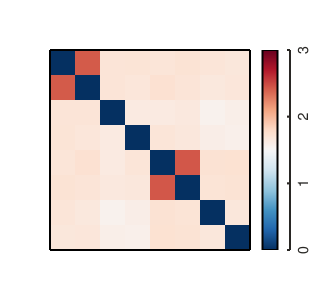

In [241]:
mdata = variable_gt_10K_true

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_gt.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    print(dists1)
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_gt_linked_10K_var = np.var(distances, axis=0)

c = plot_matrix(arr_variable_gt_linked_10K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb6_output/variable-gt-linked-10K-var.svg")
c

## Node distances Variance difference figures

### Linked 2K - Unlinked: Variable gt

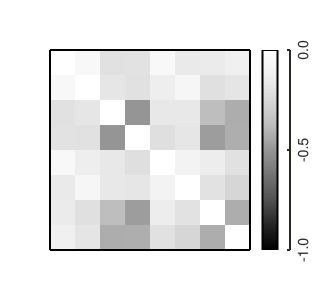

In [242]:
diff = (arr_variable_gt_linked_2K_var - arr_variable_gt_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "./nb6_output/variable-gt-linked-2K-var-diff.svg")
c

In [243]:
diff

array([[ 0.        , -0.05671625, -0.20522328, -0.20349469, -0.05940827,
        -0.15580045, -0.15336675, -0.12134519],
       [-0.05671625,  0.        , -0.18111635, -0.204623  , -0.13501984,
        -0.07463348, -0.212526  , -0.1829624 ],
       [-0.20522328, -0.18111635,  0.        , -0.50217915, -0.16761821,
        -0.16637071, -0.36898017, -0.42537285],
       [-0.20349469, -0.204623  , -0.50217915,  0.        , -0.21955496,
        -0.180512  , -0.479288  , -0.42178376],
       [-0.05940827, -0.13501984, -0.16761821, -0.21955496,  0.        ,
        -0.10267968, -0.1435704 , -0.20623408],
       [-0.15580045, -0.07463348, -0.16637071, -0.180512  , -0.10267968,
         0.        , -0.20260112, -0.2633144 ],
       [-0.15336675, -0.212526  , -0.36898017, -0.479288  , -0.1435704 ,
        -0.20260112,  0.        , -0.42678144],
       [-0.12134519, -0.1829624 , -0.42537285, -0.42178376, -0.20623408,
        -0.2633144 , -0.42678144,  0.        ]])

### Linked 10K - Unlinked: Variable gt

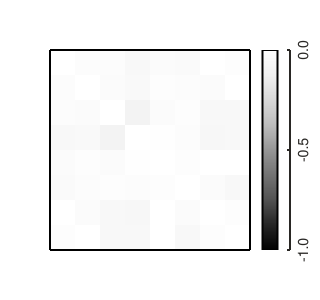

In [244]:
diff = (arr_variable_gt_linked_10K_var - arr_variable_gt_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "./nb6_output/variable-gt-linked-10K-var-diff.svg")
c

In [245]:
diff

array([[ 0.        , -0.02268096, -0.02093463, -0.05964396, -0.03134312,
        -0.0448038 ,  0.02252864, -0.01593115],
       [-0.02268096,  0.        , -0.03093331, -0.047735  , -0.01436424,
        -0.02019744, -0.03645856,  0.00549697],
       [-0.02093463, -0.03093331,  0.        , -0.10469335, -0.03083501,
        -0.01922511, -0.05510985, -0.05708128],
       [-0.05964396, -0.047735  , -0.10469335,  0.        , -0.005356  ,
        -0.0236302 , -0.06515   , -0.05619707],
       [-0.03134312, -0.01436424, -0.03083501, -0.005356  ,  0.        ,
        -0.01243344,  0.04817932,  0.02880527],
       [-0.0448038 , -0.02019744, -0.01922511, -0.0236302 , -0.01243344,
         0.        , -0.03319312, -0.05805623],
       [ 0.02252864, -0.03645856, -0.05510985, -0.06515   ,  0.04817932,
        -0.03319312,  0.        , -0.01873605],
       [-0.01593115,  0.00549697, -0.05708128, -0.05619707,  0.02880527,
        -0.05805623, -0.01873605,  0.        ]])

### Linked 2K - Unlinked: Variable Ne

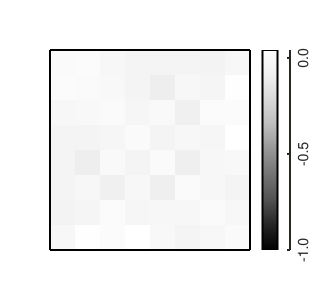

In [246]:
diff = (arr_variable_ne_linked_2K_var - arr_variable_ne_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "./nb6_output/variable-ne-linked-2K-var-diff.svg")
c

In [247]:
diff

array([[ 0.        ,  0.00501843, -0.02991376, -0.05687591, -0.05287317,
        -0.05828939, -0.06398892, -0.03099051],
       [ 0.00501843,  0.        , -0.01586919, -0.05248504, -0.10193952,
        -0.03197536, -0.04693369,  0.0319348 ],
       [-0.02991376, -0.01586919,  0.        , -0.03634401, -0.01122435,
        -0.08405573,  0.00975448,  0.00664983],
       [-0.05687591, -0.05248504, -0.03634401,  0.        , -0.05485432,
        -0.0240208 , -0.03415911,  0.04151312],
       [-0.05287317, -0.10193952, -0.01122435, -0.05485432,  0.        ,
        -0.09282   , -0.03234365, -0.0217372 ],
       [-0.05828939, -0.03197536, -0.08405573, -0.0240208 , -0.09282   ,
         0.        , -0.02831155, -0.0519552 ],
       [-0.06398892, -0.04693369,  0.00975448, -0.03415911, -0.03234365,
        -0.02831155,  0.        , -0.03114387],
       [-0.03099051,  0.0319348 ,  0.00664983,  0.04151312, -0.0217372 ,
        -0.0519552 , -0.03114387,  0.        ]])

### Linked 10K - Unlinked: Variable Ne

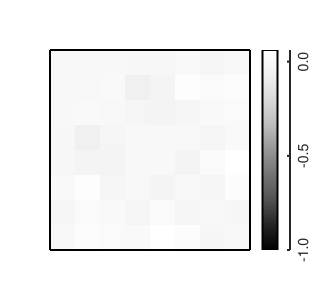

In [248]:
diff = (arr_variable_ne_linked_10K_var - arr_variable_ne_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "./nb6_output/variable-ne-linked-10K-var-diff.svg")
c

In [249]:
diff

array([[ 0.        , -0.00200357,  0.00102288, -0.01272775, -0.00465312,
         0.009708  , -0.01968352, -0.00037984],
       [-0.00200357,  0.        ,  0.00857925, -0.07127568, -0.03578917,
         0.04580573,  0.02005295,  0.03346969],
       [ 0.00102288,  0.00857925,  0.        , -0.02290281, -0.0378484 ,
        -0.02631904,  0.005686  ,  0.01439968],
       [-0.01272775, -0.07127568, -0.02290281,  0.        ,  0.00361169,
        -0.00090605, -0.02485435,  0.00699991],
       [-0.00465312, -0.03578917, -0.0378484 ,  0.00361169,  0.        ,
        -0.03777624,  0.01639008,  0.0619728 ],
       [ 0.009708  ,  0.04580573, -0.02631904, -0.00090605, -0.03777624,
         0.        , -0.0262724 ,  0.03728692],
       [-0.01968352,  0.02005295,  0.005686  , -0.02485435,  0.01639008,
        -0.0262724 ,  0.        , -0.02046376],
       [-0.00037984,  0.03346969,  0.01439968,  0.00699991,  0.0619728 ,
         0.03728692, -0.02046376,  0.        ]])